# ESI Presentation Figures
Here, we will generate figures for the presentation at the conference "Infinite-dimensional Geometry: Theory and Applications
" at ESI in Vienna.

## Total mass constraint
We will transport a Gaussian bump under the following constraints:
- Wasserstein (Unconstrained)
- WFR (Unconstrained)
- $\rho_t(\Omega) = 1$ i.e. SHK
- $\rho_t(\Omega) = 1-2t(t-1)$

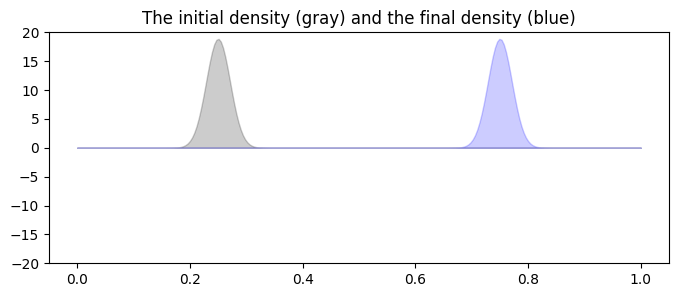

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact

# Plotting initial and the final density
sigma = 0.03
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

def gauss(x, x_0, sigma, mass):
    # Gaussian bump
    normalized_factor = np.exp(-((x - x_0) ** 2) / sigma ** 2)
    return mass * (normalized_factor * K / np.sum(normalized_factor))

rho_0 = gauss(X, 0.25, sigma, 1) # Initial density
rho_1 = gauss(X, 0.75, sigma, 1)  # Final density

# Normalizing densities
rho_0 /= np.sum(rho_0) / 256 # make sure the total mass is 1
rho_1 /= np.sum(rho_1) / 256

rho_0.dtype = np.float64
rho_1.dtype = np.float64

# Plotting
plt.figure(figsize=(8, 3))
plt.ylim(-20, 20)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
plt.show()

In [3]:
T = 15 # number of time steps
ll = (1.0, 1.0) # size of time x space box
H = np.ones((T,K))
time = np.array([(i+0.5)/T for i in range(0,T)])

xs = []

# Wasserstein
#x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=0.0, #delta=0.5/np.pi, niter=3000)
#xs.append(x)

delta = 0.5/np.pi

# Wasserstein-Fisher-Rao
x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=delta, niter=3000)
xs.append(x)

# SHK
F = np.ones(T)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=delta, niter=3000, big_matrix=True, verbose=True)
xs.append(x) #about 8 seconds

# F(t) = 1 + 2t(1-t)
F = 1 + 2*time*(1-time)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=delta, niter=3000)
xs.append(x)

Computing a geodesic for optimal transport with source and constraint...
Progress: 0%

c:\Users\mao17\Workspace\pdot\venv\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Progress: 99%
Done.


### Plotting

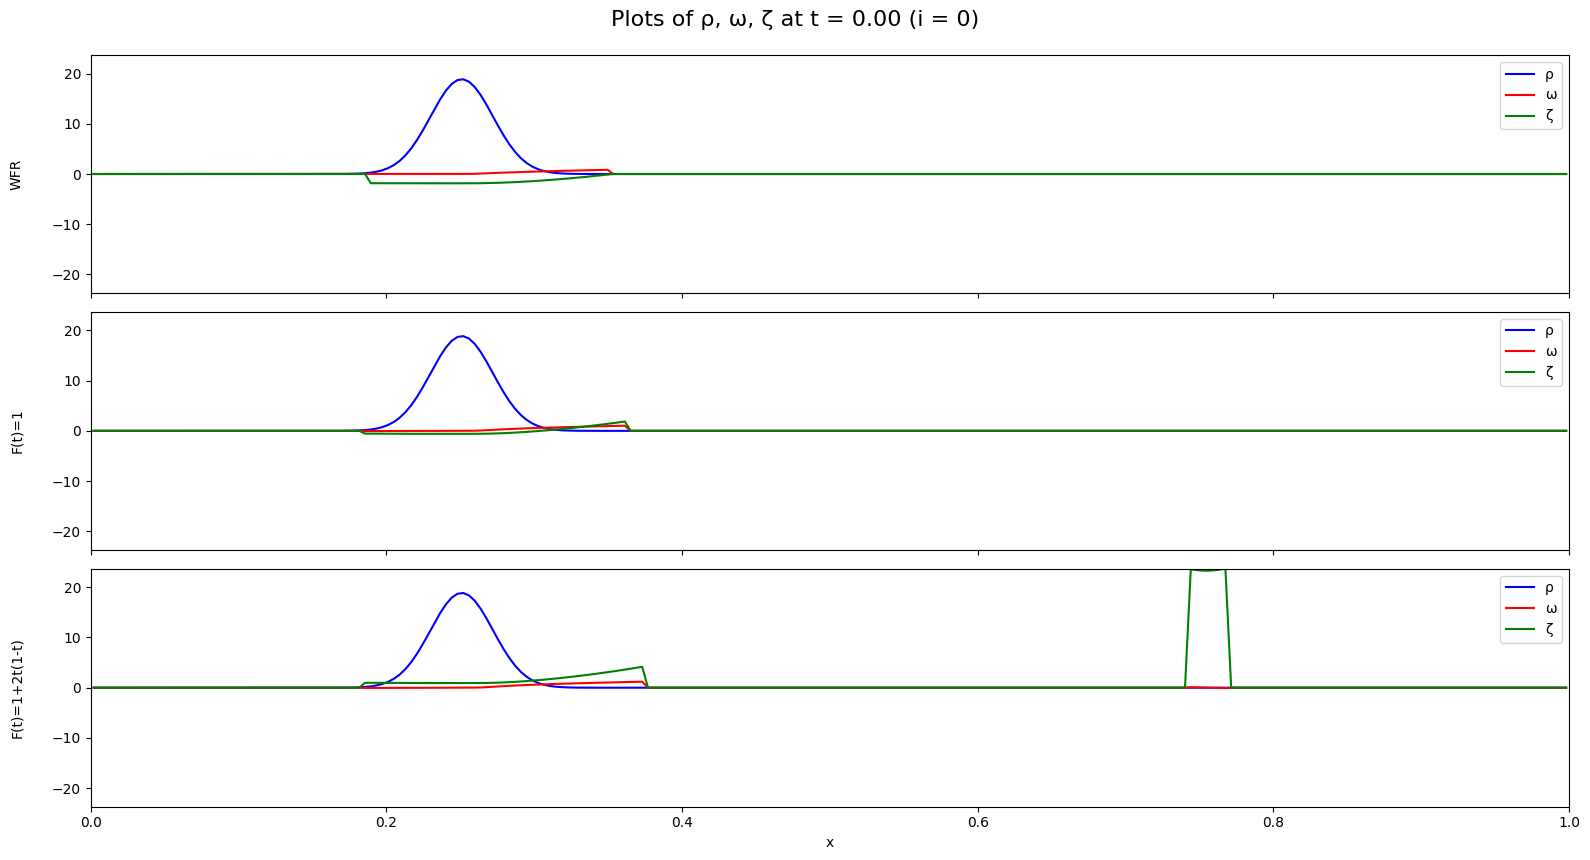

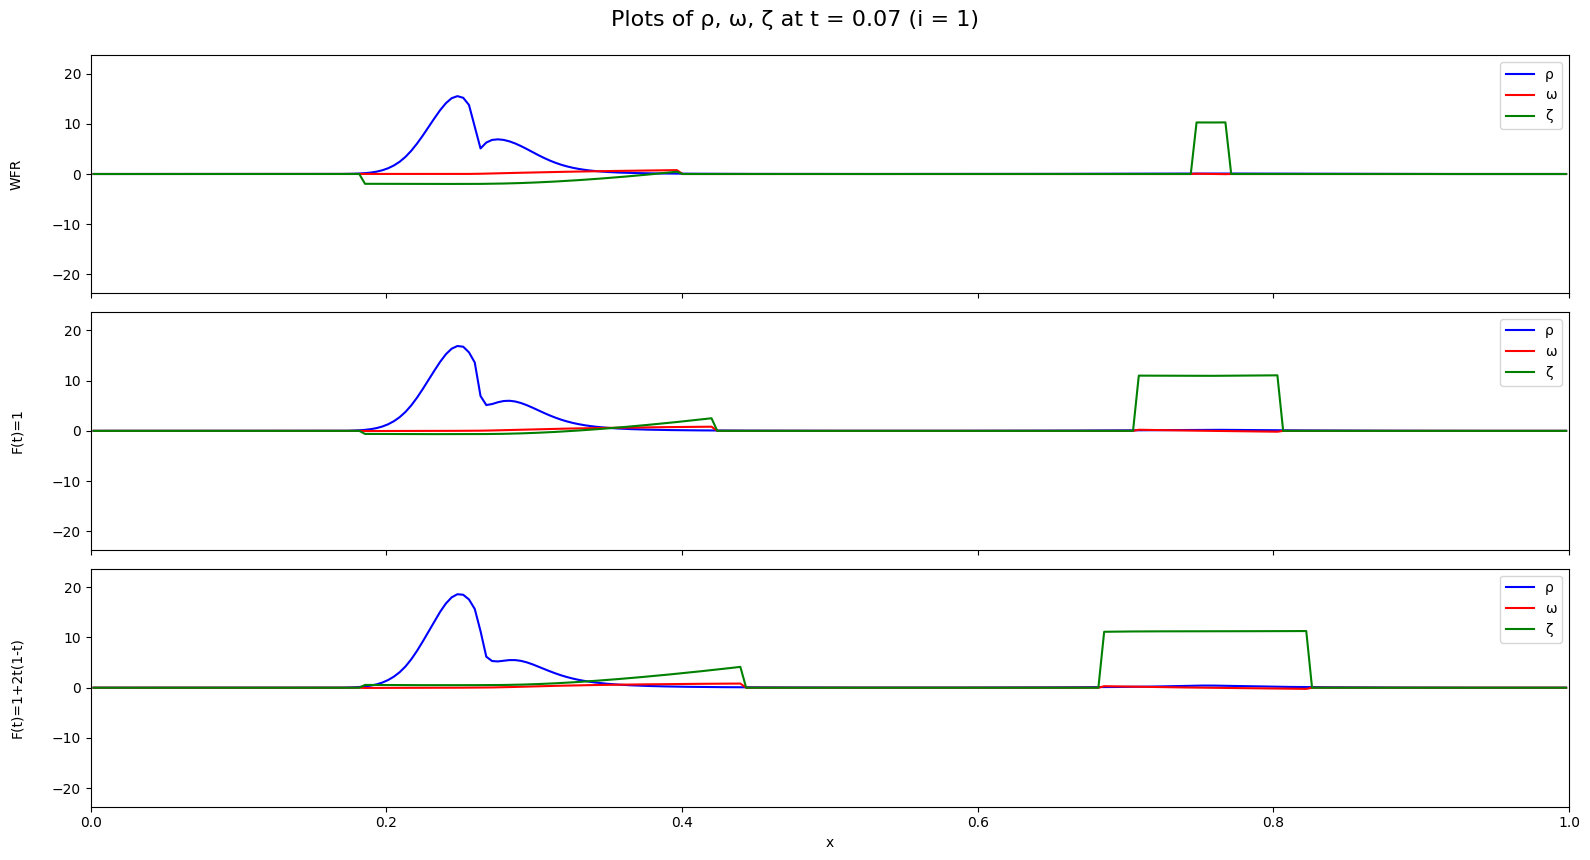

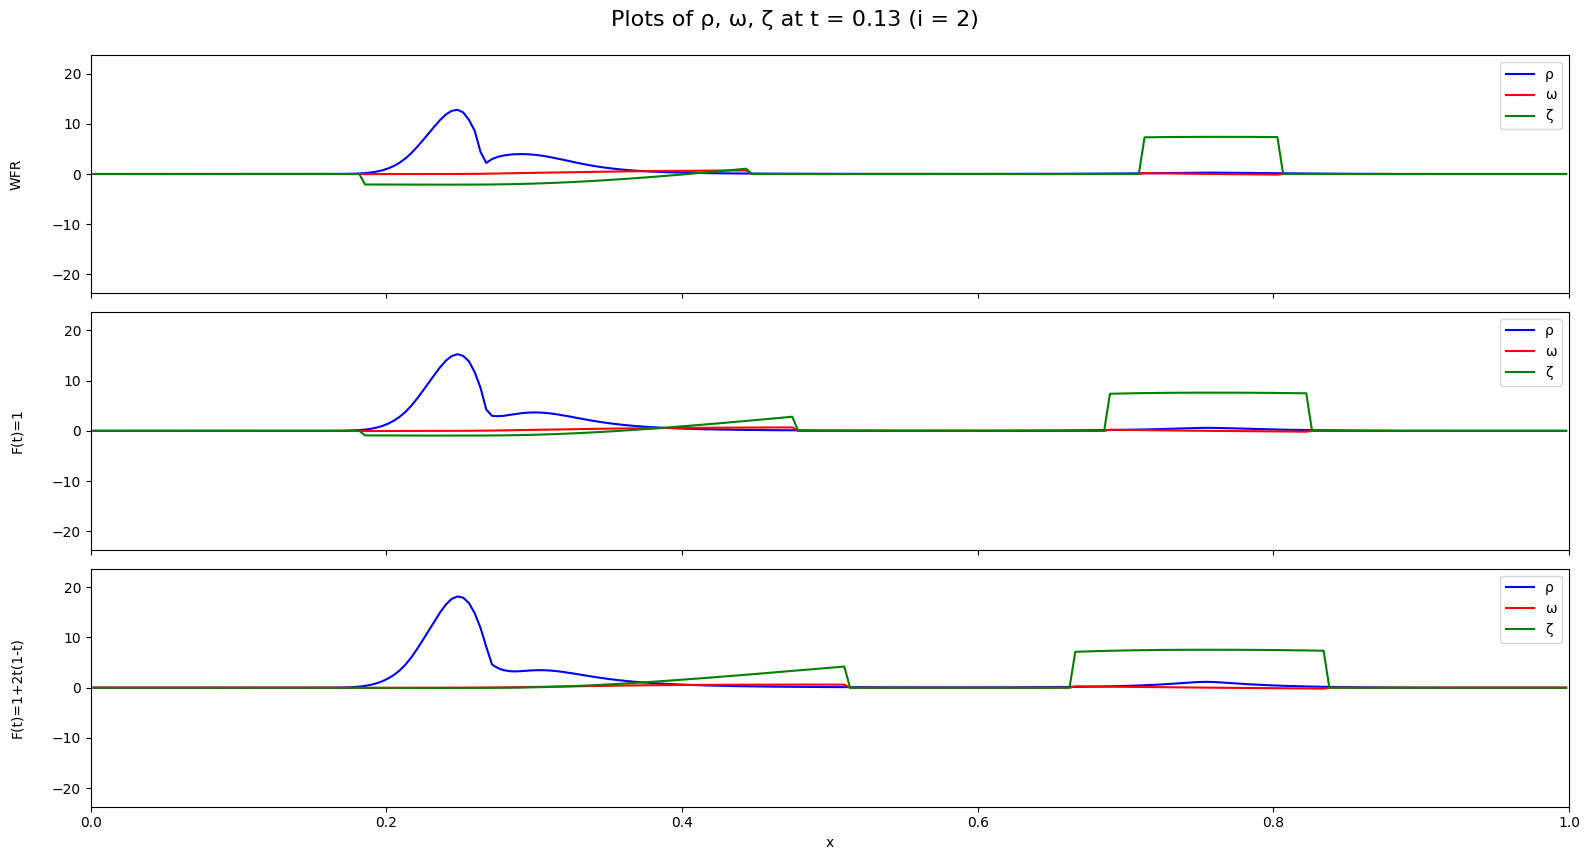

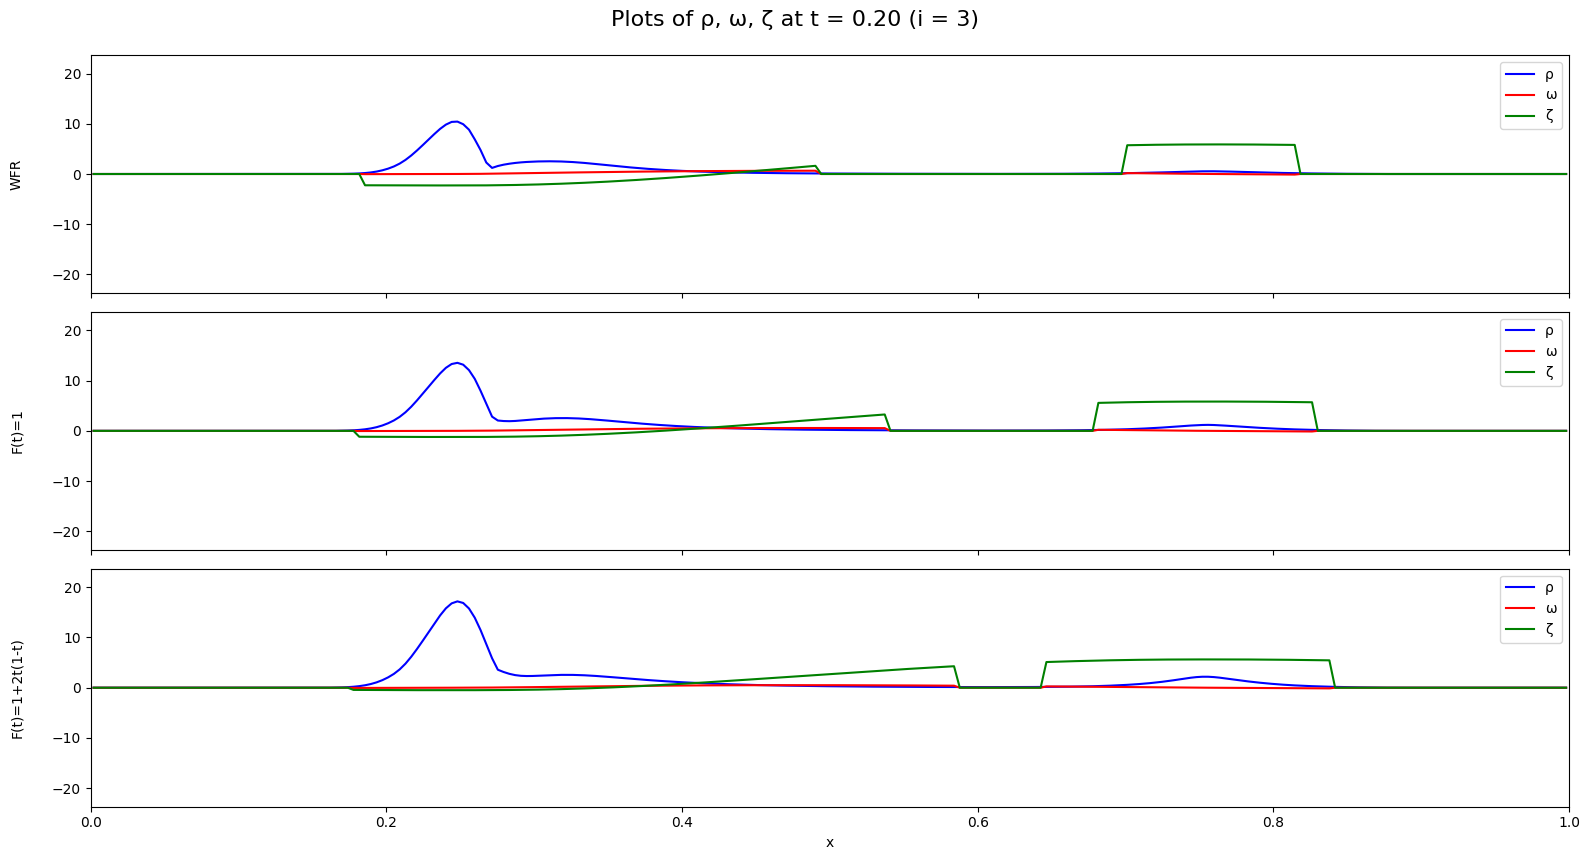

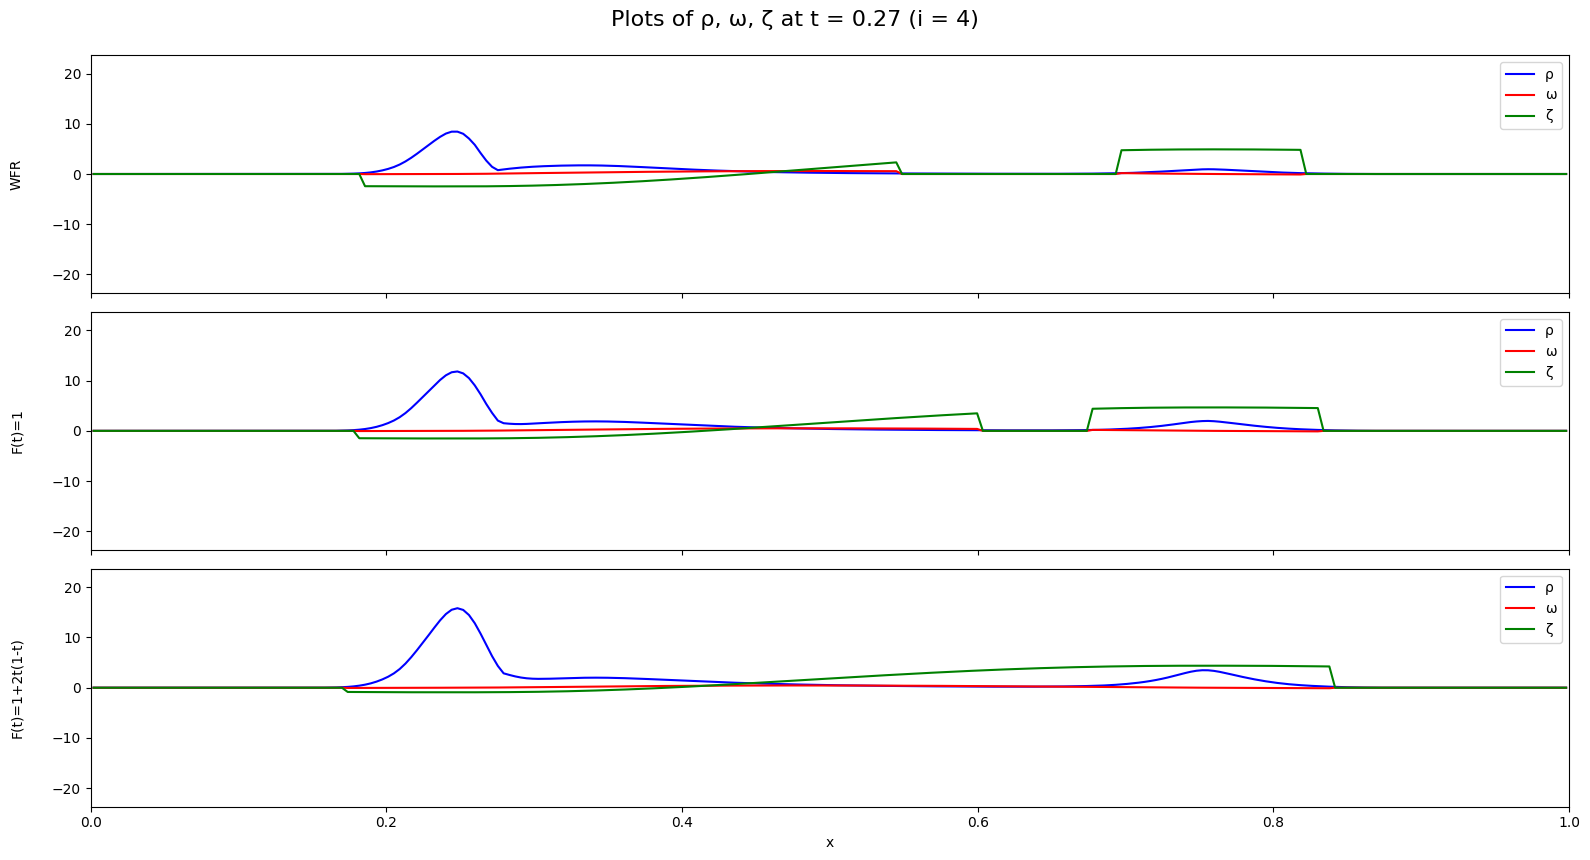

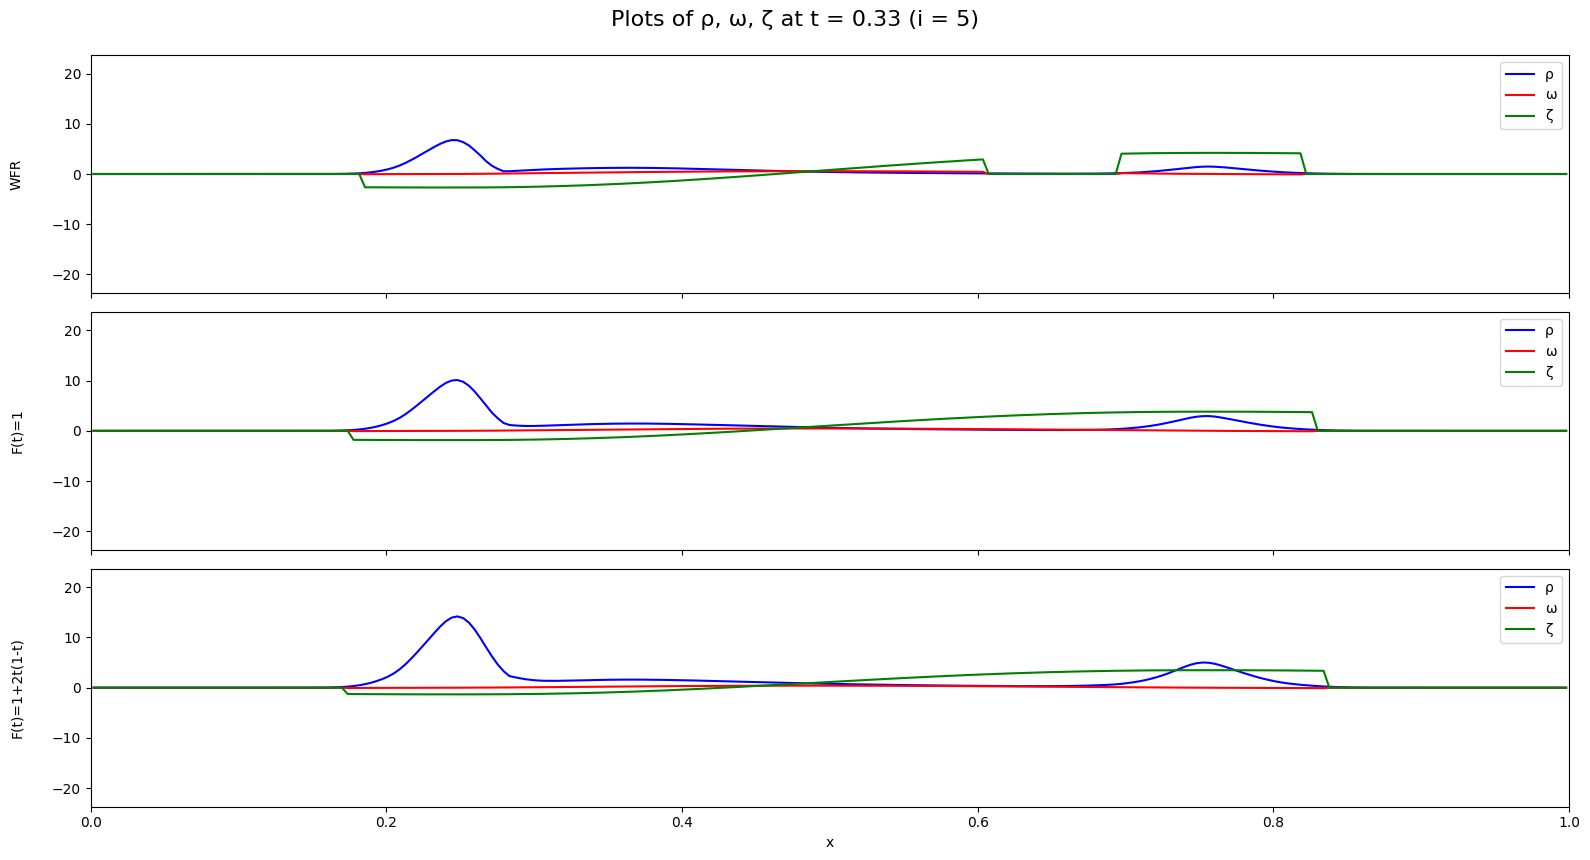

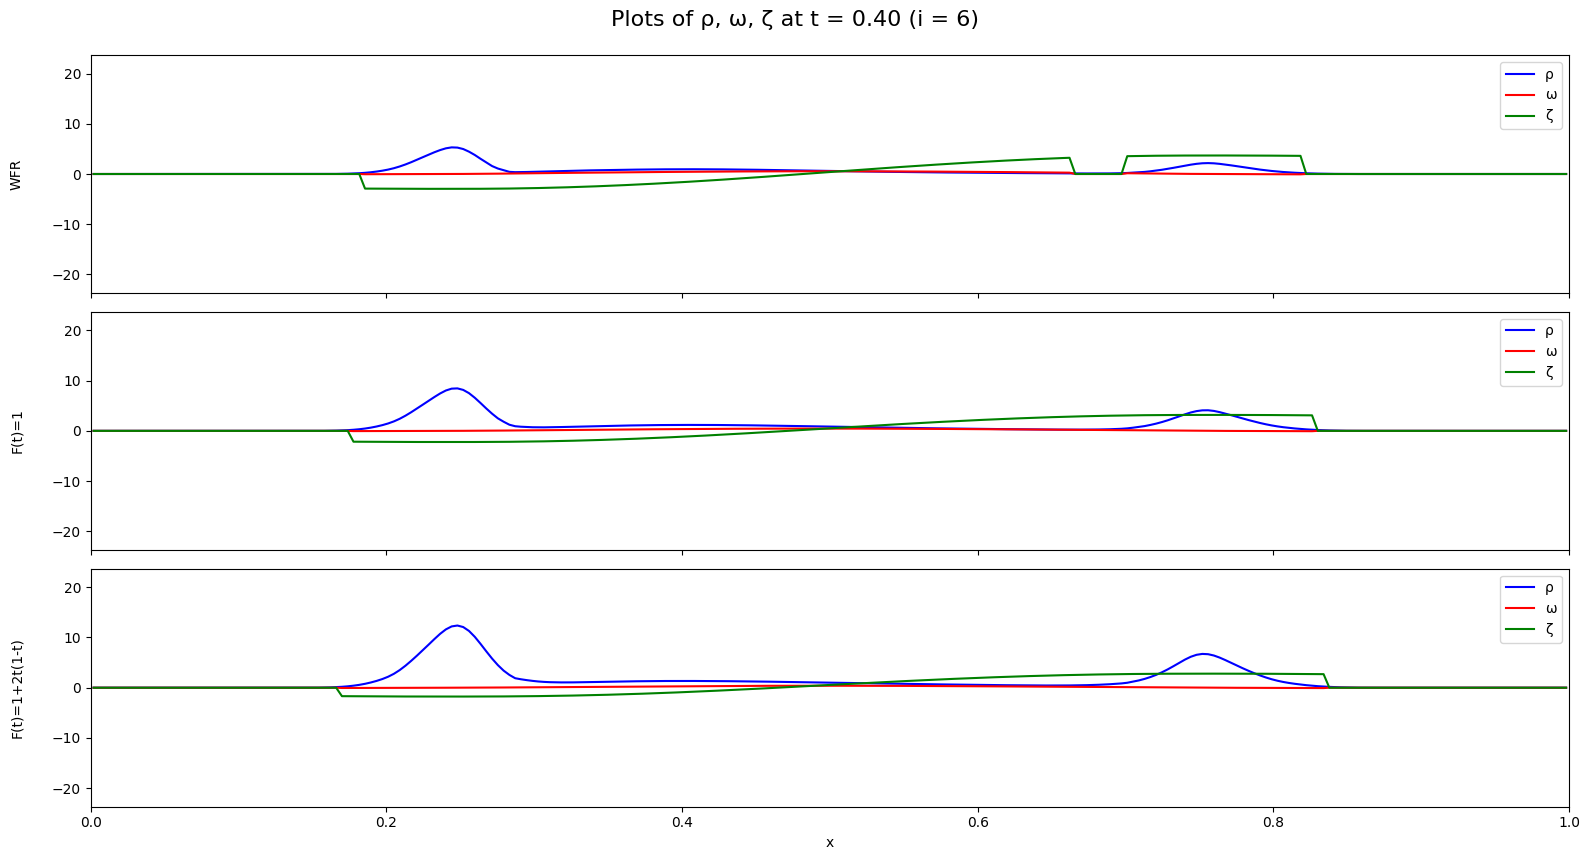

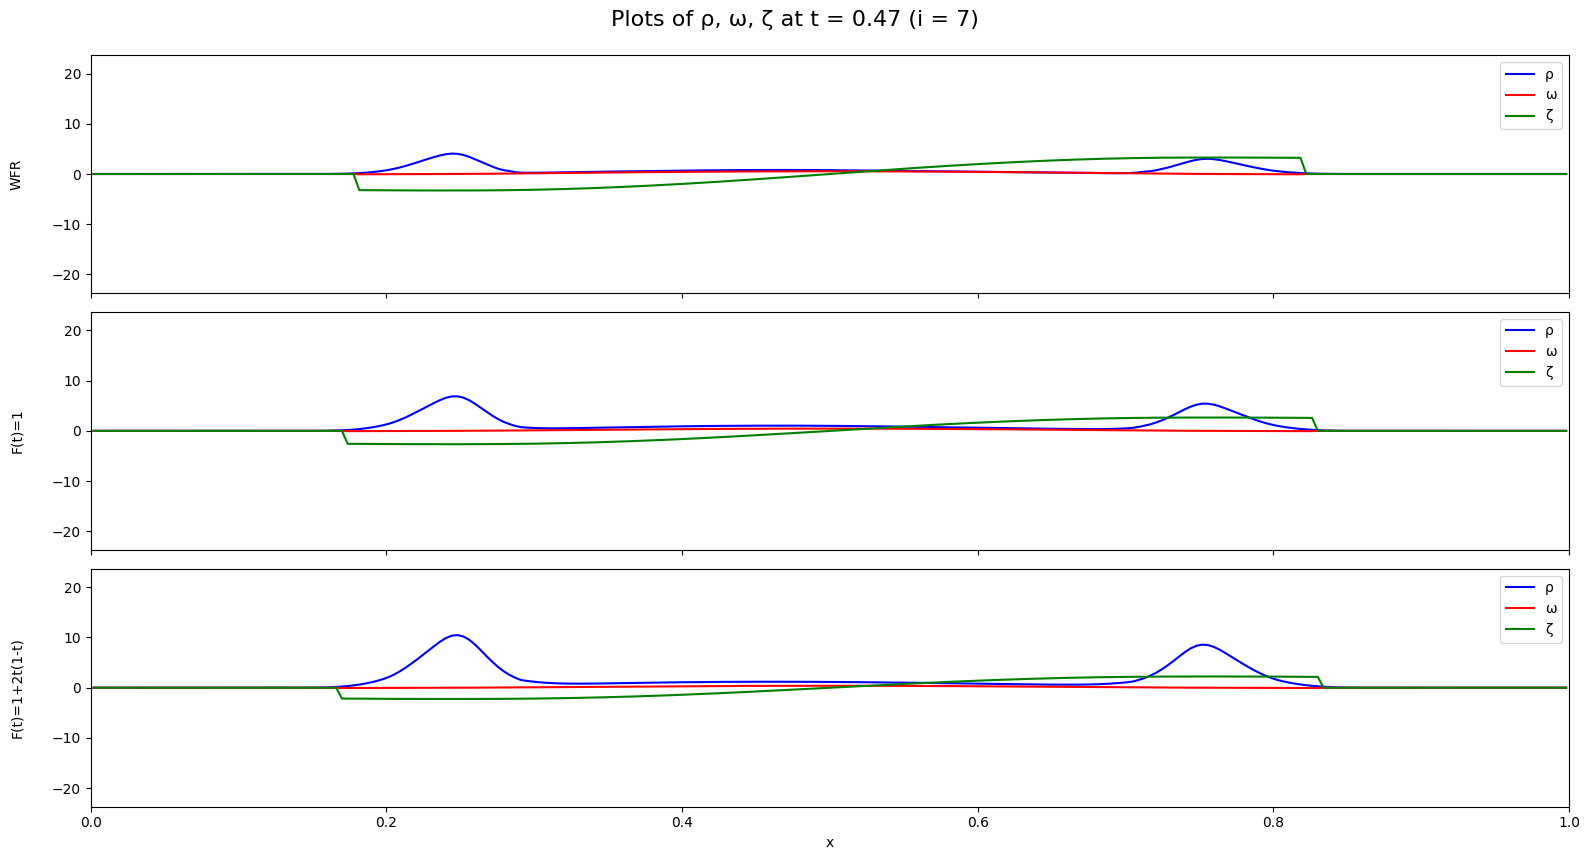

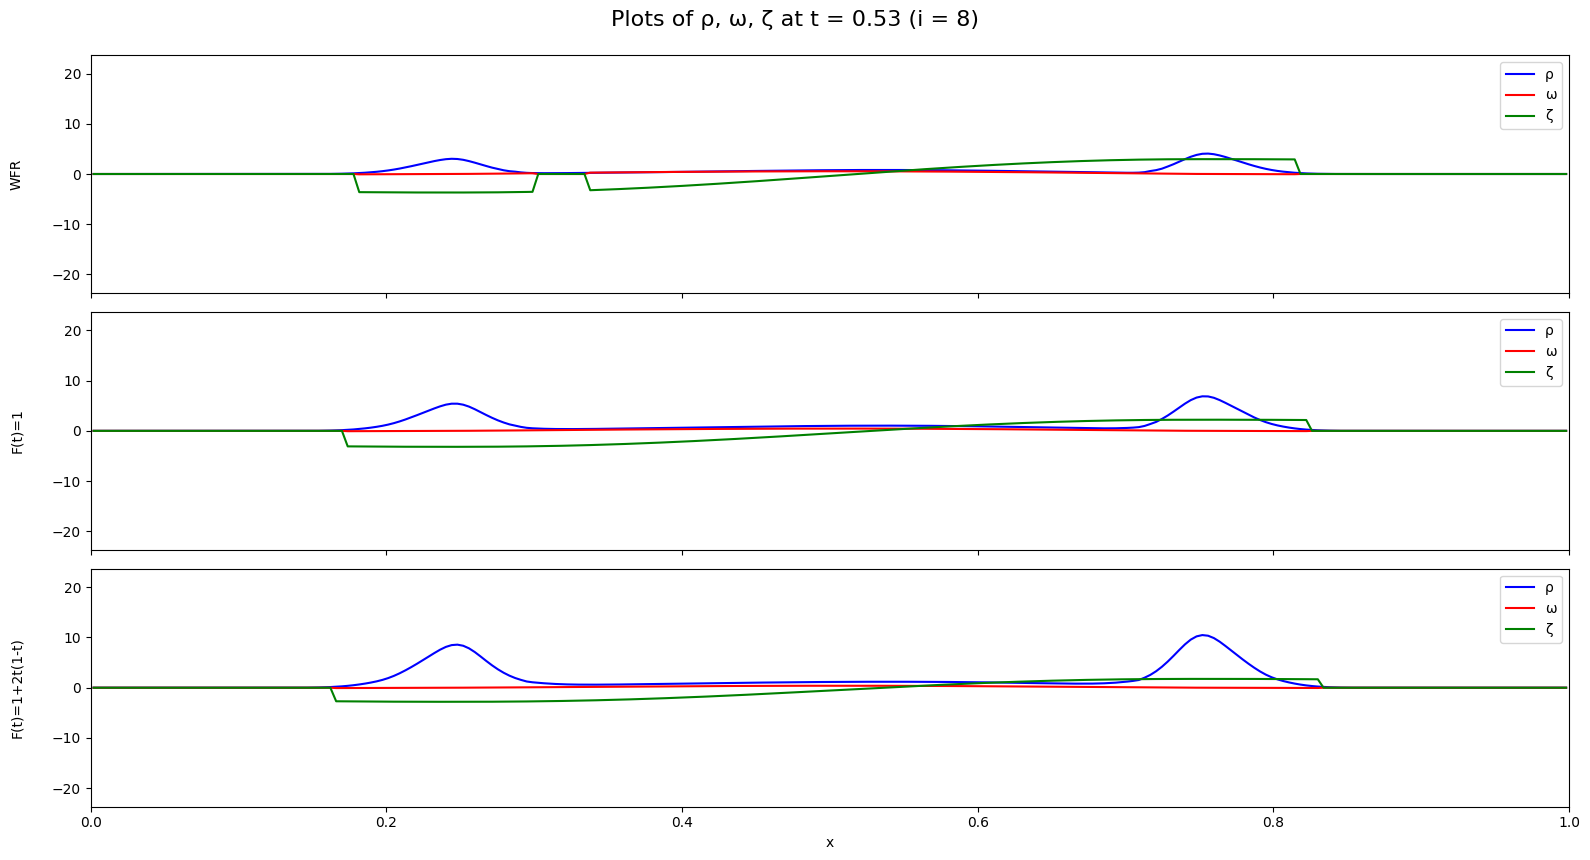

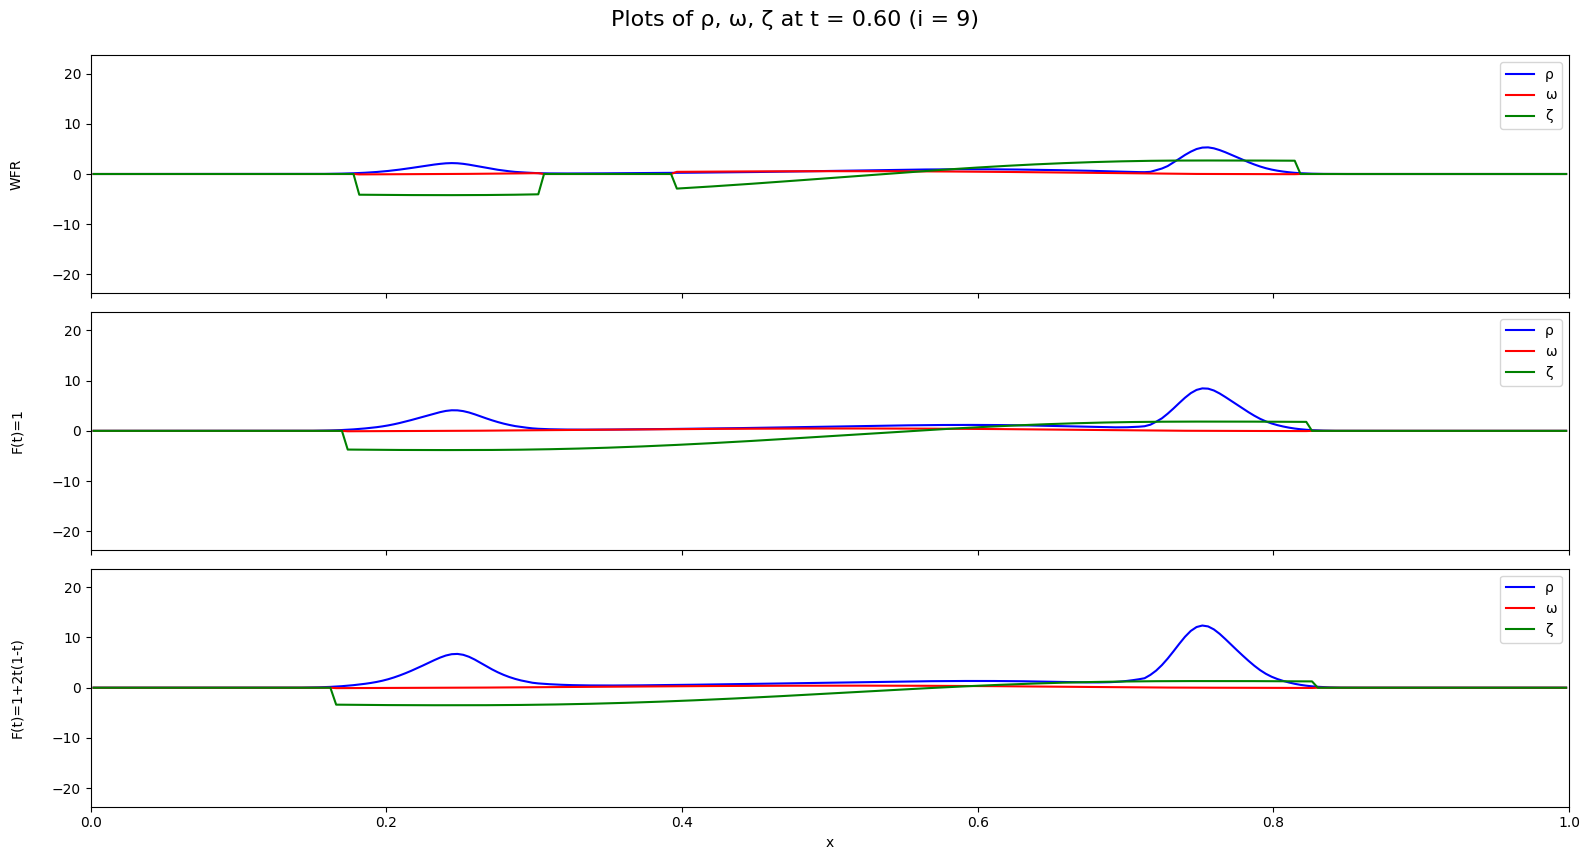

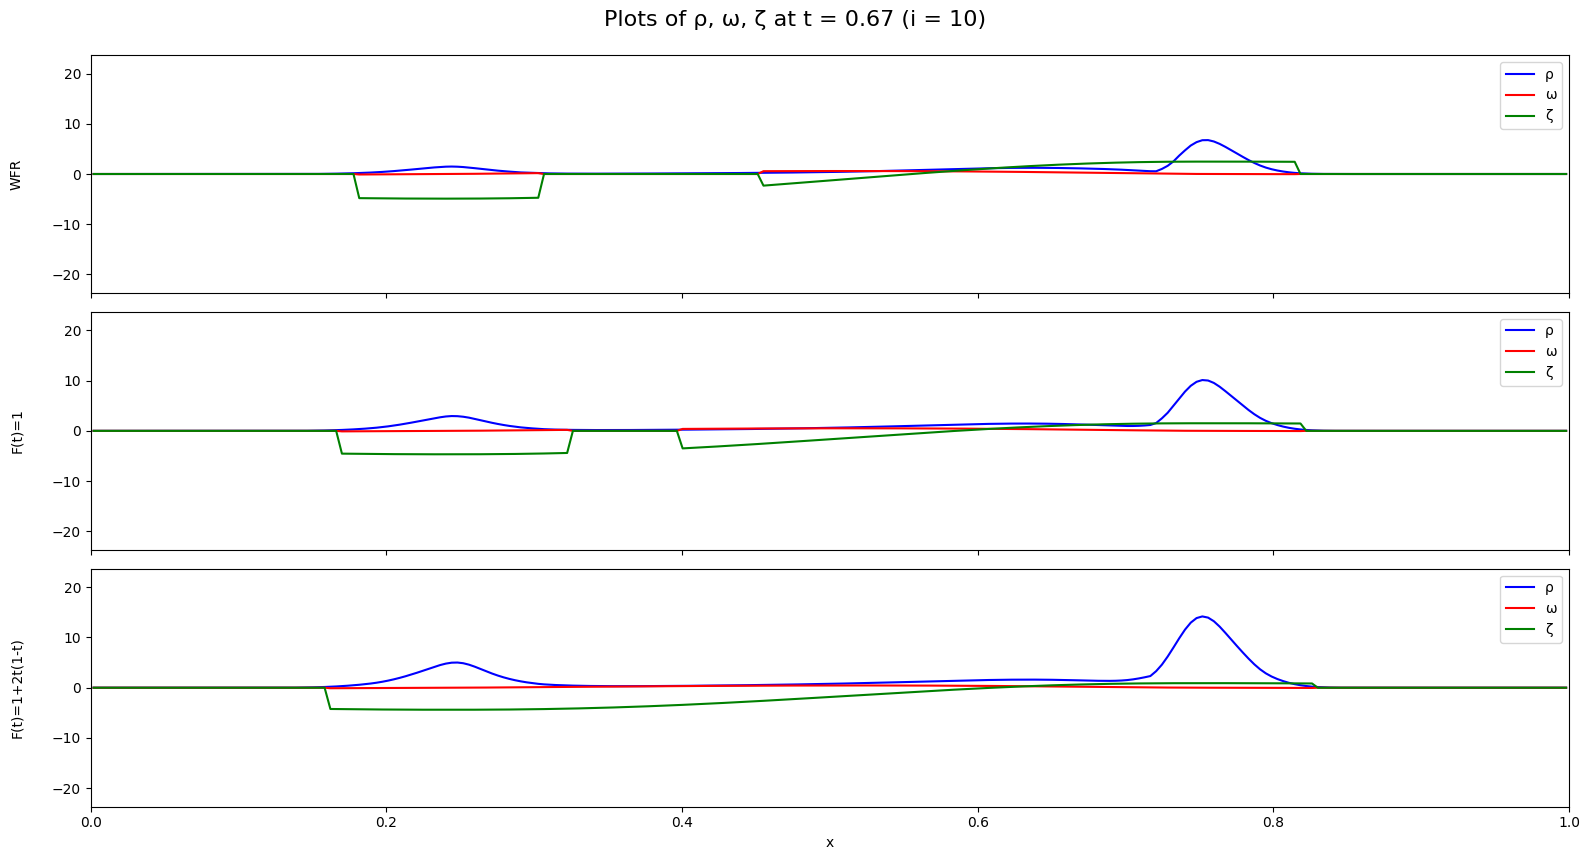

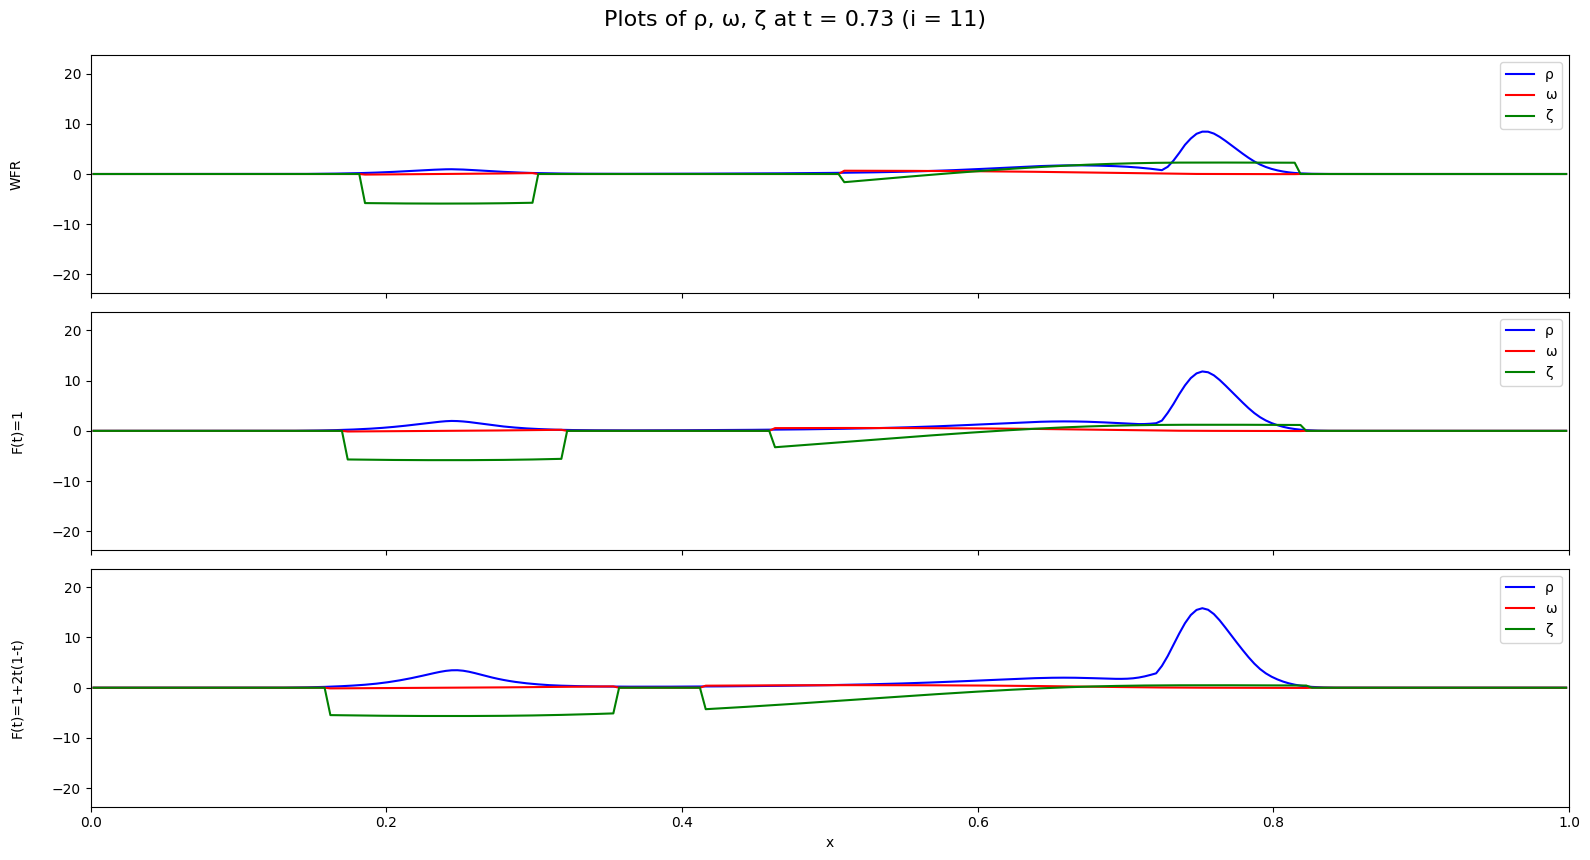

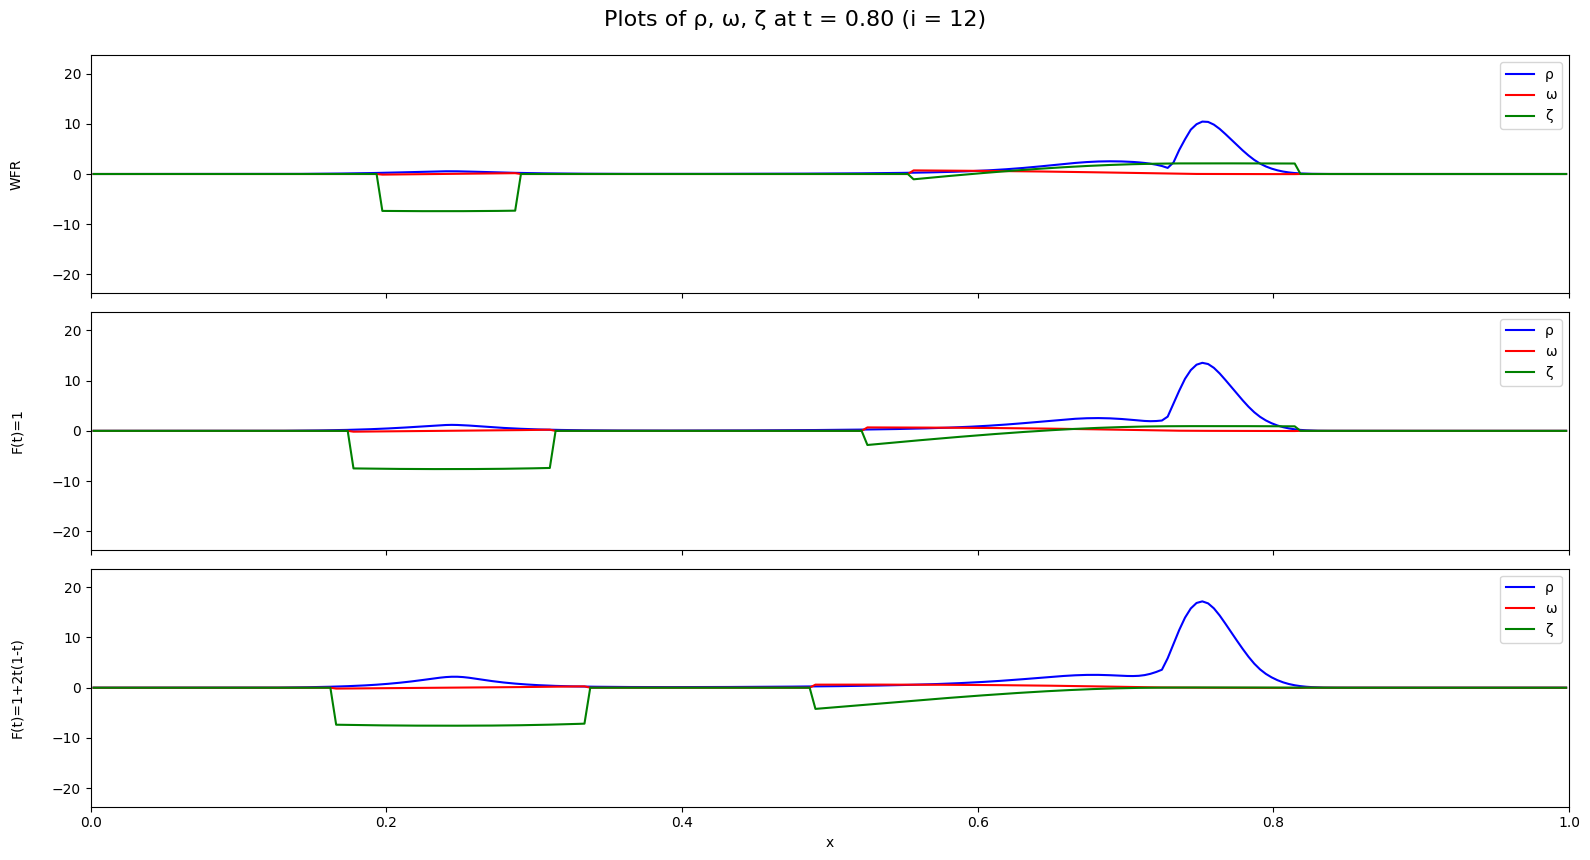

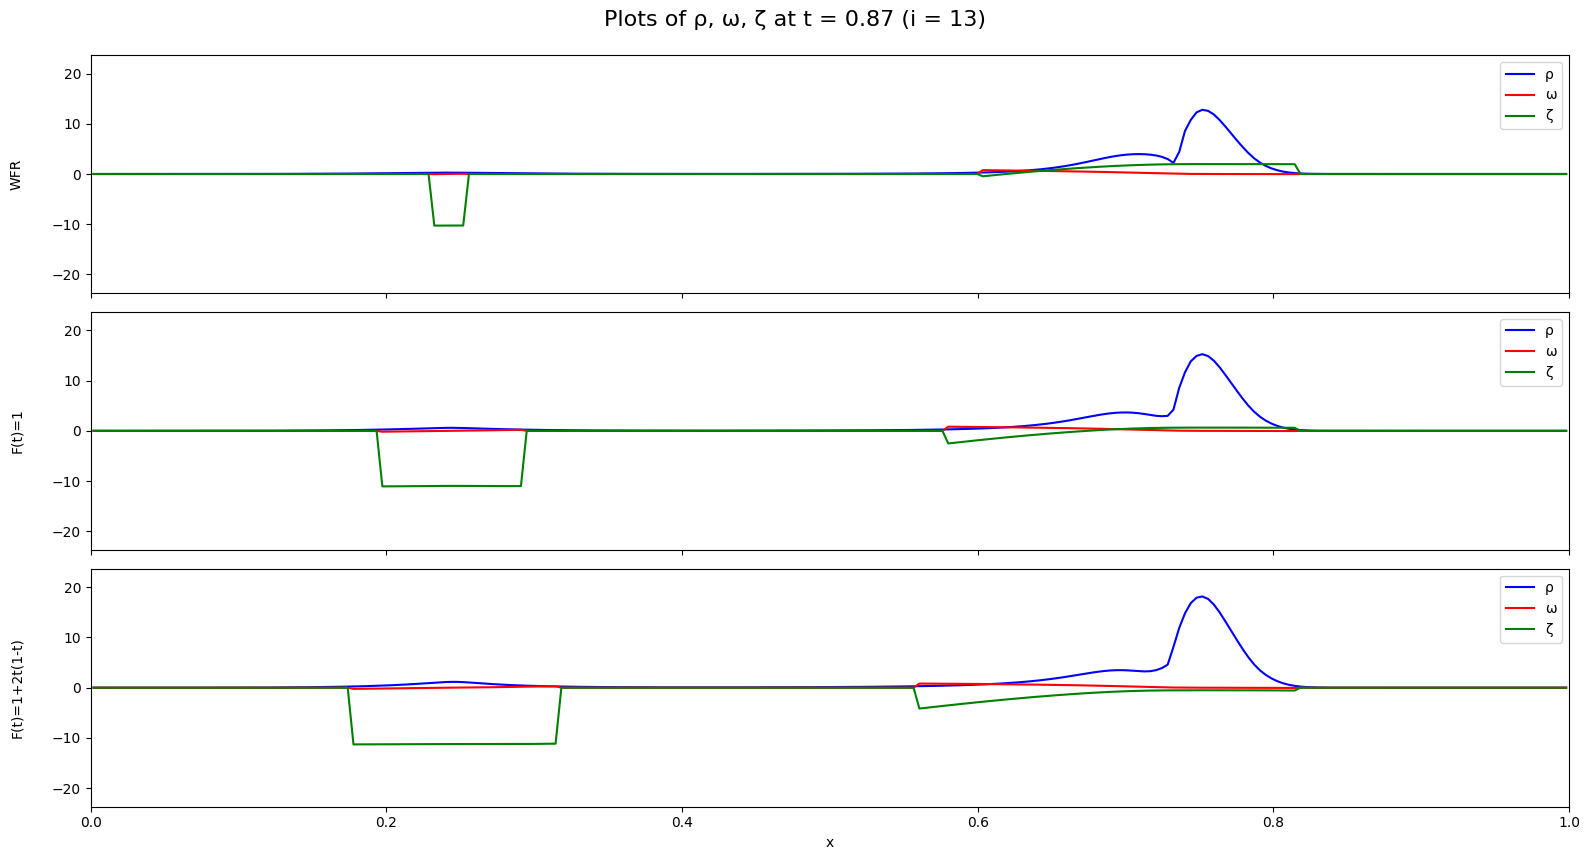

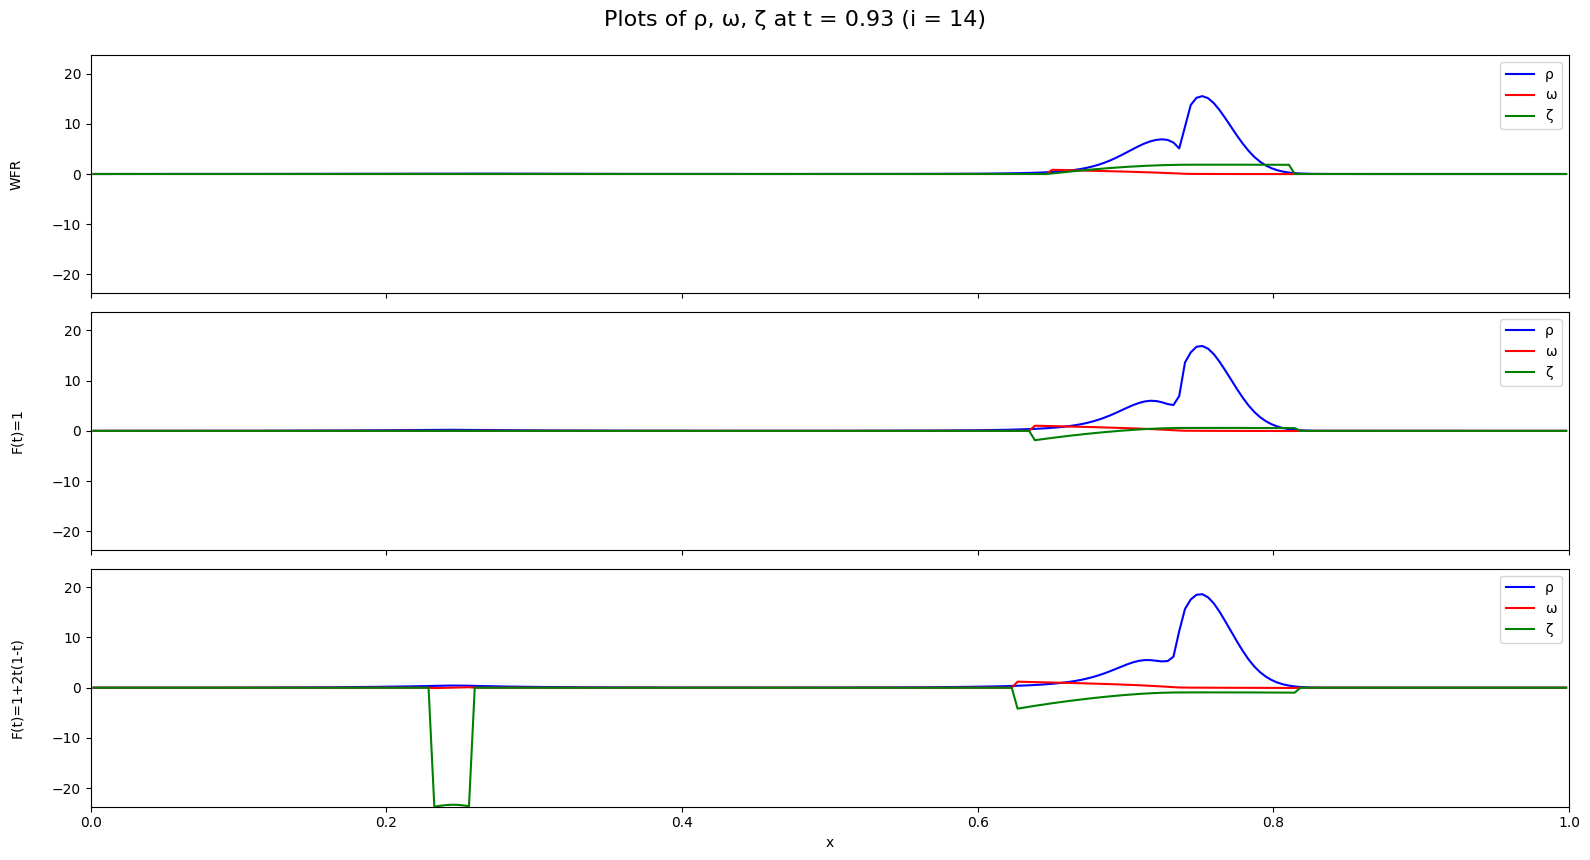

In [4]:
import numpy as np
import matplotlib.pyplot as plt

Ds = []
vs = []
gs = []
for x in xs:
    Ds.append(x.U.D[0])
    v, g = speed_and_growth(x.V, 100)
    vs.append(v[0])
    gs.append(g)

# Time and space grids
t = np.linspace(0, 1, 16)             # t_i = i/15
x_grid = (np.arange(256) + 0.5) / 256 # x_j = (j+0.5)/256

# Row labels
row_labels = ["WFR", "F(t)=1", "F(t)=1+2t(1-t)"]

# Indices of time to plot
time_indices = list(range(15))

# -----------------------------------------------------------
# 2) Compute global min/max for each row across *all times*
#    and across D, v, and g. This ensures fixed y-limits.
# -----------------------------------------------------------
num_rows = len(row_labels)
min_vals = float('inf')
max_vals = float('-inf')

for row in range(num_rows):
    # Flatten or just use min/max on the entire 16x256 data
    # across D, v, and g for row 'row'
    row_min = min(Ds[row].min(), vs[row].min(), gs[row].min())
    row_max = max(Ds[row].max(), vs[row].max(), gs[row].max())
    
    min_vals = min(row_min, min_vals)
    max_vals = max(row_max, max_vals)

# -----------------------------------------------------------
# 3) Loop through the selected time indices and plot
# -----------------------------------------------------------
for i in time_indices:
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(16, 9), sharex=True)
    
    # Main figure title
    fig.suptitle(f"Plots of ρ, ω, ζ at t = {t[i]:.2f} (i = {i})", fontsize=16, y=0.95)

    for row in range(num_rows):
        ax = axes[row]
        
        # Plot all three on the same axes
        ax.plot(x_grid, Ds[row][i, :], label='ρ', color='blue')
        ax.plot(x_grid, vs[row][i, :], label='ω', color='red')
        ax.plot(x_grid, gs[row][i, :], label='ζ', color='green')
        
        # Set fixed y-limits for this row
        ax.set_ylim([min_vals, max_vals])
        
        # Set x-limits if desired (0 to 1 here)
        ax.set_xlim([0, 1])

        # Label the y-axis to indicate the row
        ax.set_ylabel(row_labels[row], rotation=90, labelpad=20)
        
        # Show legend in each subplot
        ax.legend(loc='best')
    
    # Label the x-axis on the bottom subplot
    axes[-1].set_xlabel("x")
    
    # Final layout adjustments
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

# Total mass

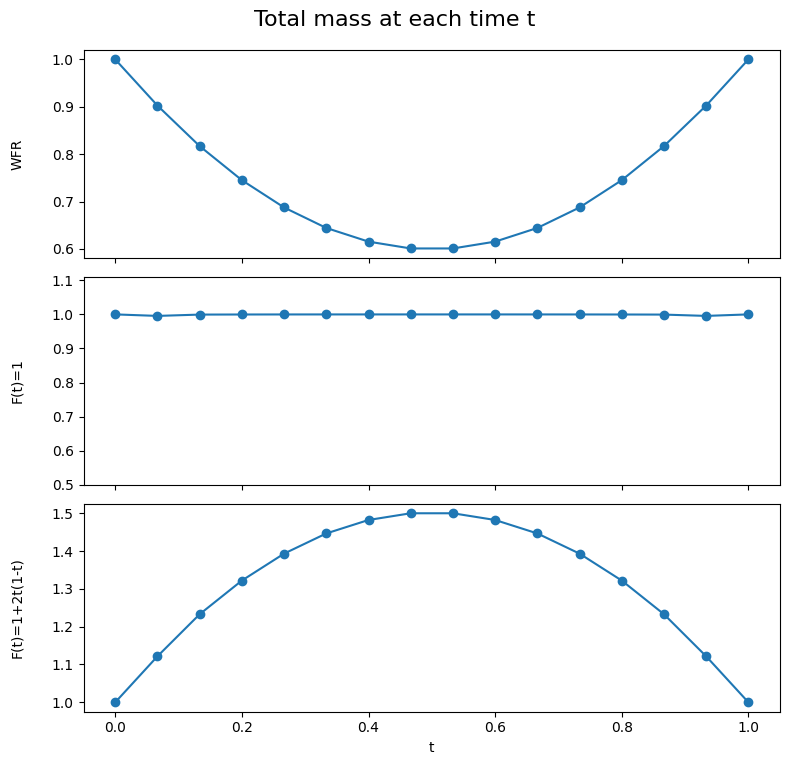

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex=True)

fig.suptitle("Total mass at each time t", fontsize=16, y=0.95)

for row in range(3):
    # sum across columns (axis=1) => shape becomes (16,) for each element
    sum_over_x = np.sum(Ds[row], axis=1) / 256  # sums each row of Ds[row]
    if row == 1:
        axes[row].set_ylim(0.5, 1.11)
    axes[row].plot(t, sum_over_x, marker='o', label="Total mass")
    axes[row].set_ylabel(row_labels[row], rotation=90, labelpad=20)
    
    # Optionally add a legend
    #axes[row].legend(loc='best')

axes[-1].set_xlabel("t")
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()


# Moving Barrier

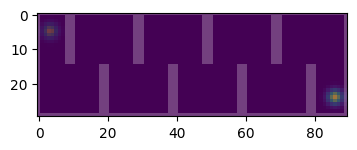

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact
import scipy as sp

def create_arena(
    T, 
    height=30, 
    width=90, 
    speed=1.0, 
    wall_strength=1.0, 
    perimeter_strength=2.0,
    spawn_new_walls=True
):
    """
    Create a time-series (T steps) arena with:
      - Moving walls sweeping from right to left,
      - A 1-pixel-wide perimeter wall,
      - Optionally, a continuous stream of new walls.
    
    Parameters
    ----------
    T : int
        Number of time steps to simulate.
    height : int
        The height of the arena (default=30).
    width : int
        The width of the arena (default=90).
    speed : float
        Speed at which walls move to the left (pixels per time step).
    wall_strength : float
        Numeric value for the moving walls.
    perimeter_strength : float
        Numeric value for the 1-pixel-wide boundary wall.
    spawn_new_walls : bool
        If True (default), new walls keep appearing from the right edge (x=83).
        If False, only walls initially in the domain [8, 83] are generated, 
        and no new walls enter as time progresses.
    
    Returns
    -------
    arena : ndarray of shape (T, height, width)
        A 3D NumPy array where `arena[t]` is the 2D configuration at time t.
        0 = empty cell,
        > 0 = walls (actual numeric values can differ).
    """
    
    arena = np.zeros((T, height, width), dtype=float)

    wall_width = 3
    wall_height = 15
    gap = 7
    spacing = wall_width + gap  # = 10

    if spawn_new_walls:
        # Generate enough walls so new ones can keep coming in from x=83
        # up to time T
        max_x = 83 + T * speed
    else:
        # Only generate walls initially within the domain [8, 83].
        max_x = 83
    
    x_positions = []
    n = 0
    while True:
        x0 = 8 + n * spacing
        if x0 > max_x:
            break
        x_positions.append(x0)
        n += 1
    
    for t in range(T):
        # Fill in the moving walls
        for i, x0 in enumerate(x_positions):
            x_left = x0 - speed * t
            x_right = x_left + wall_width
            
            # Skip if fully outside [8, 83]
            if x_right <= 8 or x_left >= 84:
                continue
            
            # Clamp to [8, 83] for drawing
            draw_left = max(x_left, 8)
            draw_right = min(x_right, 84)  # 84 is one past 83
            
            # Also clamp to [0, width)
            draw_left = max(draw_left, 0)
            draw_right = min(draw_right, width)
            
            left_idx = int(np.floor(draw_left))
            right_idx = int(np.ceil(draw_right))
            
            if left_idx >= right_idx:
                continue
            
            # Alternate top/bottom walls
            if i % 2 == 0:
                # Top wall
                arena[t, 0:wall_height, left_idx:right_idx] = wall_strength
            else:
                # Bottom wall
                arena[t, height - wall_height:height, left_idx:right_idx] = wall_strength
        
        # Add a 1-pixel-wide perimeter wall
        arena[t, 0, :] = perimeter_strength
        arena[t, height - 1, :] = perimeter_strength
        arena[t, :, 0] = perimeter_strength
        arena[t, :, width - 1] = perimeter_strength

    return arena

def plot_arena(arena, time_step=0):
    """
    Plot the arena at the specified time step.
    'arena' has shape (T, H, W).
    """
    plt.figure(figsize=(8, 4))
    plt.imshow(arena[time_step], cmap='gray', origin='upper', aspect='auto')
    plt.title(f"Arena at time {time_step}")
    plt.colorbar(label="Cell Value (0=empty)")
    plt.xlabel("X")
    plt.ylabel("Y (0 at top)")
    plt.show()

T = 15
N1 = 30
N2 = 90
ll = (1.0, 1.0, 3.0)
dx = [ll[1]/N1, ll[2]/N2]

indicesX = np.arange(N1) * dx[0]
indicesY = np.arange(N2) * dx[1]
xx, yy = np.meshgrid(indicesX, indicesY, indexing='ij')

"""
rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 10./90.], cov=3./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 40./90.], cov=3./36**2)
"""

# Original setting:
rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 10./90.], cov=3./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 258./90.], cov=3./36**2)


H = create_arena(T, height=30, width=90, speed=1, perimeter_strength=1.0, wall_strength=1.0, spawn_new_walls=False)
frame0_masked = np.ma.masked_where(H[0] > 0, H[0])
F = np.zeros((T,))

plt.figure(figsize=(4, 3))
plt.imshow(frame0_masked)
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()

## Calculation

In [2]:
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p=2.0, q=2.0, delta=10.0, niter=3000, big_matrix=True, verbose=True)

Computing a geodesic for optimal transport with source and constraint...


c:\Users\mao17\Workspace\pdot\venv\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Progress: 99%
Done.


In [ ]:
def animate_mass_on_arena(arena, mass, interval=200):
    """
    Animate the mass array 'mass' on top of the arena 'arena'.
    
    - 'arena' and 'mass' both have shape (T, H, W).
    - Any cell arena[t,y,x] > 0 will be shown as black (a wall).
    - The mass distribution is plotted in color where arena[t,y,x] == 0.
    - The 'interval' is in milliseconds between animation frames.
    """
    # Basic checks
    T, H, W = arena.shape
    if mass.shape != (T, H, W):
        raise ValueError("mass array must have the same shape as arena.")
    
    # We will map the mass values to a colormap (e.g. viridis).
    # So let's find the min/max across the entire time range for nice consistent scaling.
    mass_min, mass_max = mass.min(), mass.max()
    
    # Make a copy of a colormap and set the color for "bad" (masked) data to black
    # i.e., if arena[t,y,x] > 0 => we mask => show black
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color='black')
    
    fig, ax = plt.subplots()
    
    # Prepare initial frame
    # We create a masked array: mask out where arena>0
    frame0_masked = np.ma.masked_where(arena[0] > 0, mass[0])
    
    img = ax.imshow(frame0_masked, 
                    cmap=cmap, 
                    vmin=mass_min, 
                    vmax=mass_max, 
                    origin='upper', 
                    aspect='auto')
    
    ax.set_title("Time 0")
    plt.colorbar(img, ax=ax, label="Mass Density")
    
    def update(frame):
        # Mask the mass wherever we have a wall
        masked_data = np.ma.masked_where(arena[frame] > 0, mass[frame])
        img.set_data(masked_data)
        ax.set_title(f"Time {frame}")
        return (img,)
    
    ani = animation.FuncAnimation(fig, update, frames=range(T), 
                                  interval=interval, blit=True)
    plt.show()
    # Optional: save to file
    ani.save("data/output/ESI_mass_on_arena_perimeter_1_1_delta10_big_matrix.mp4", writer="ffmpeg", fps=int(1000/interval))

animate_mass_on_arena(H, x.V.D[0], interval=200)

NameError: name 'H' is not defined

# Plots

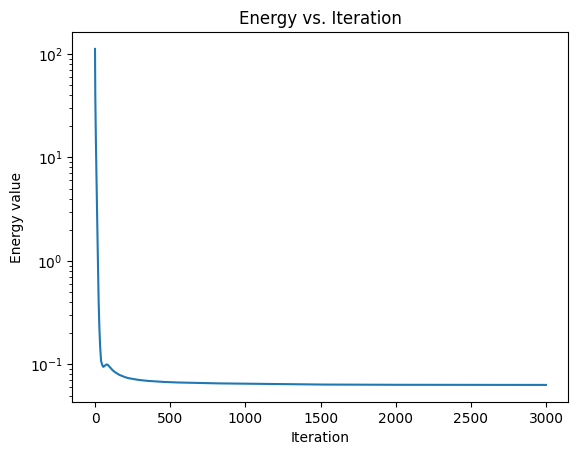

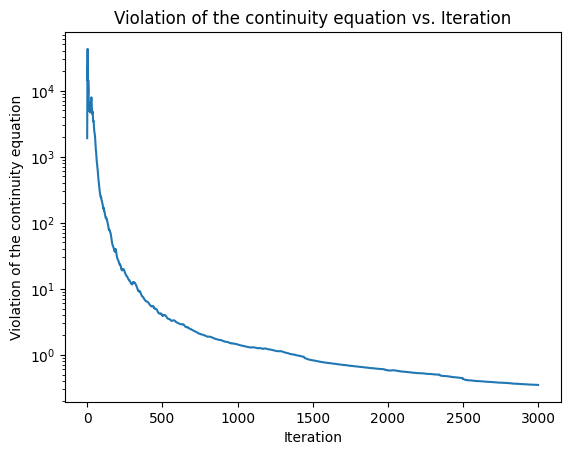

In [9]:
plt.semilogy(lists[0])
plt.xlabel("Iteration")
plt.ylabel("Energy value")
plt.title("Energy vs. Iteration")
plt.show()

plt.semilogy(lists[1])
plt.xlabel("Iteration")
plt.ylabel("Violation of the continuity equation")
plt.title("Violation of the continuity equation vs. Iteration")
plt.show()

# Heat map at each time

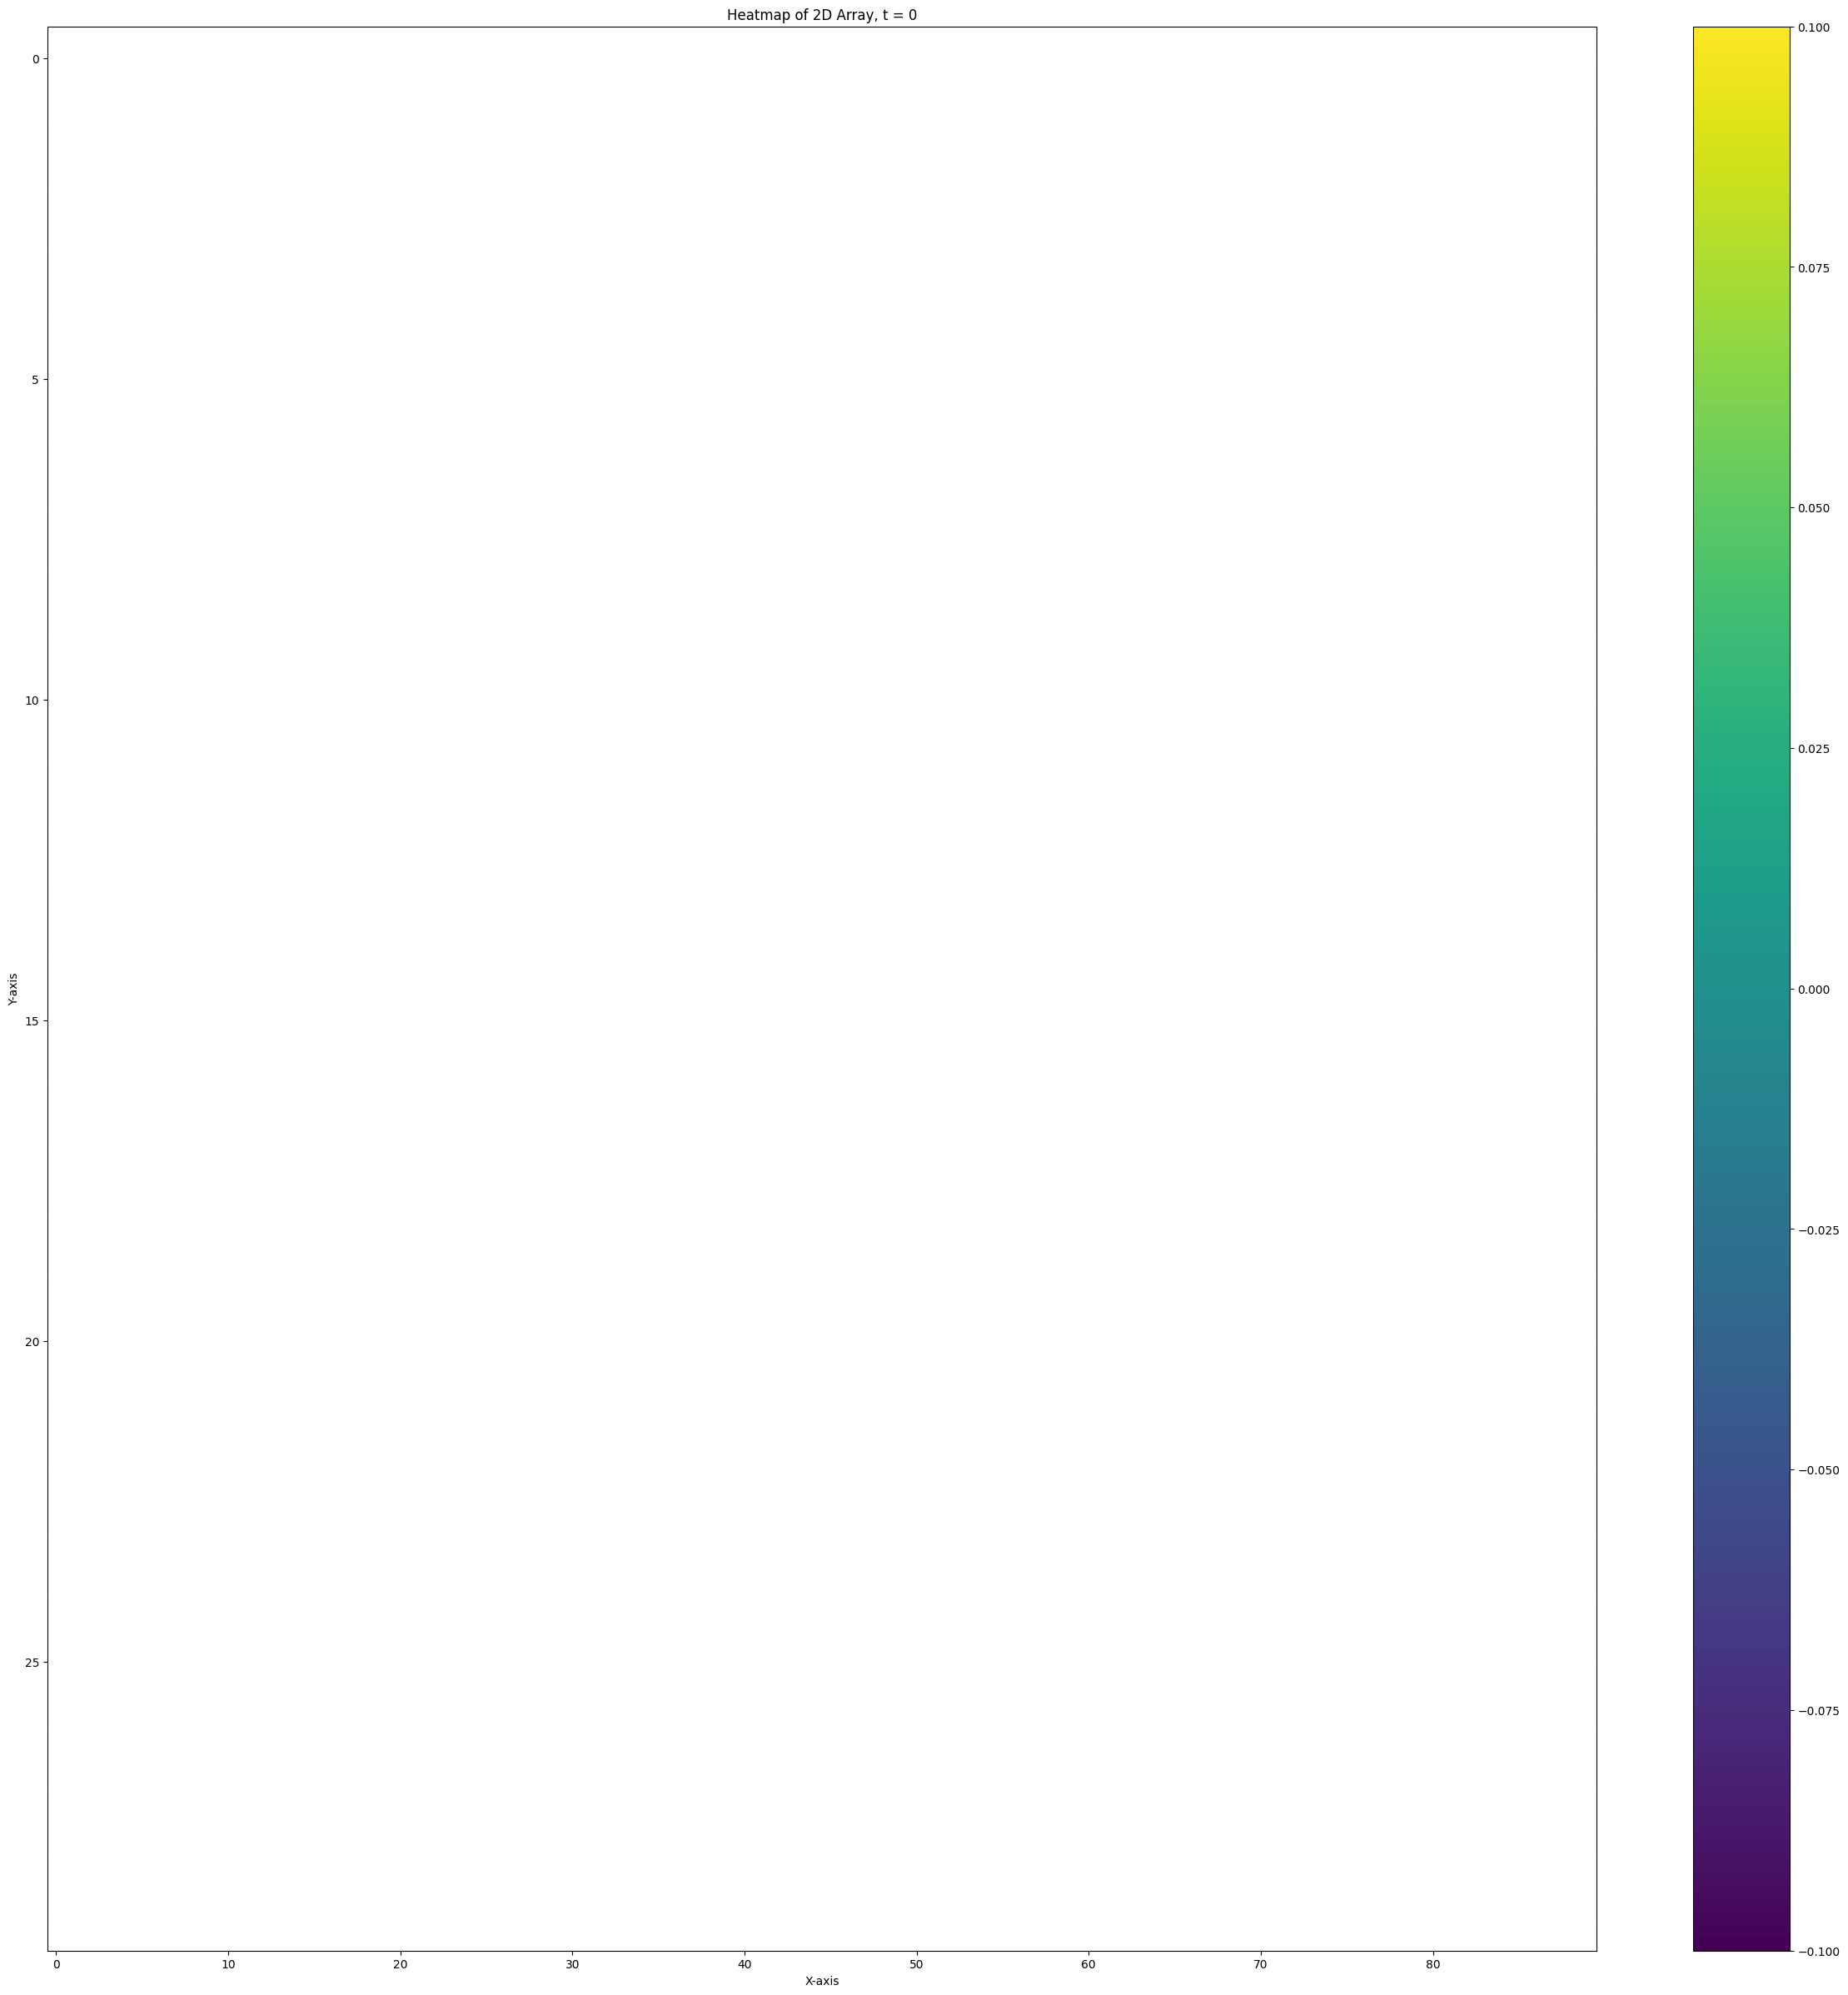

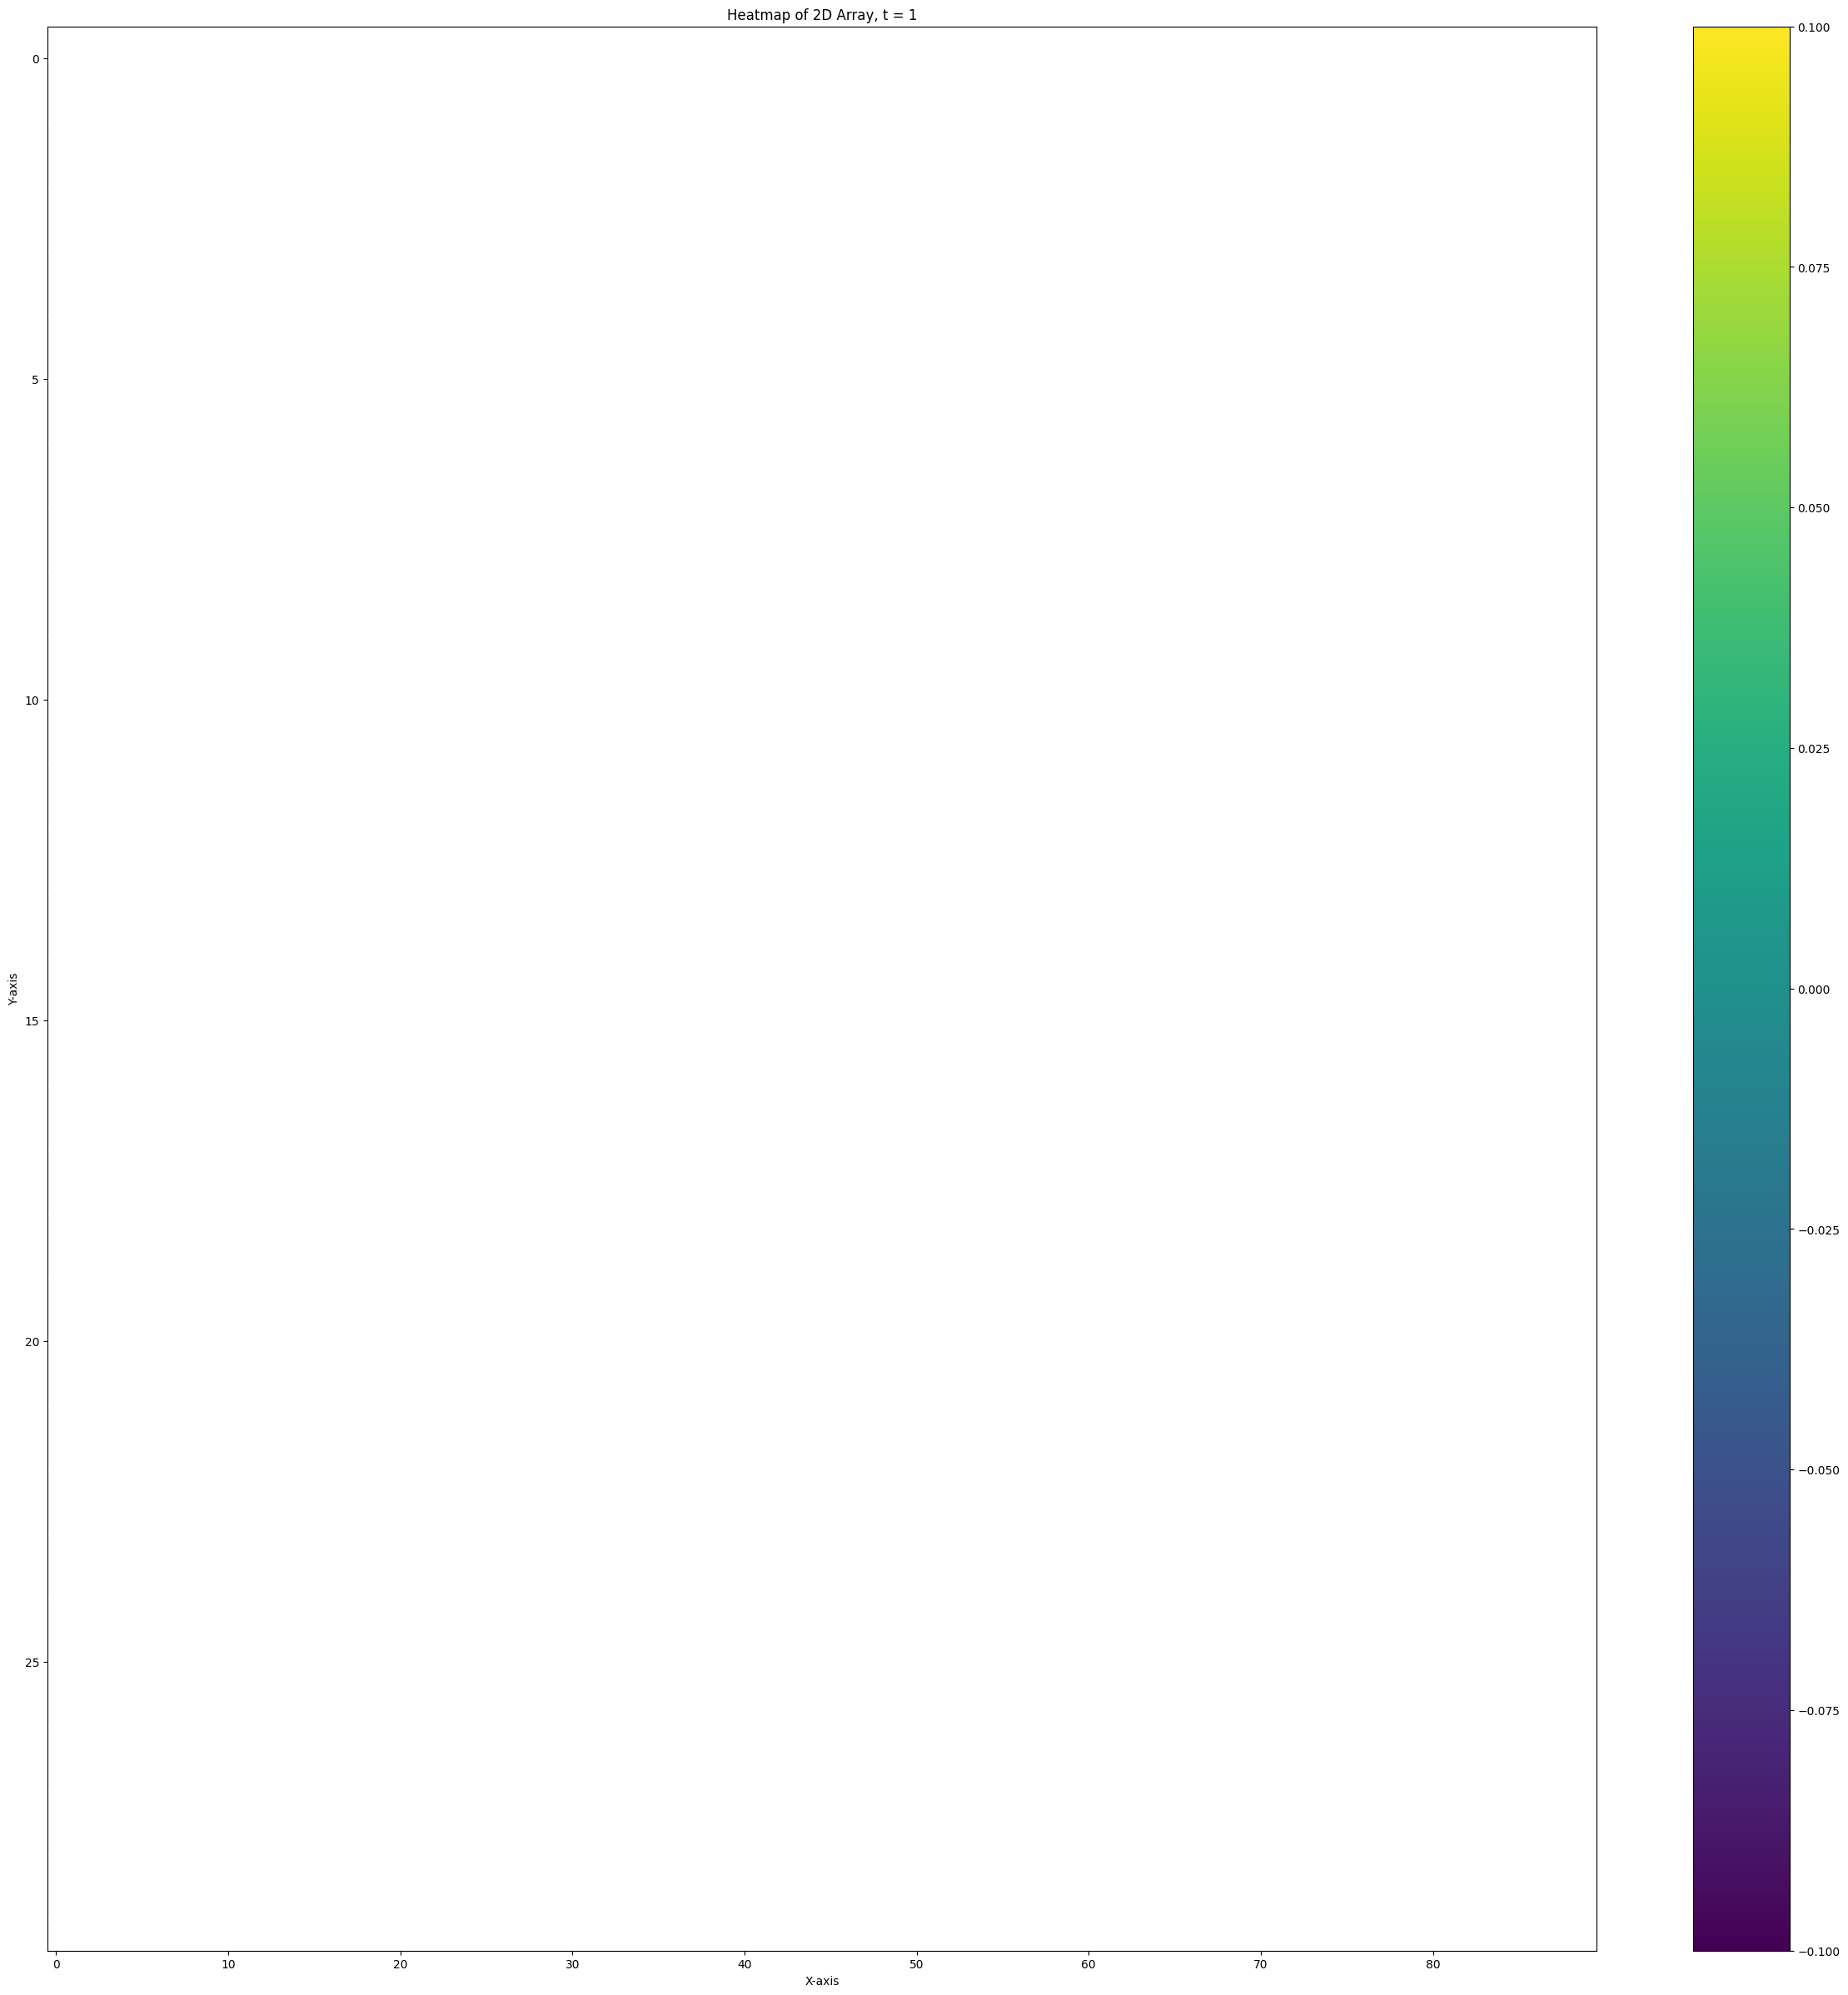

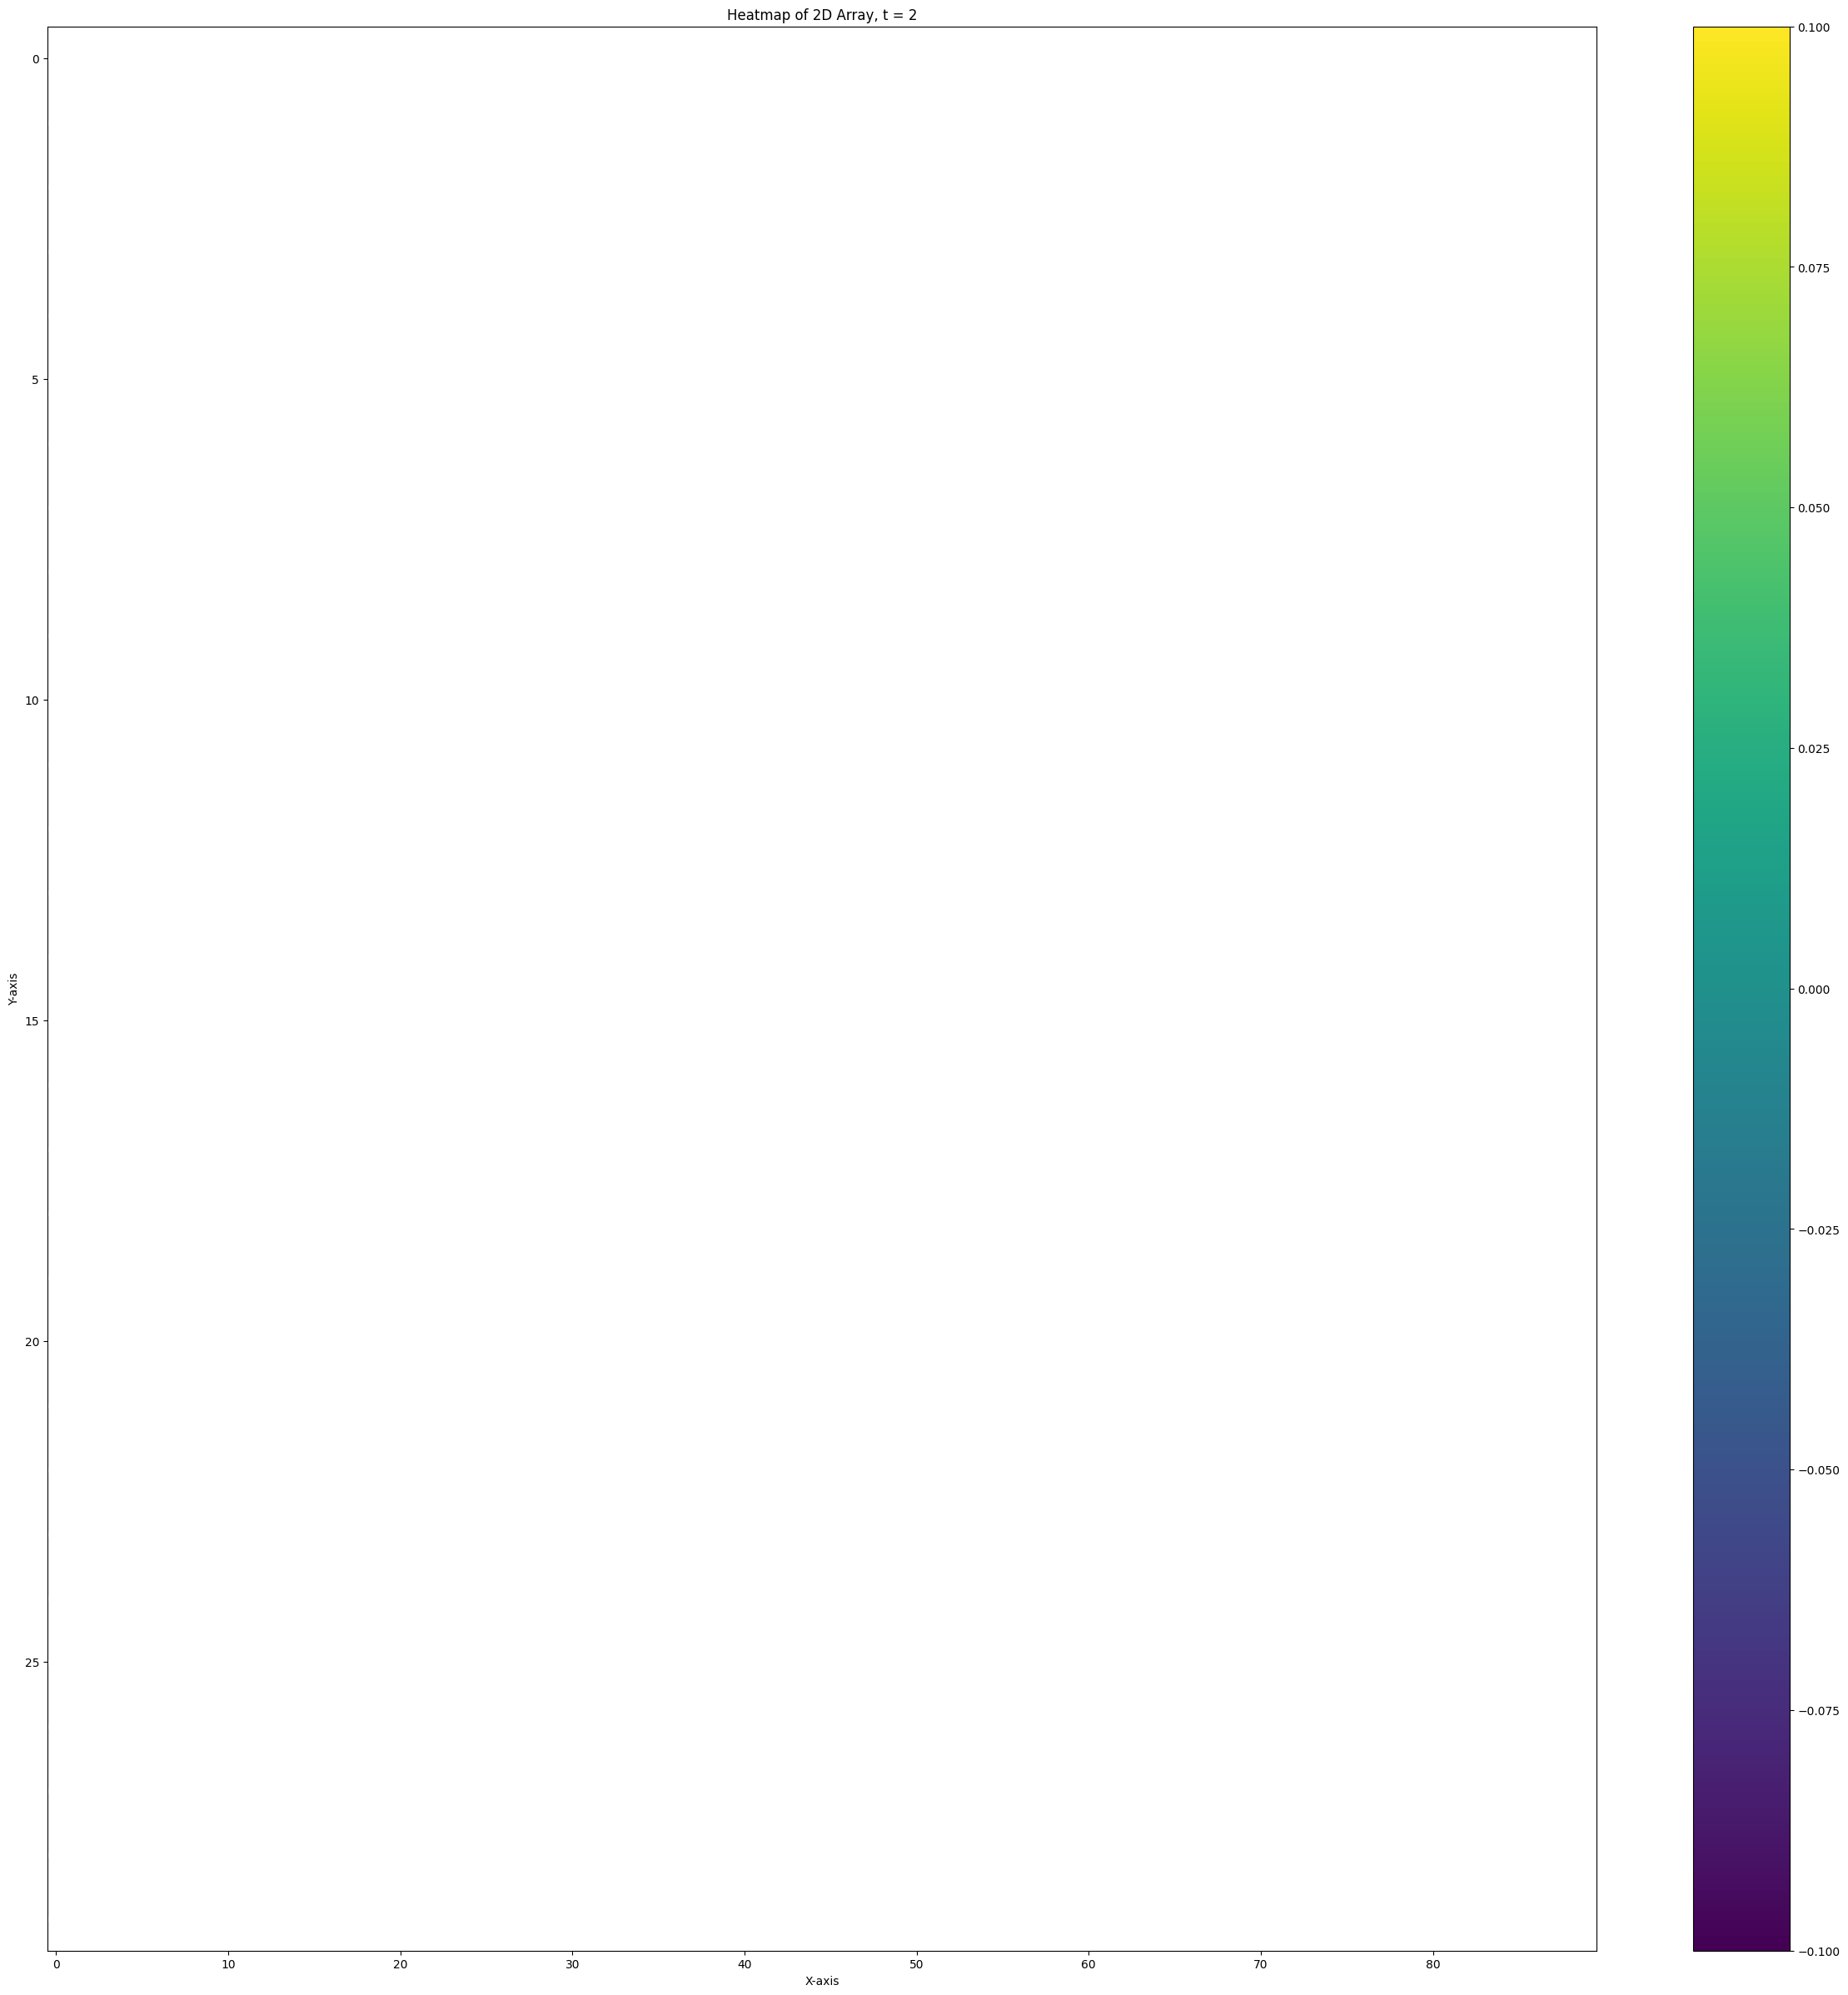

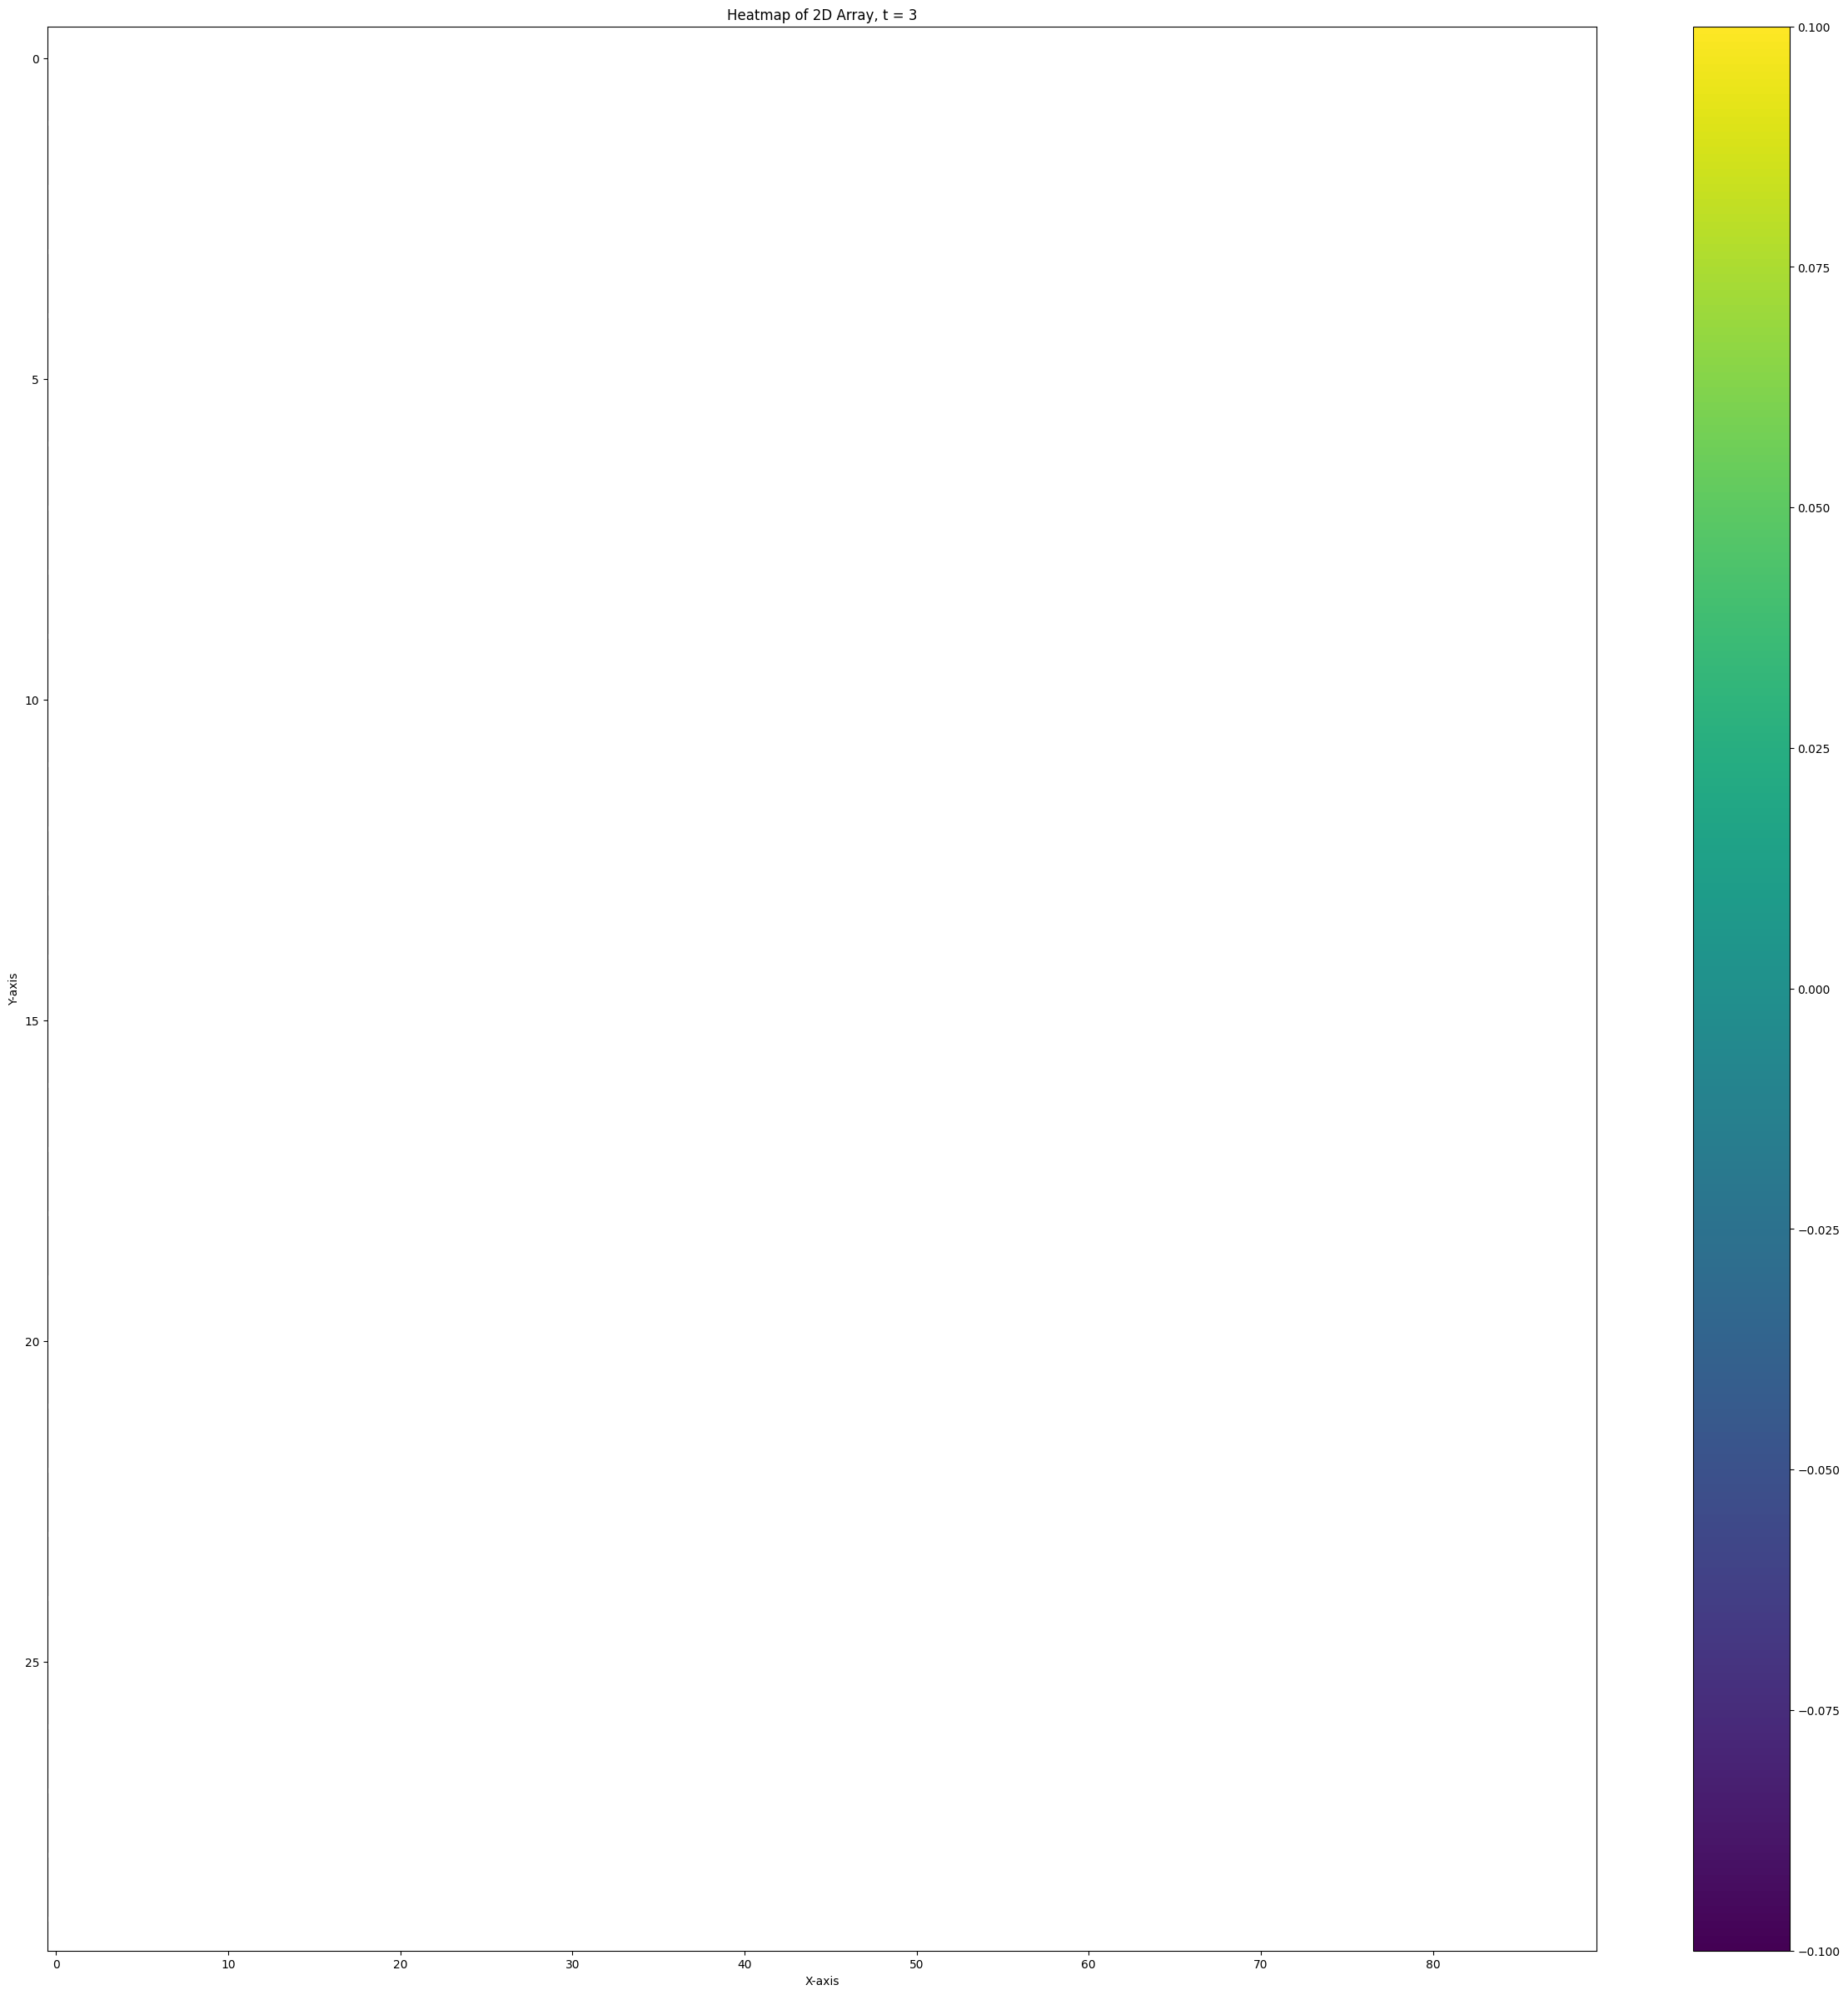

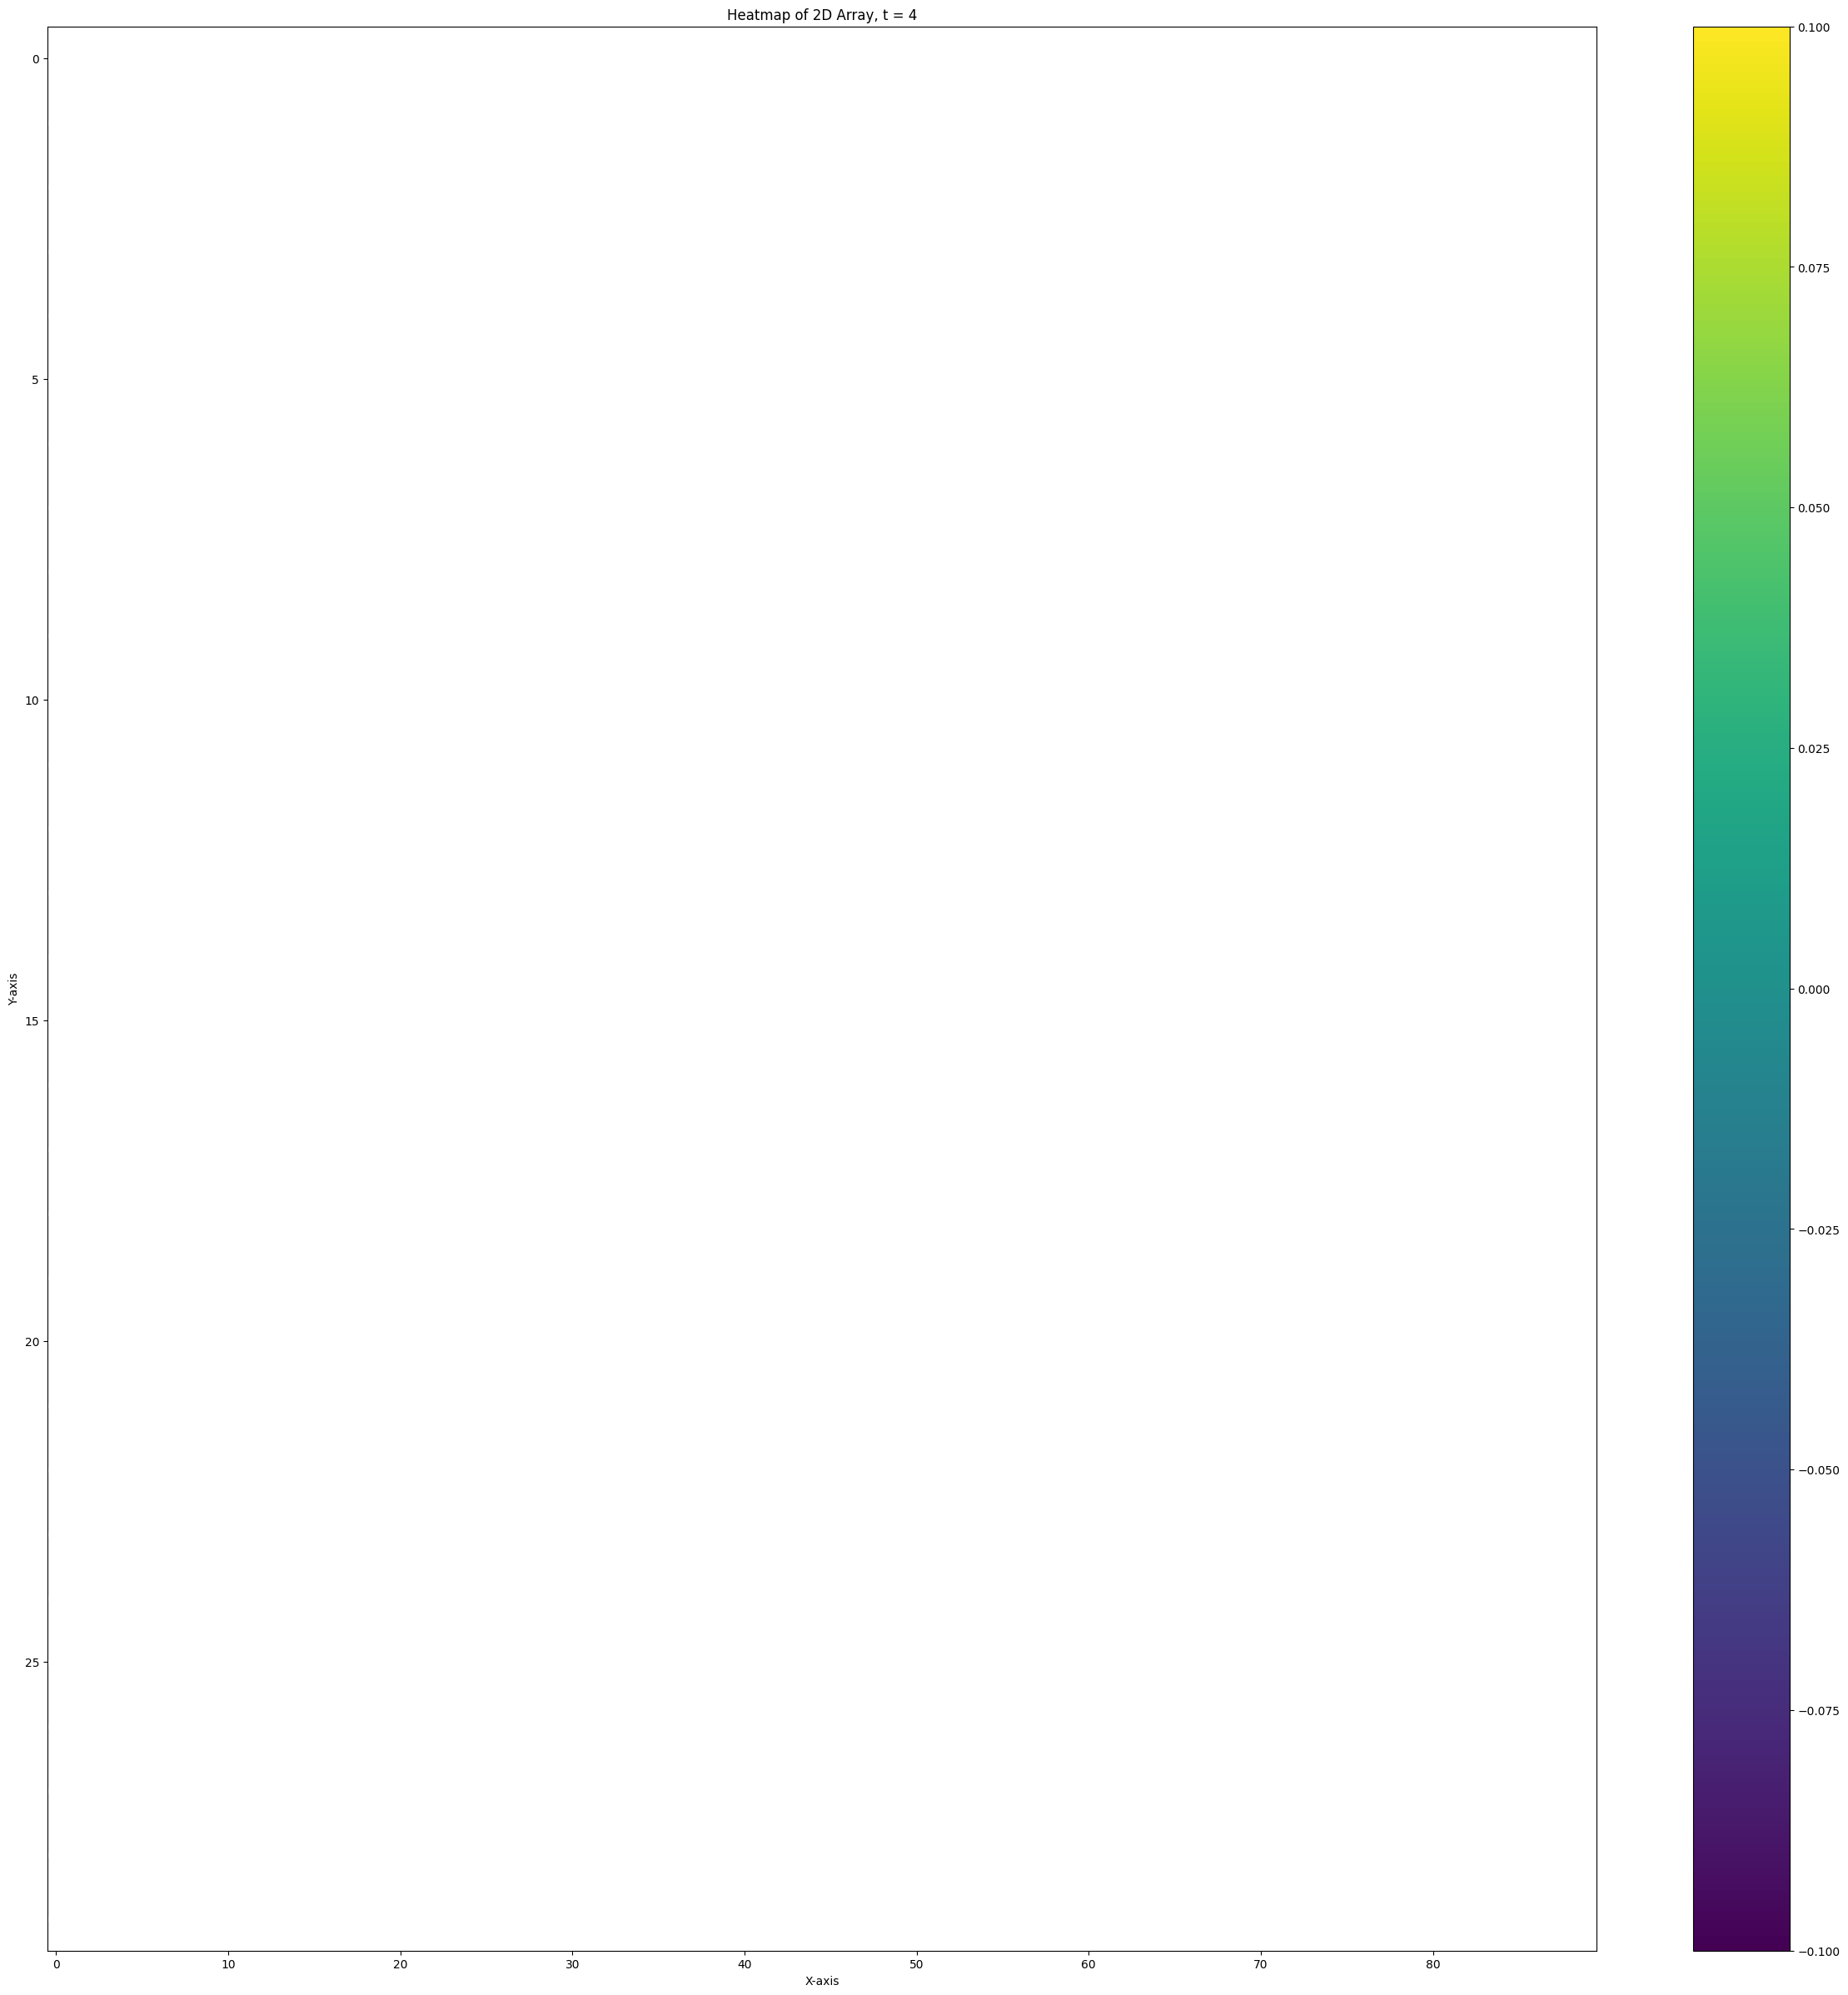

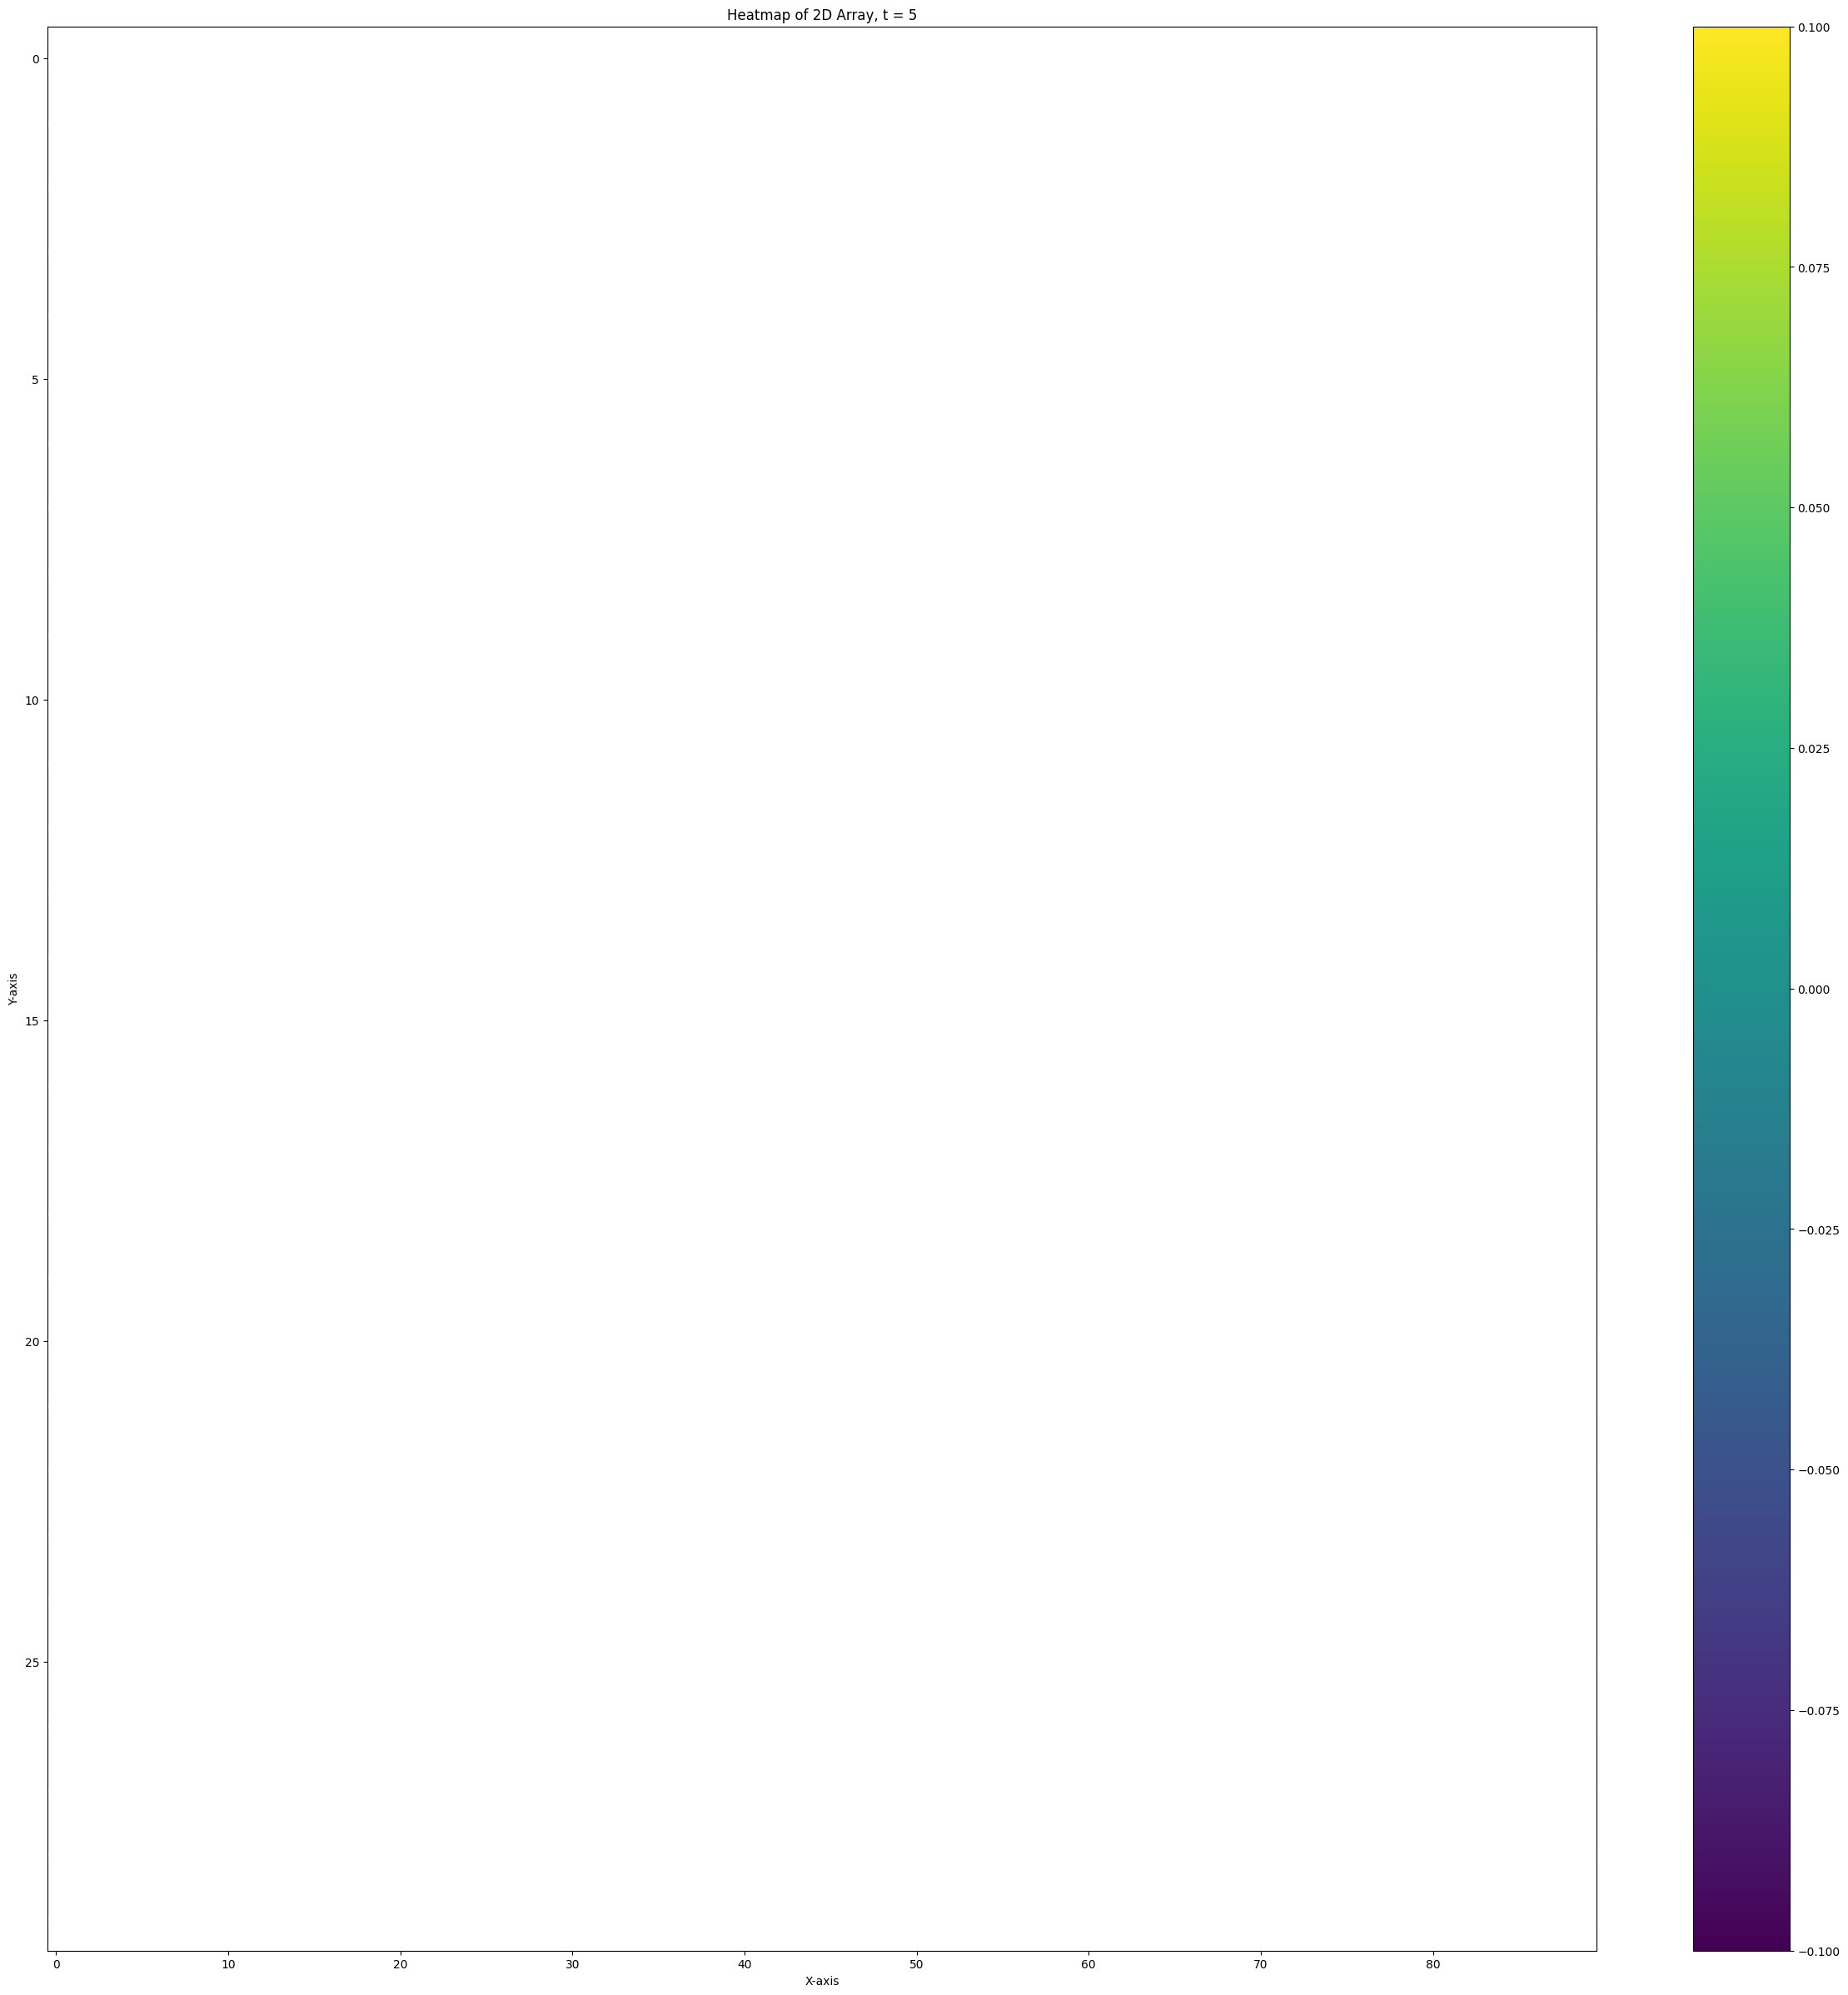

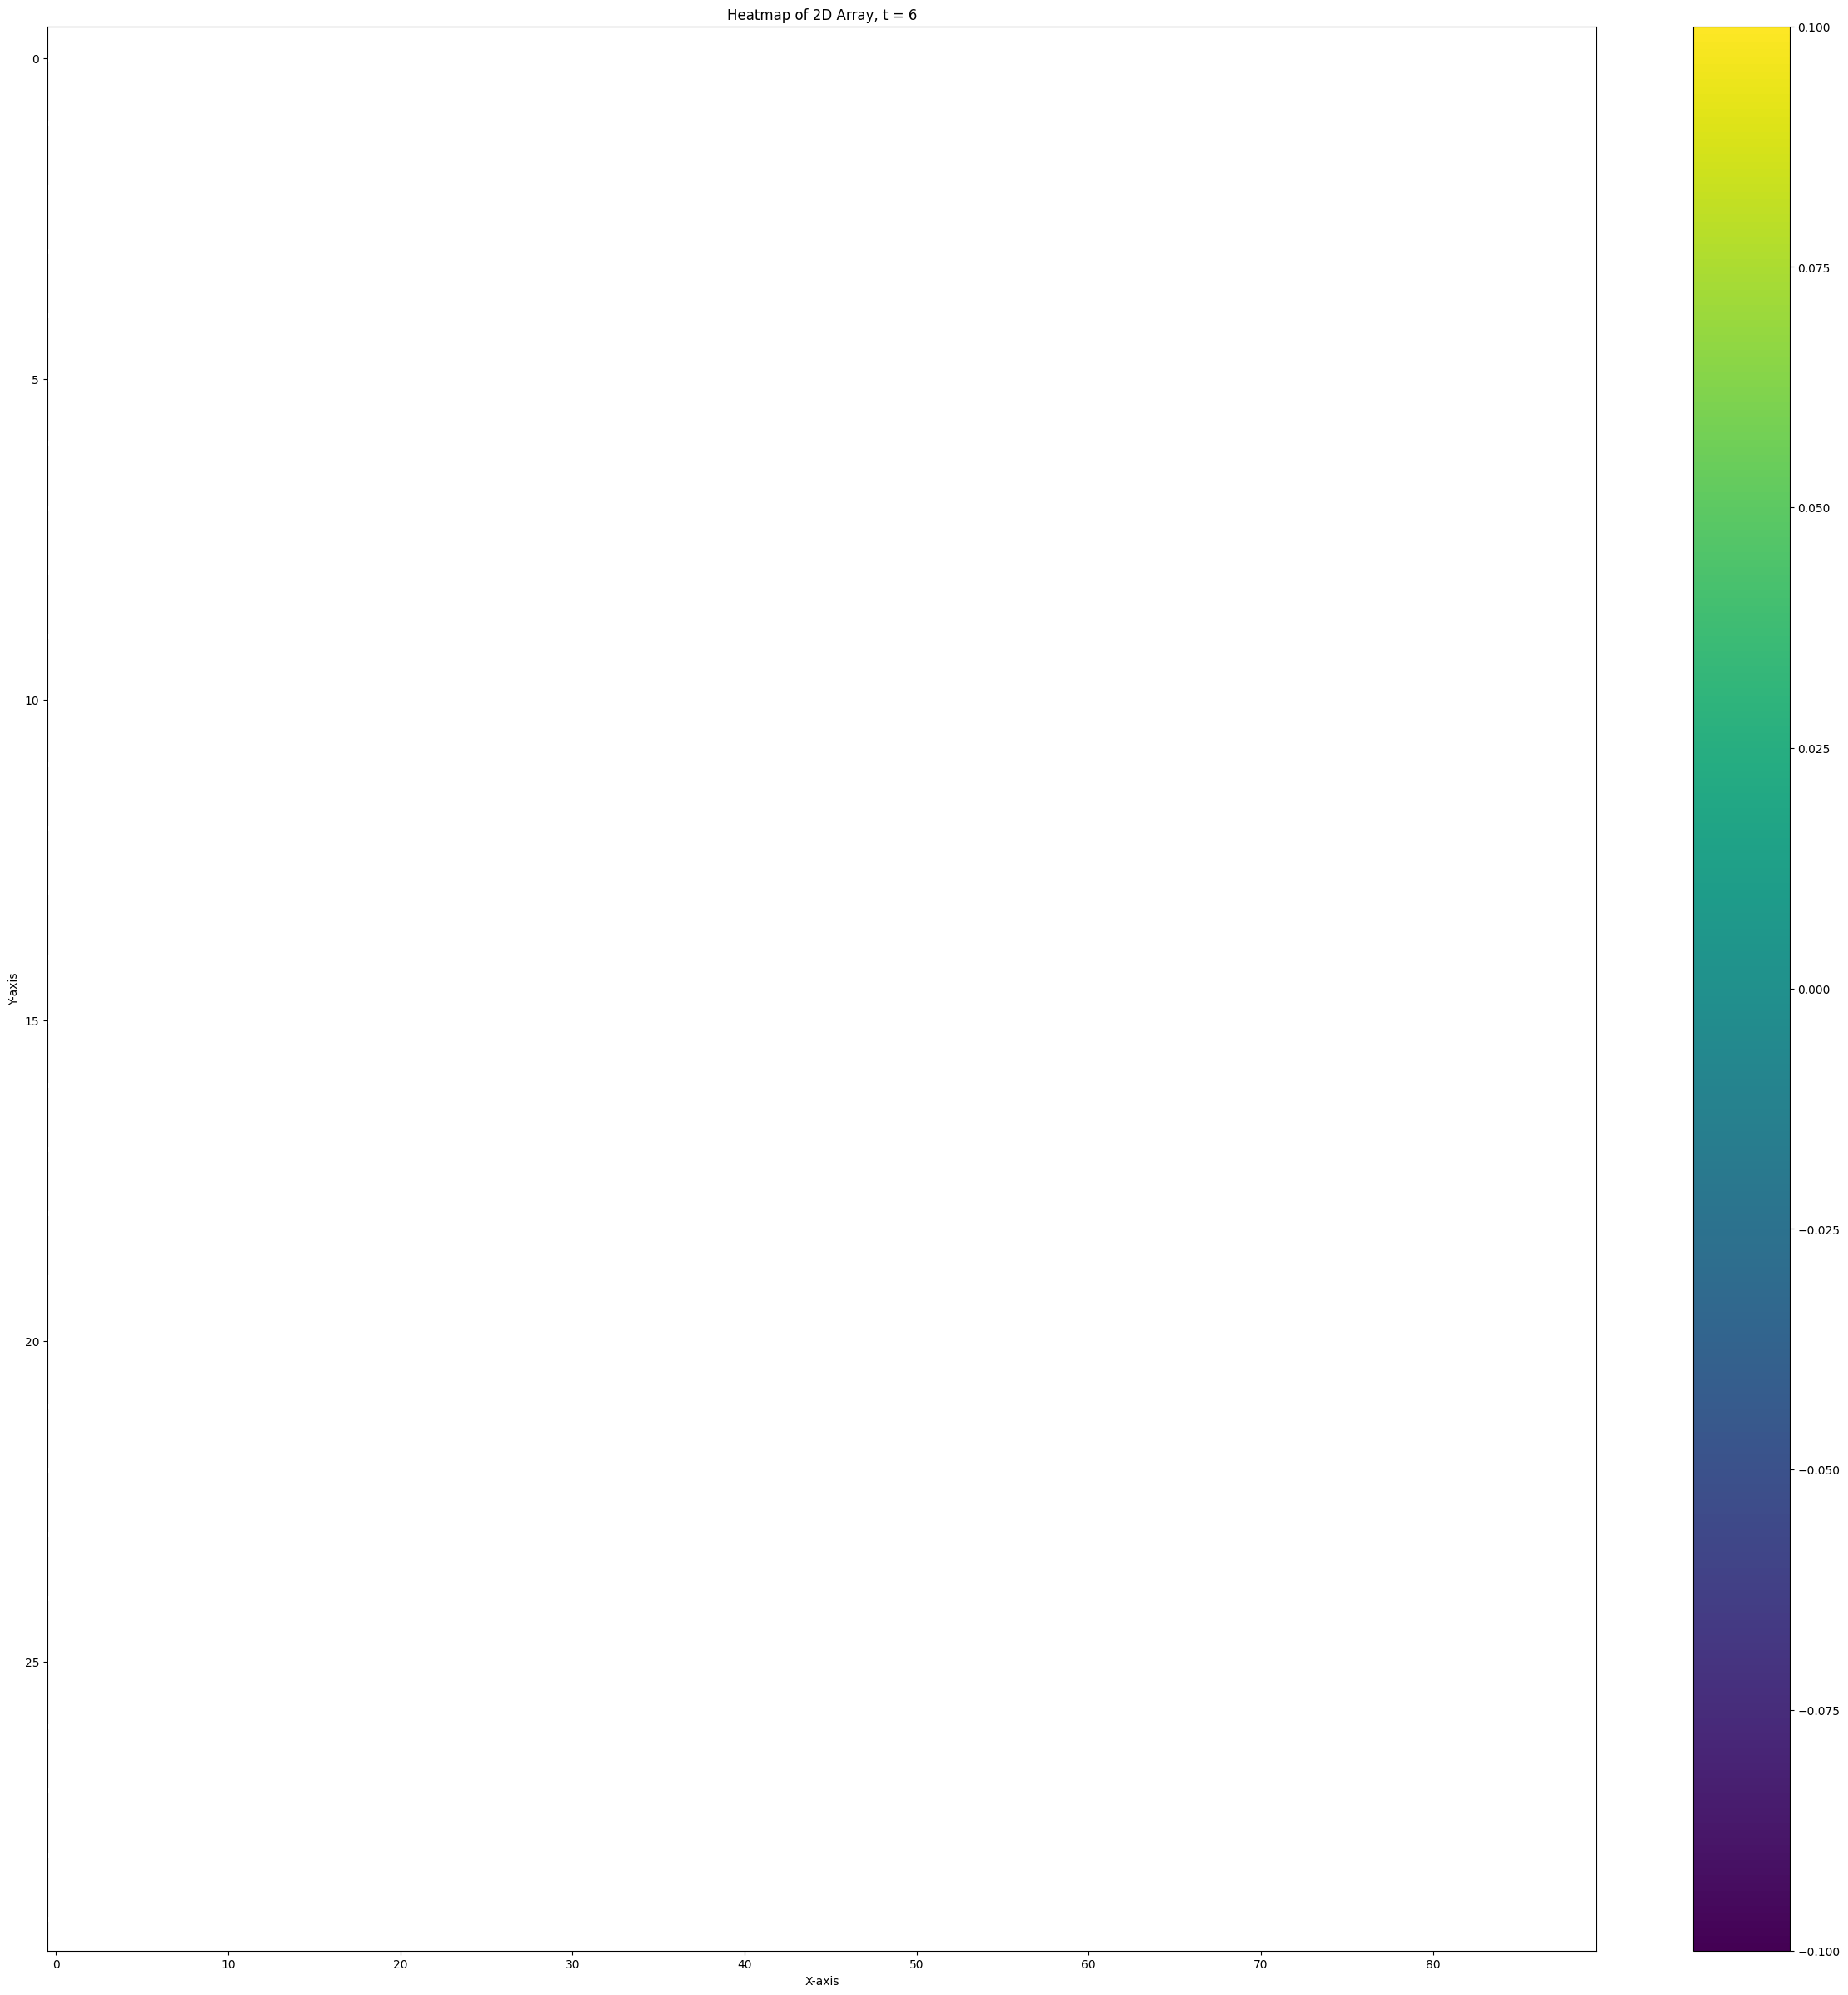

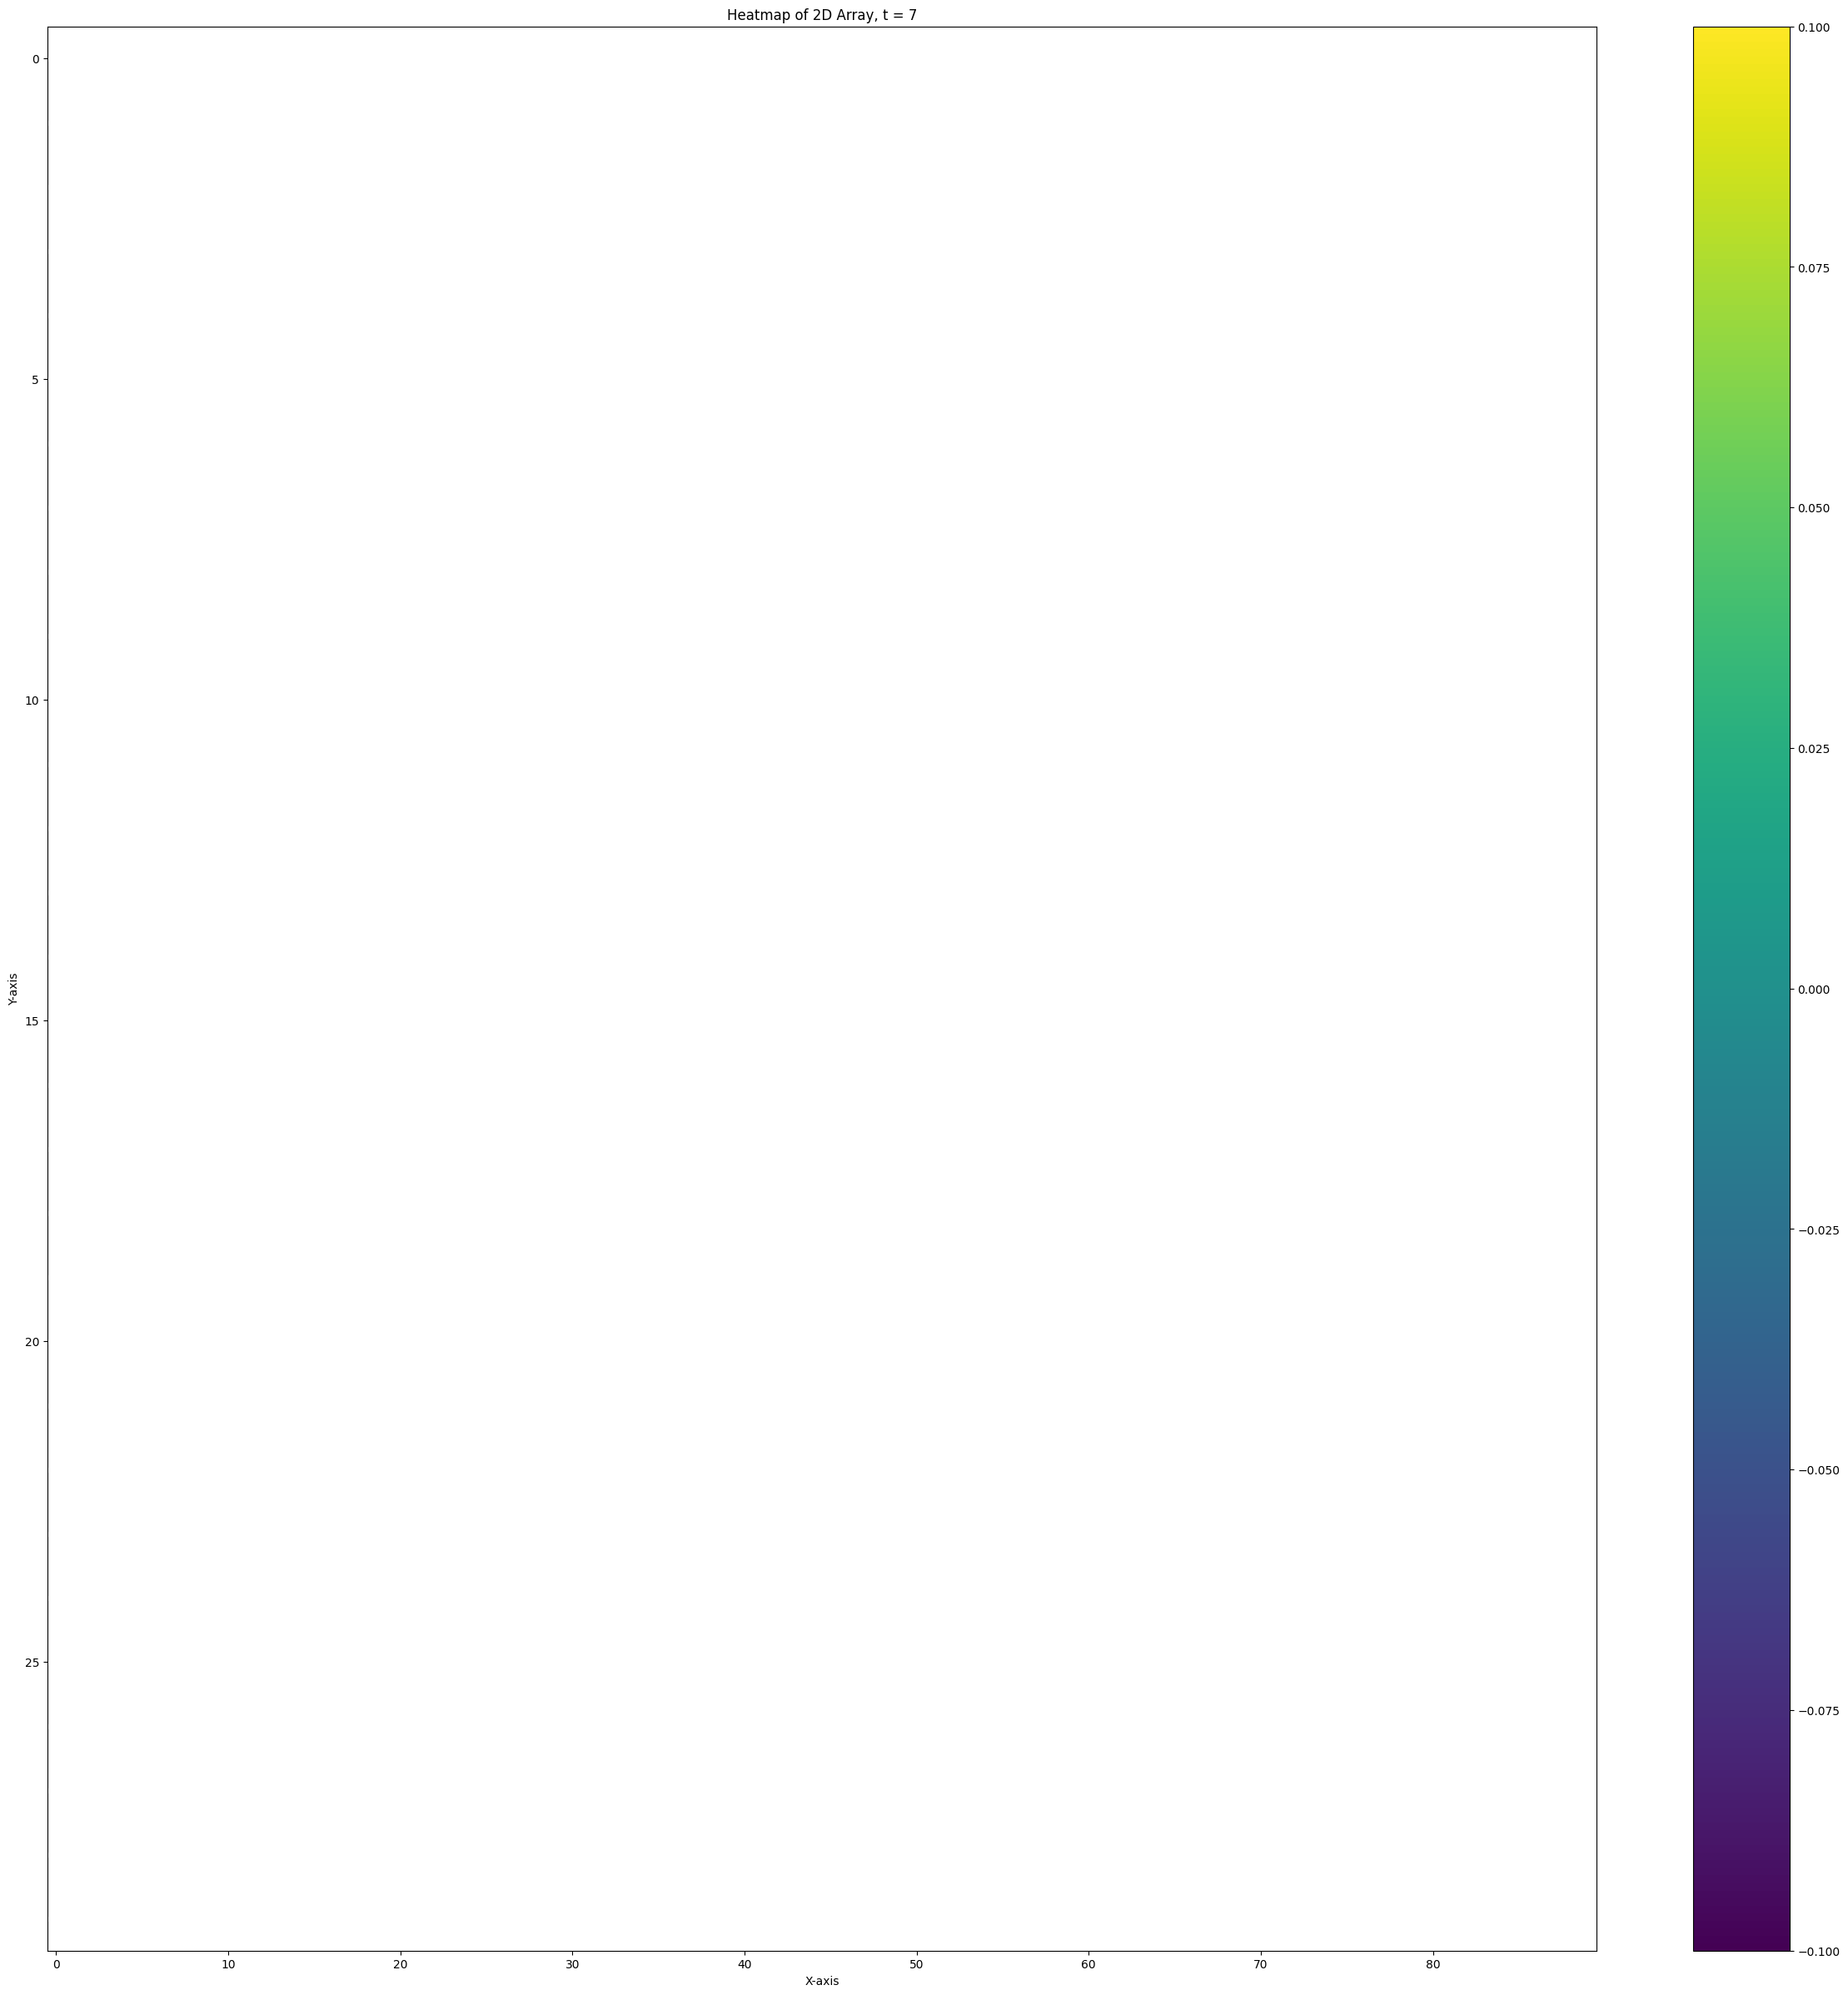

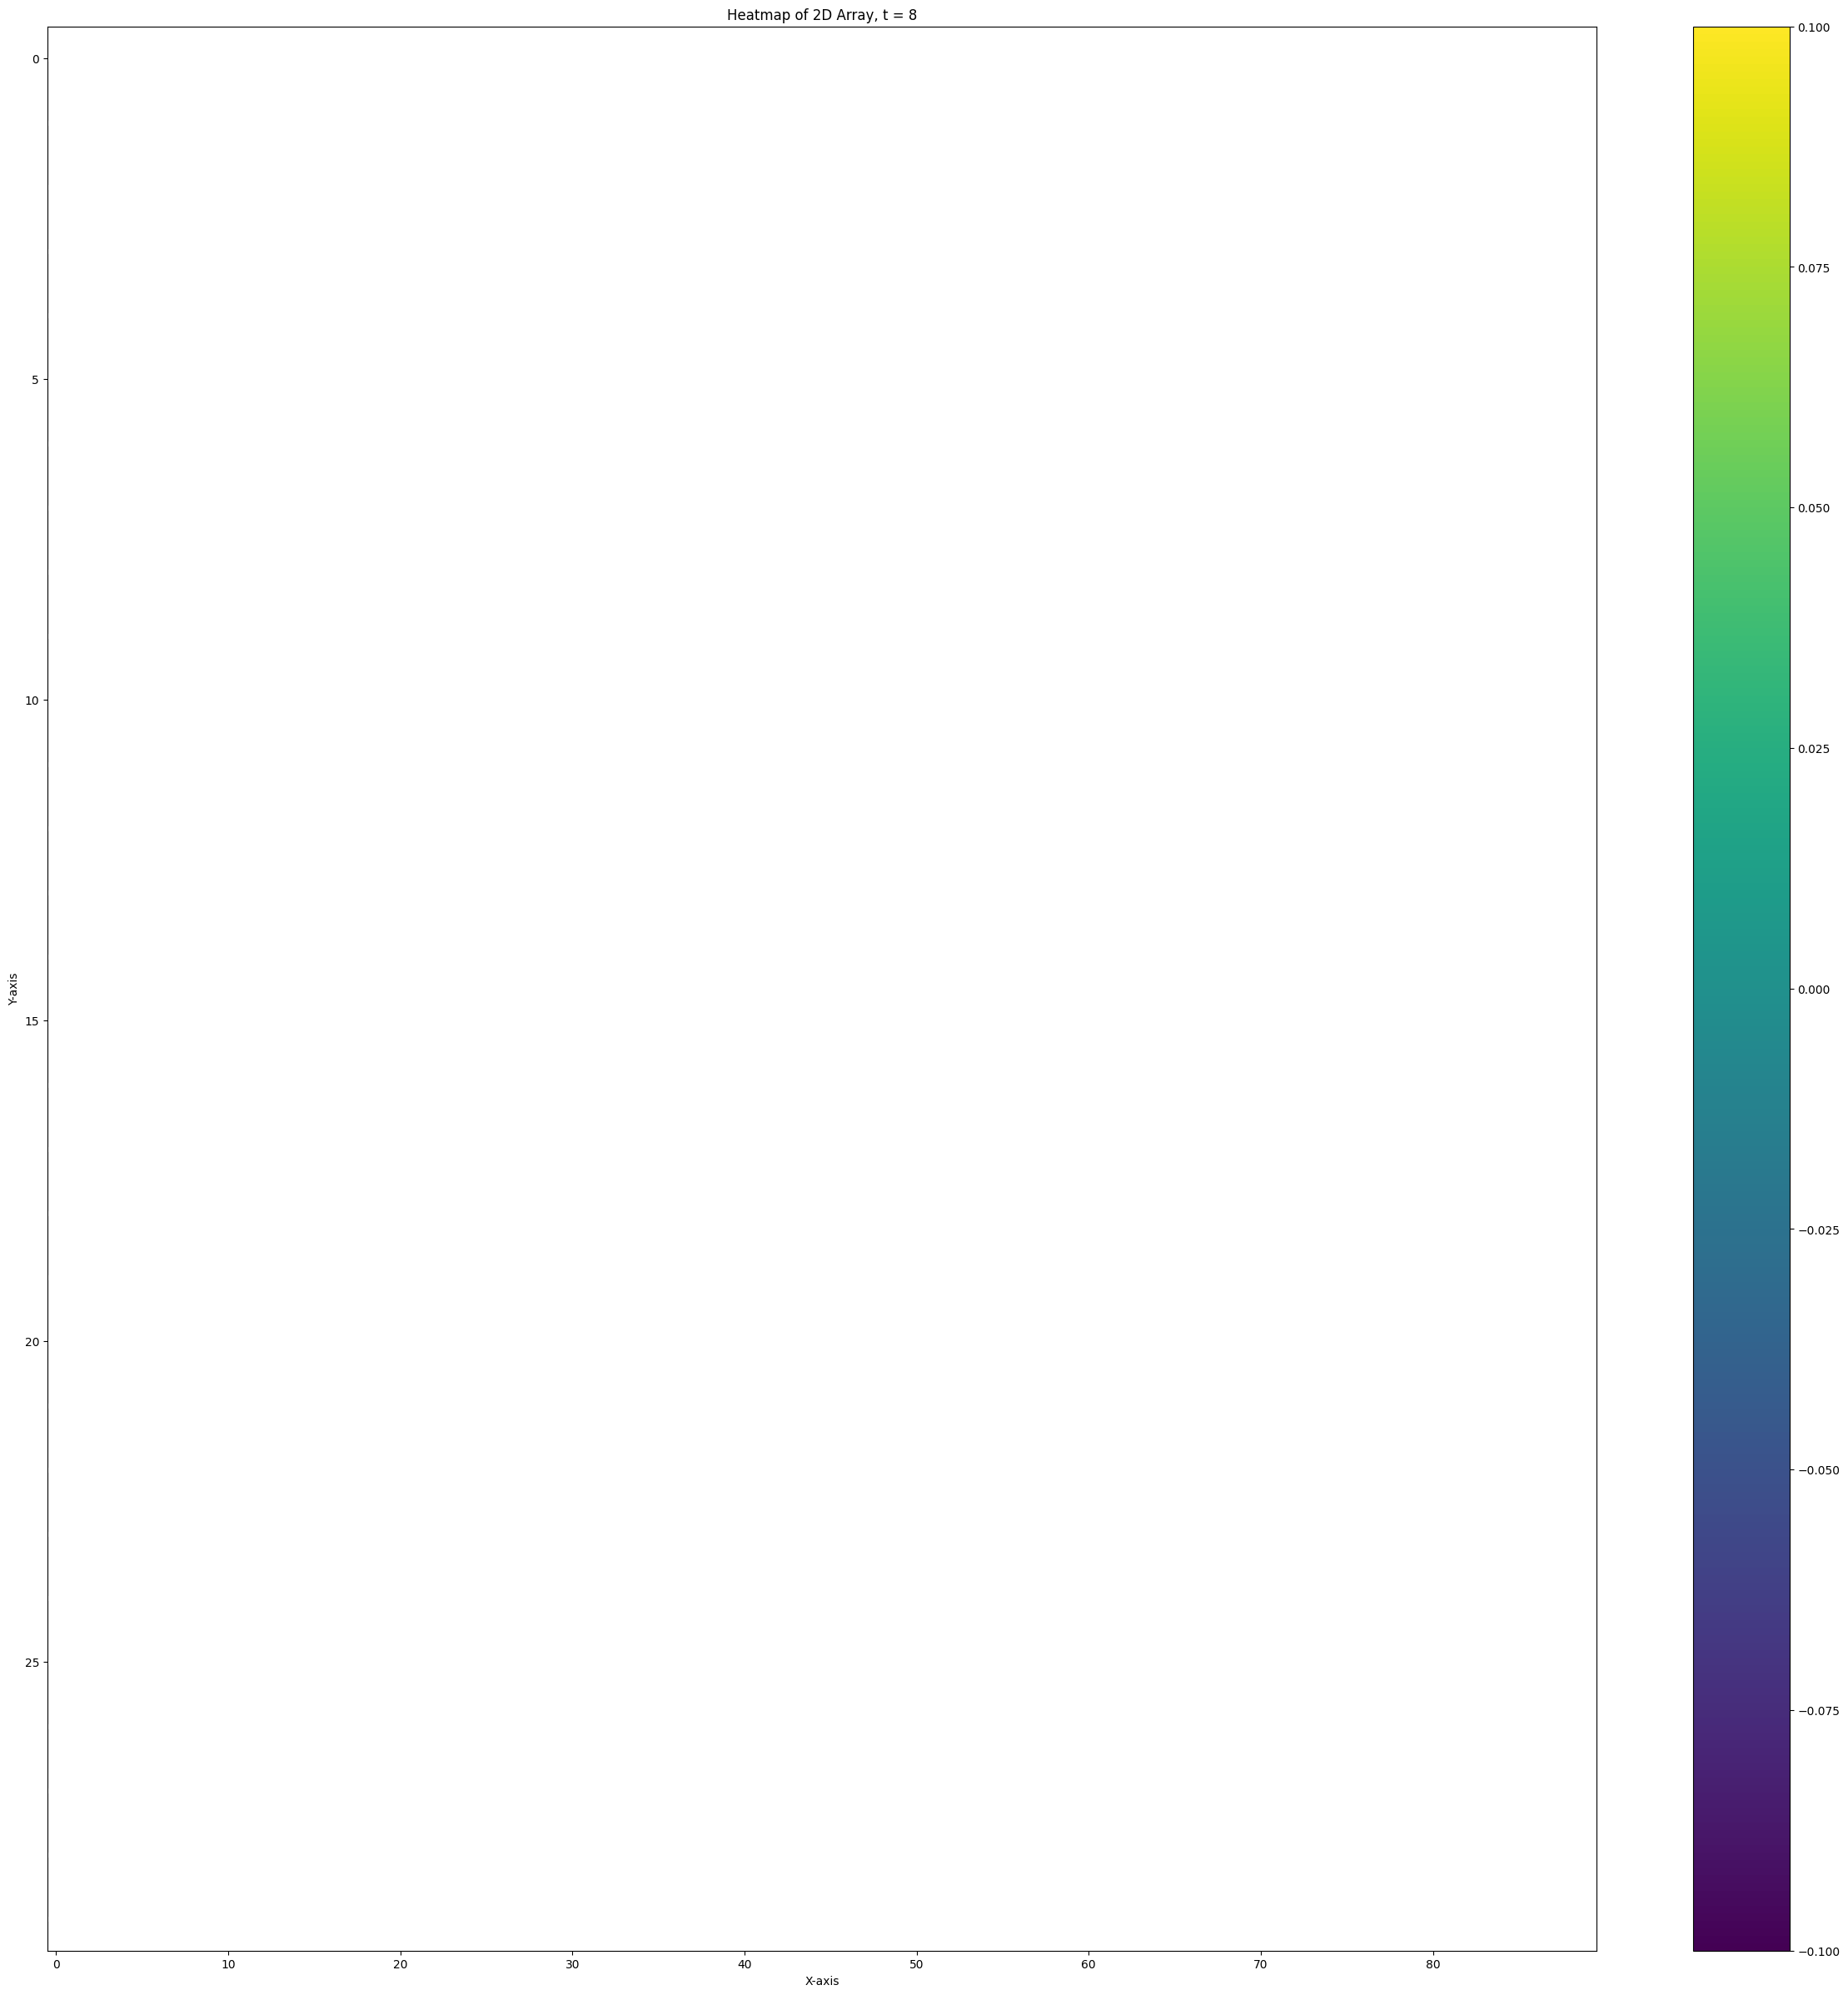

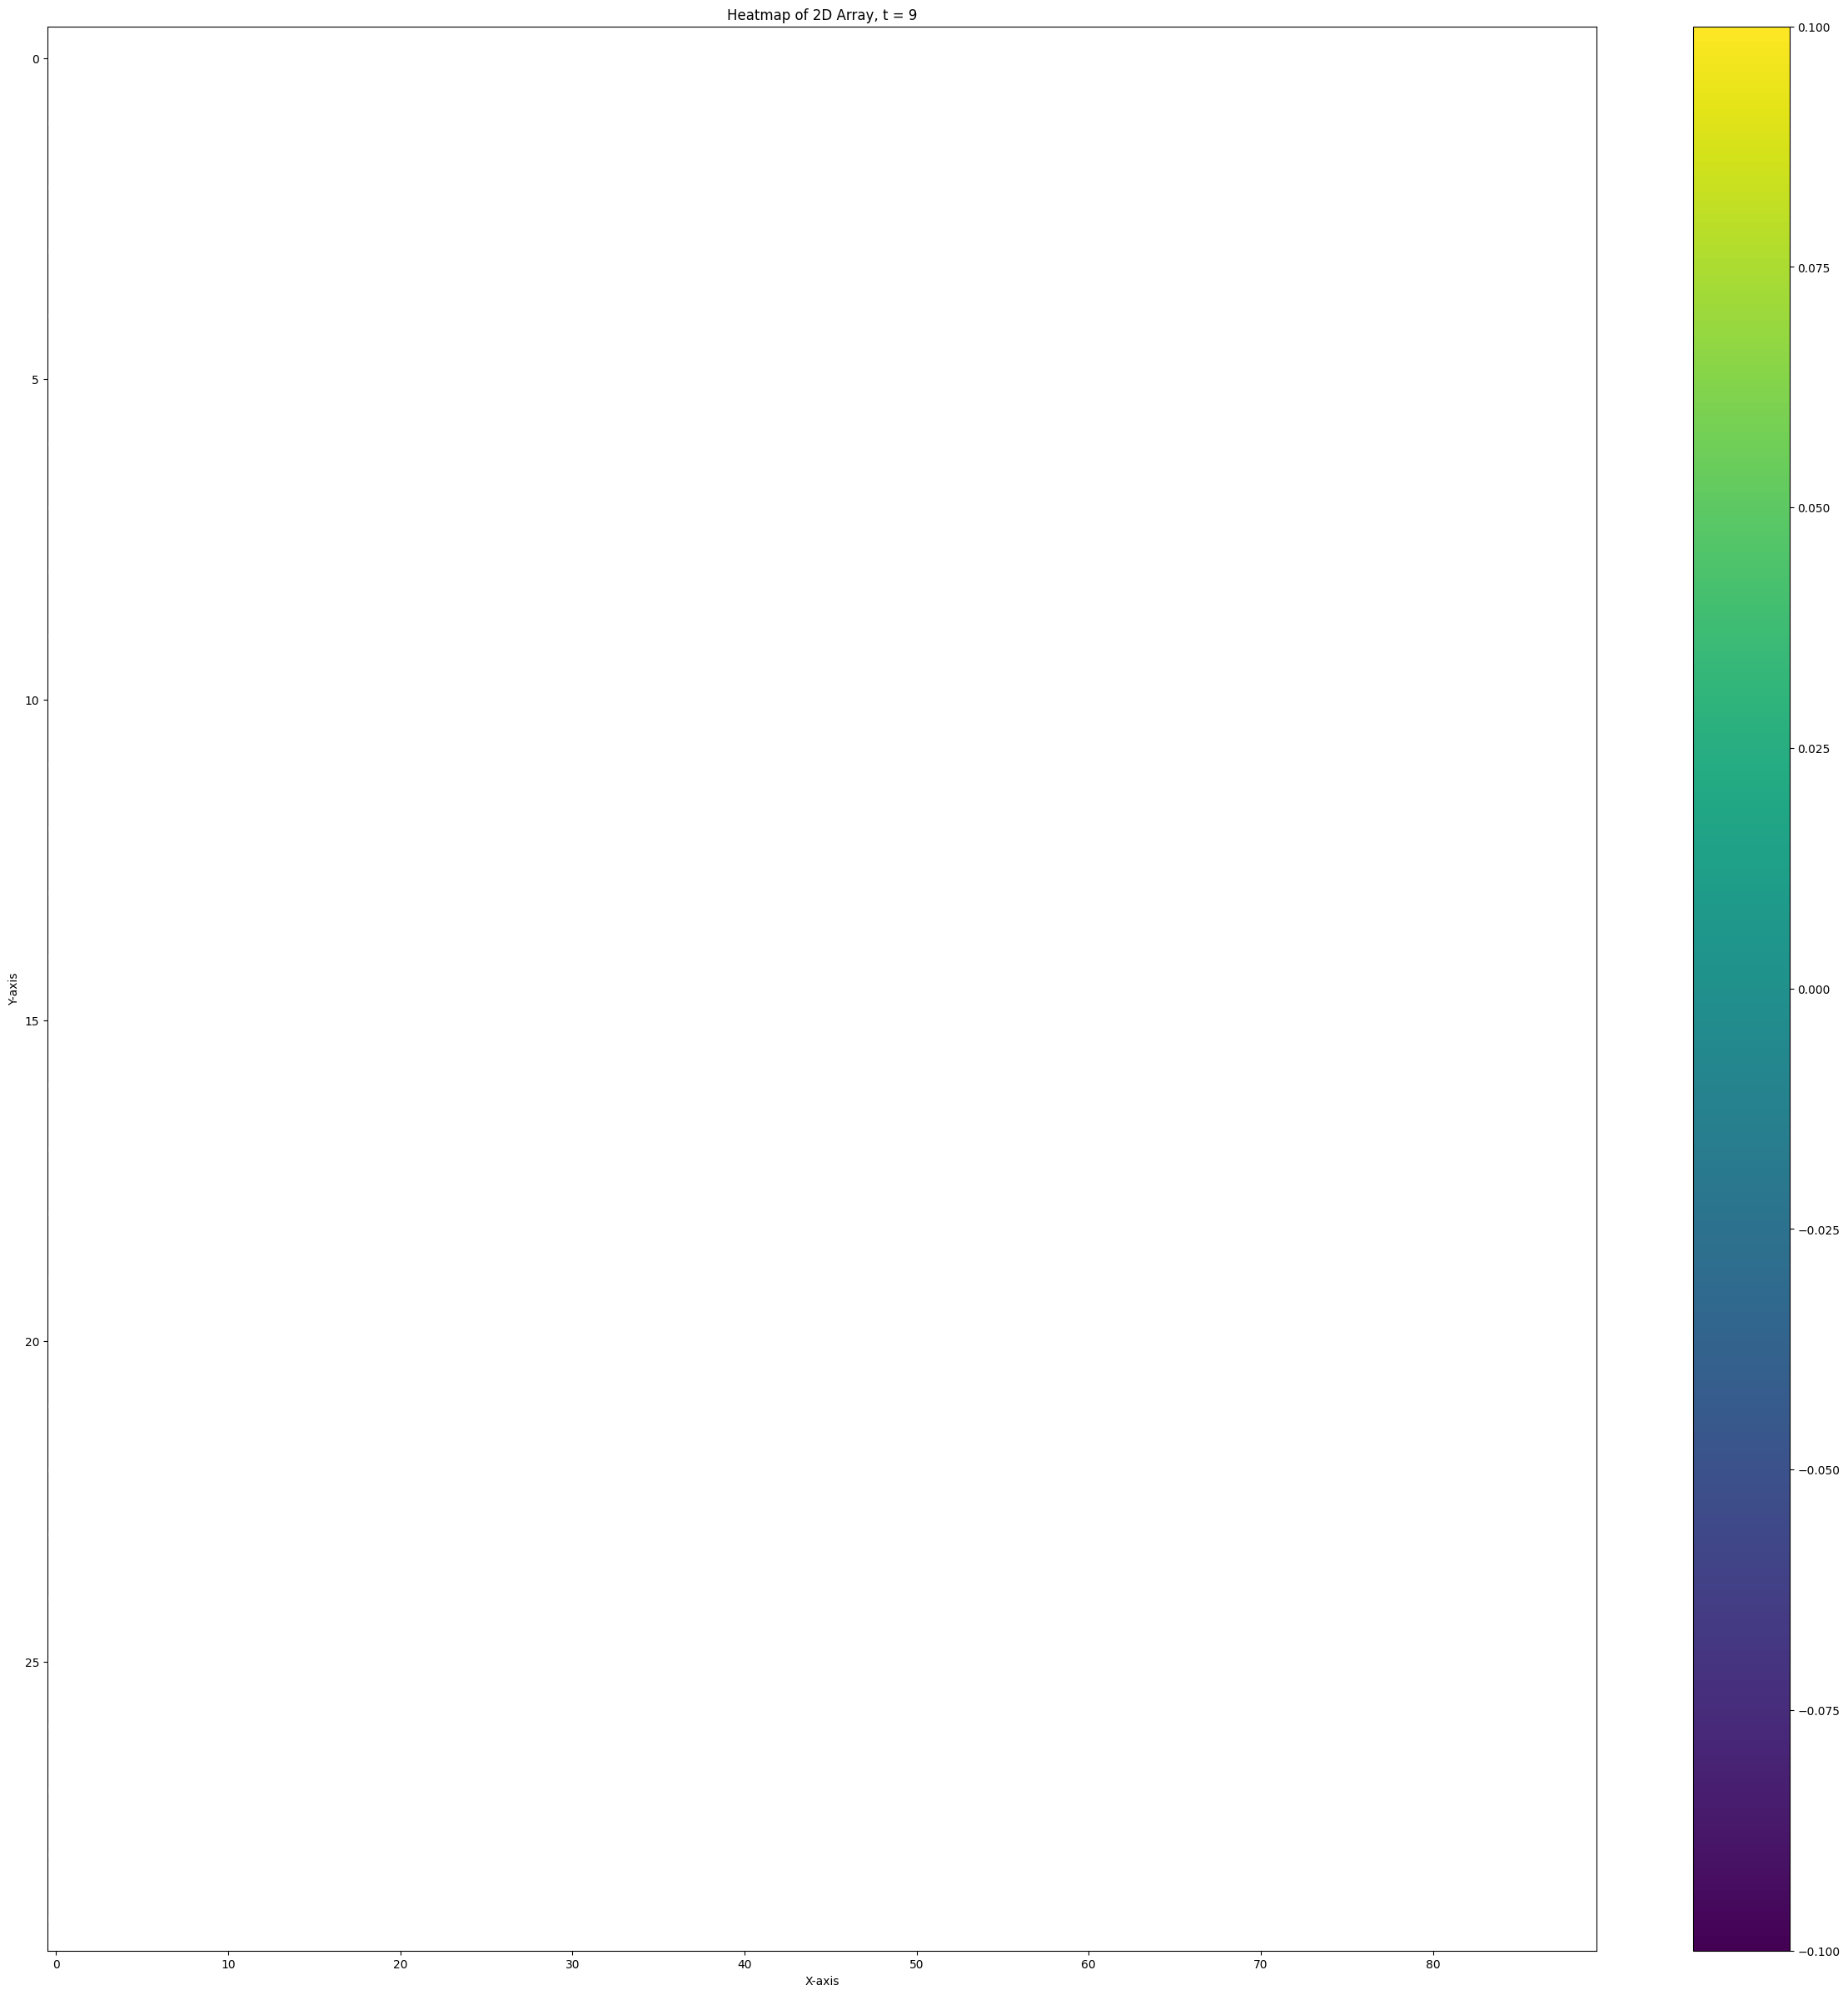

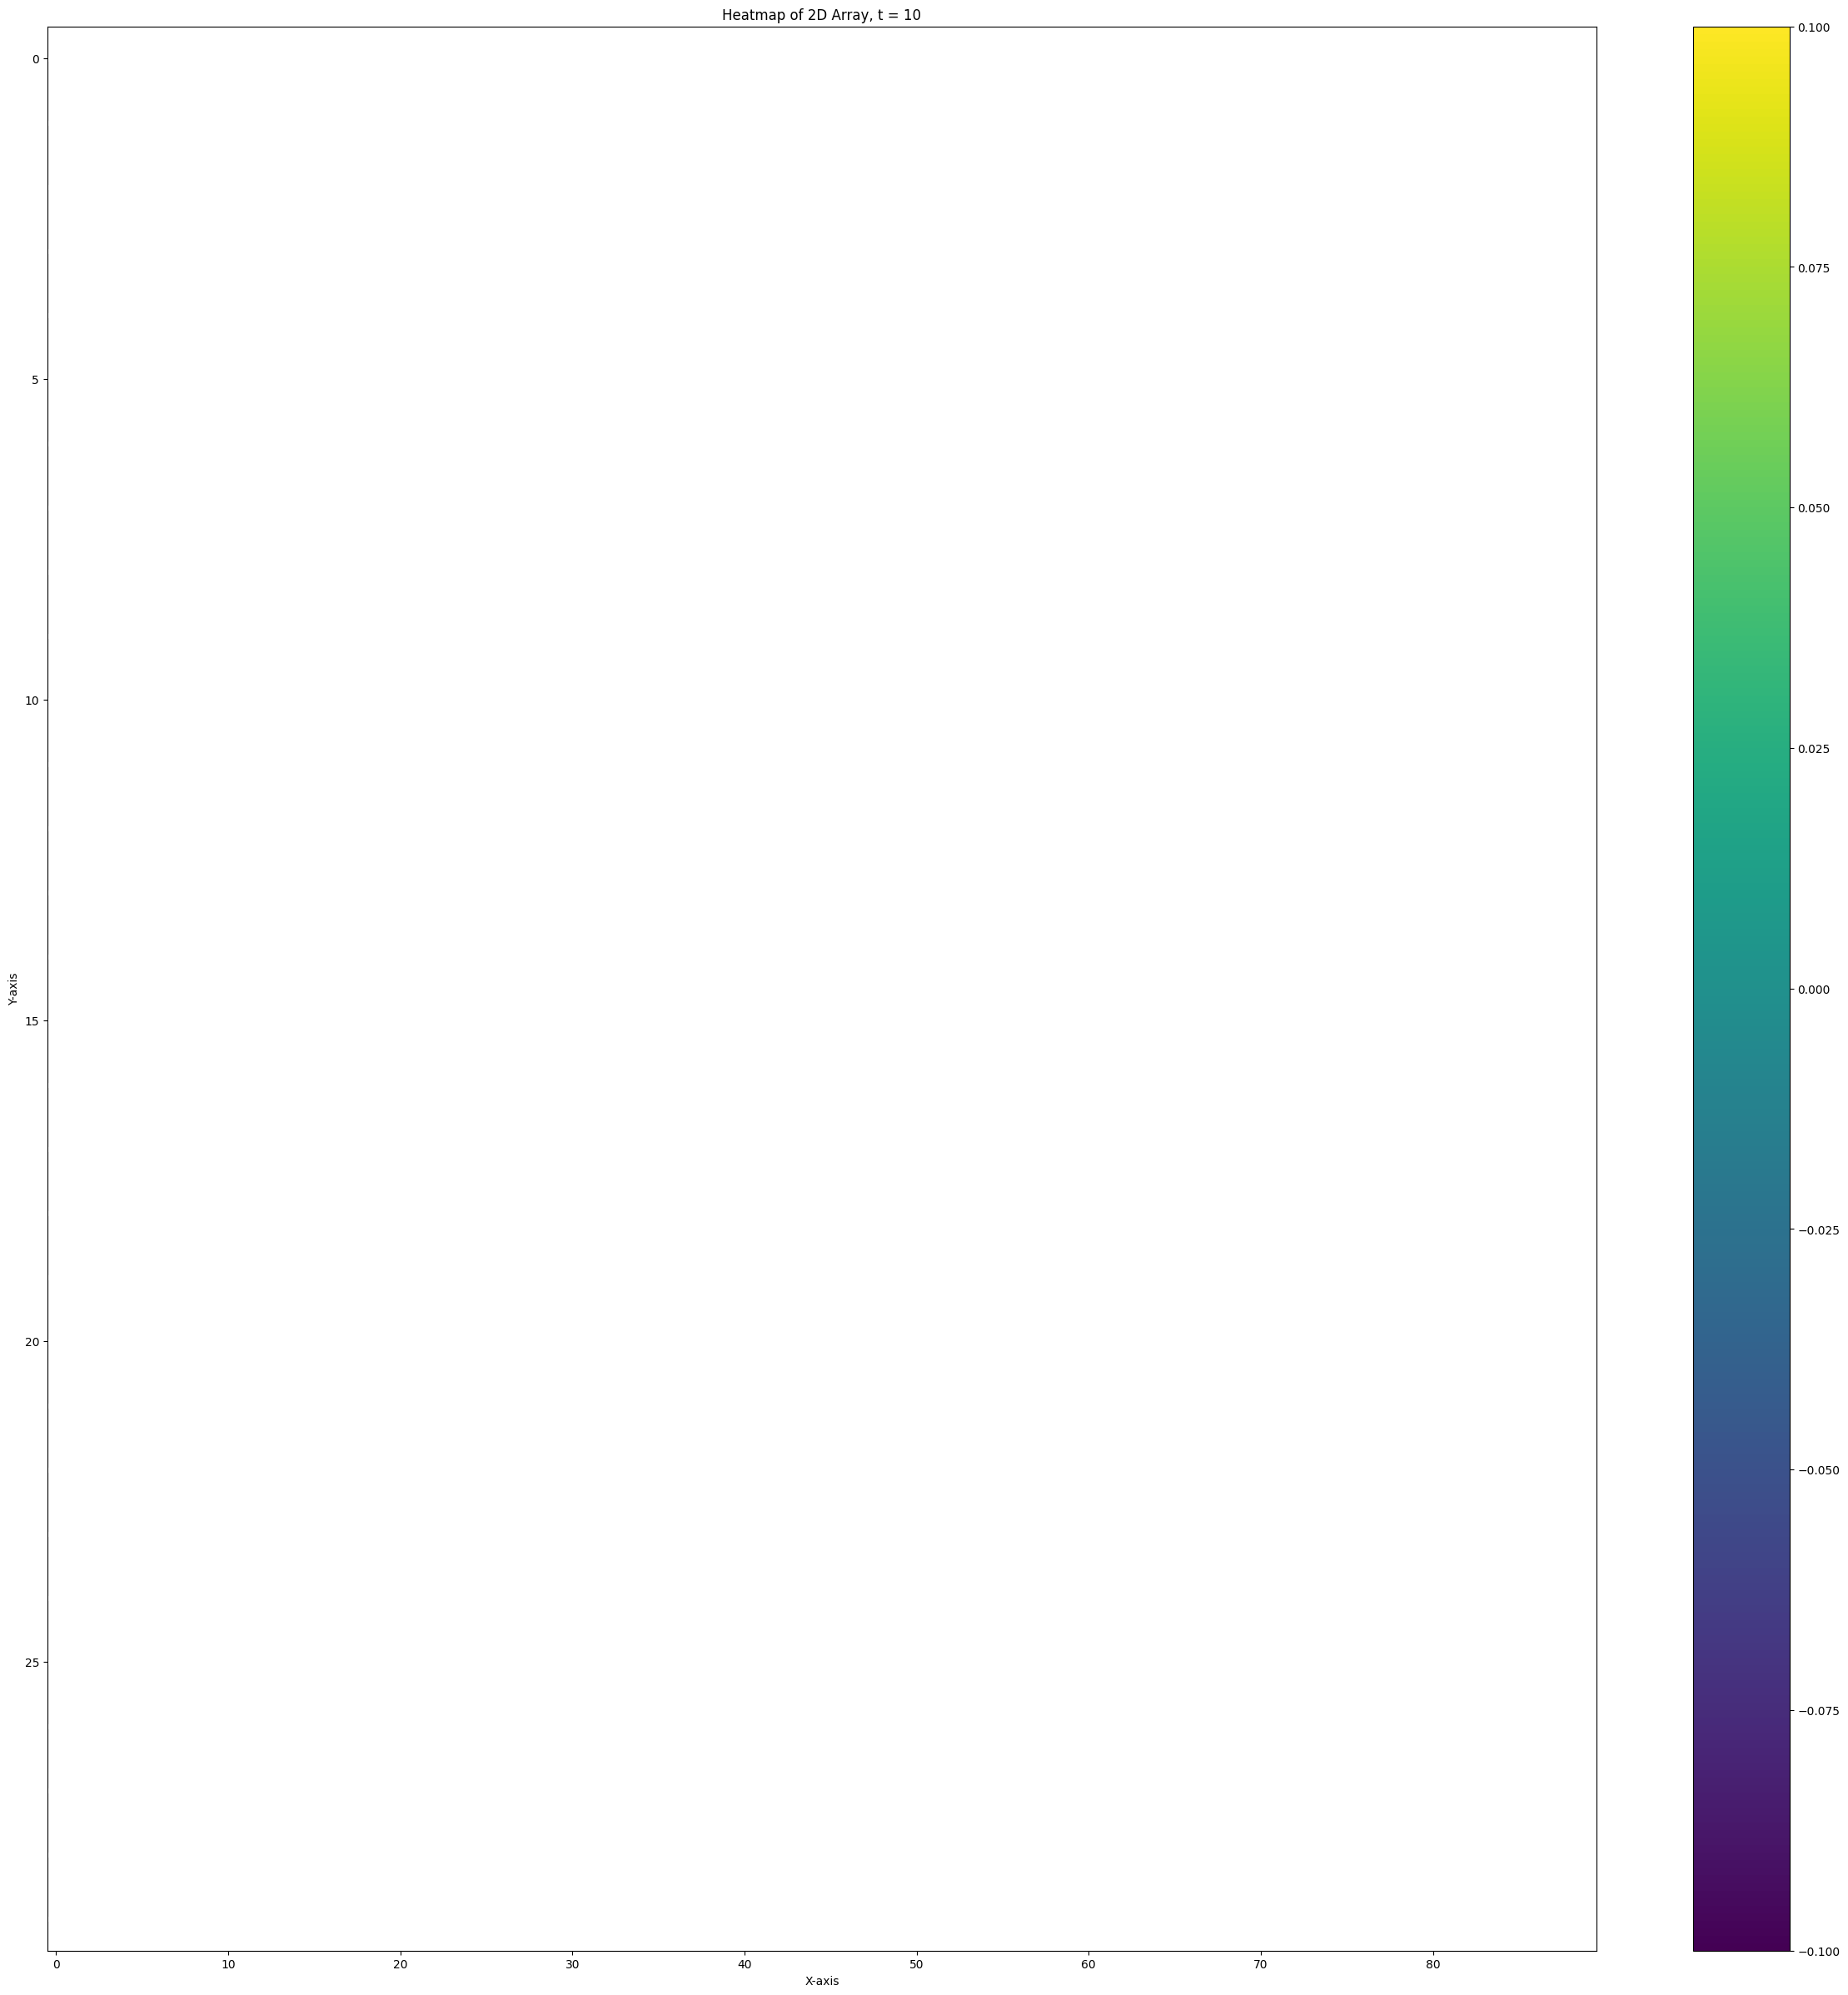

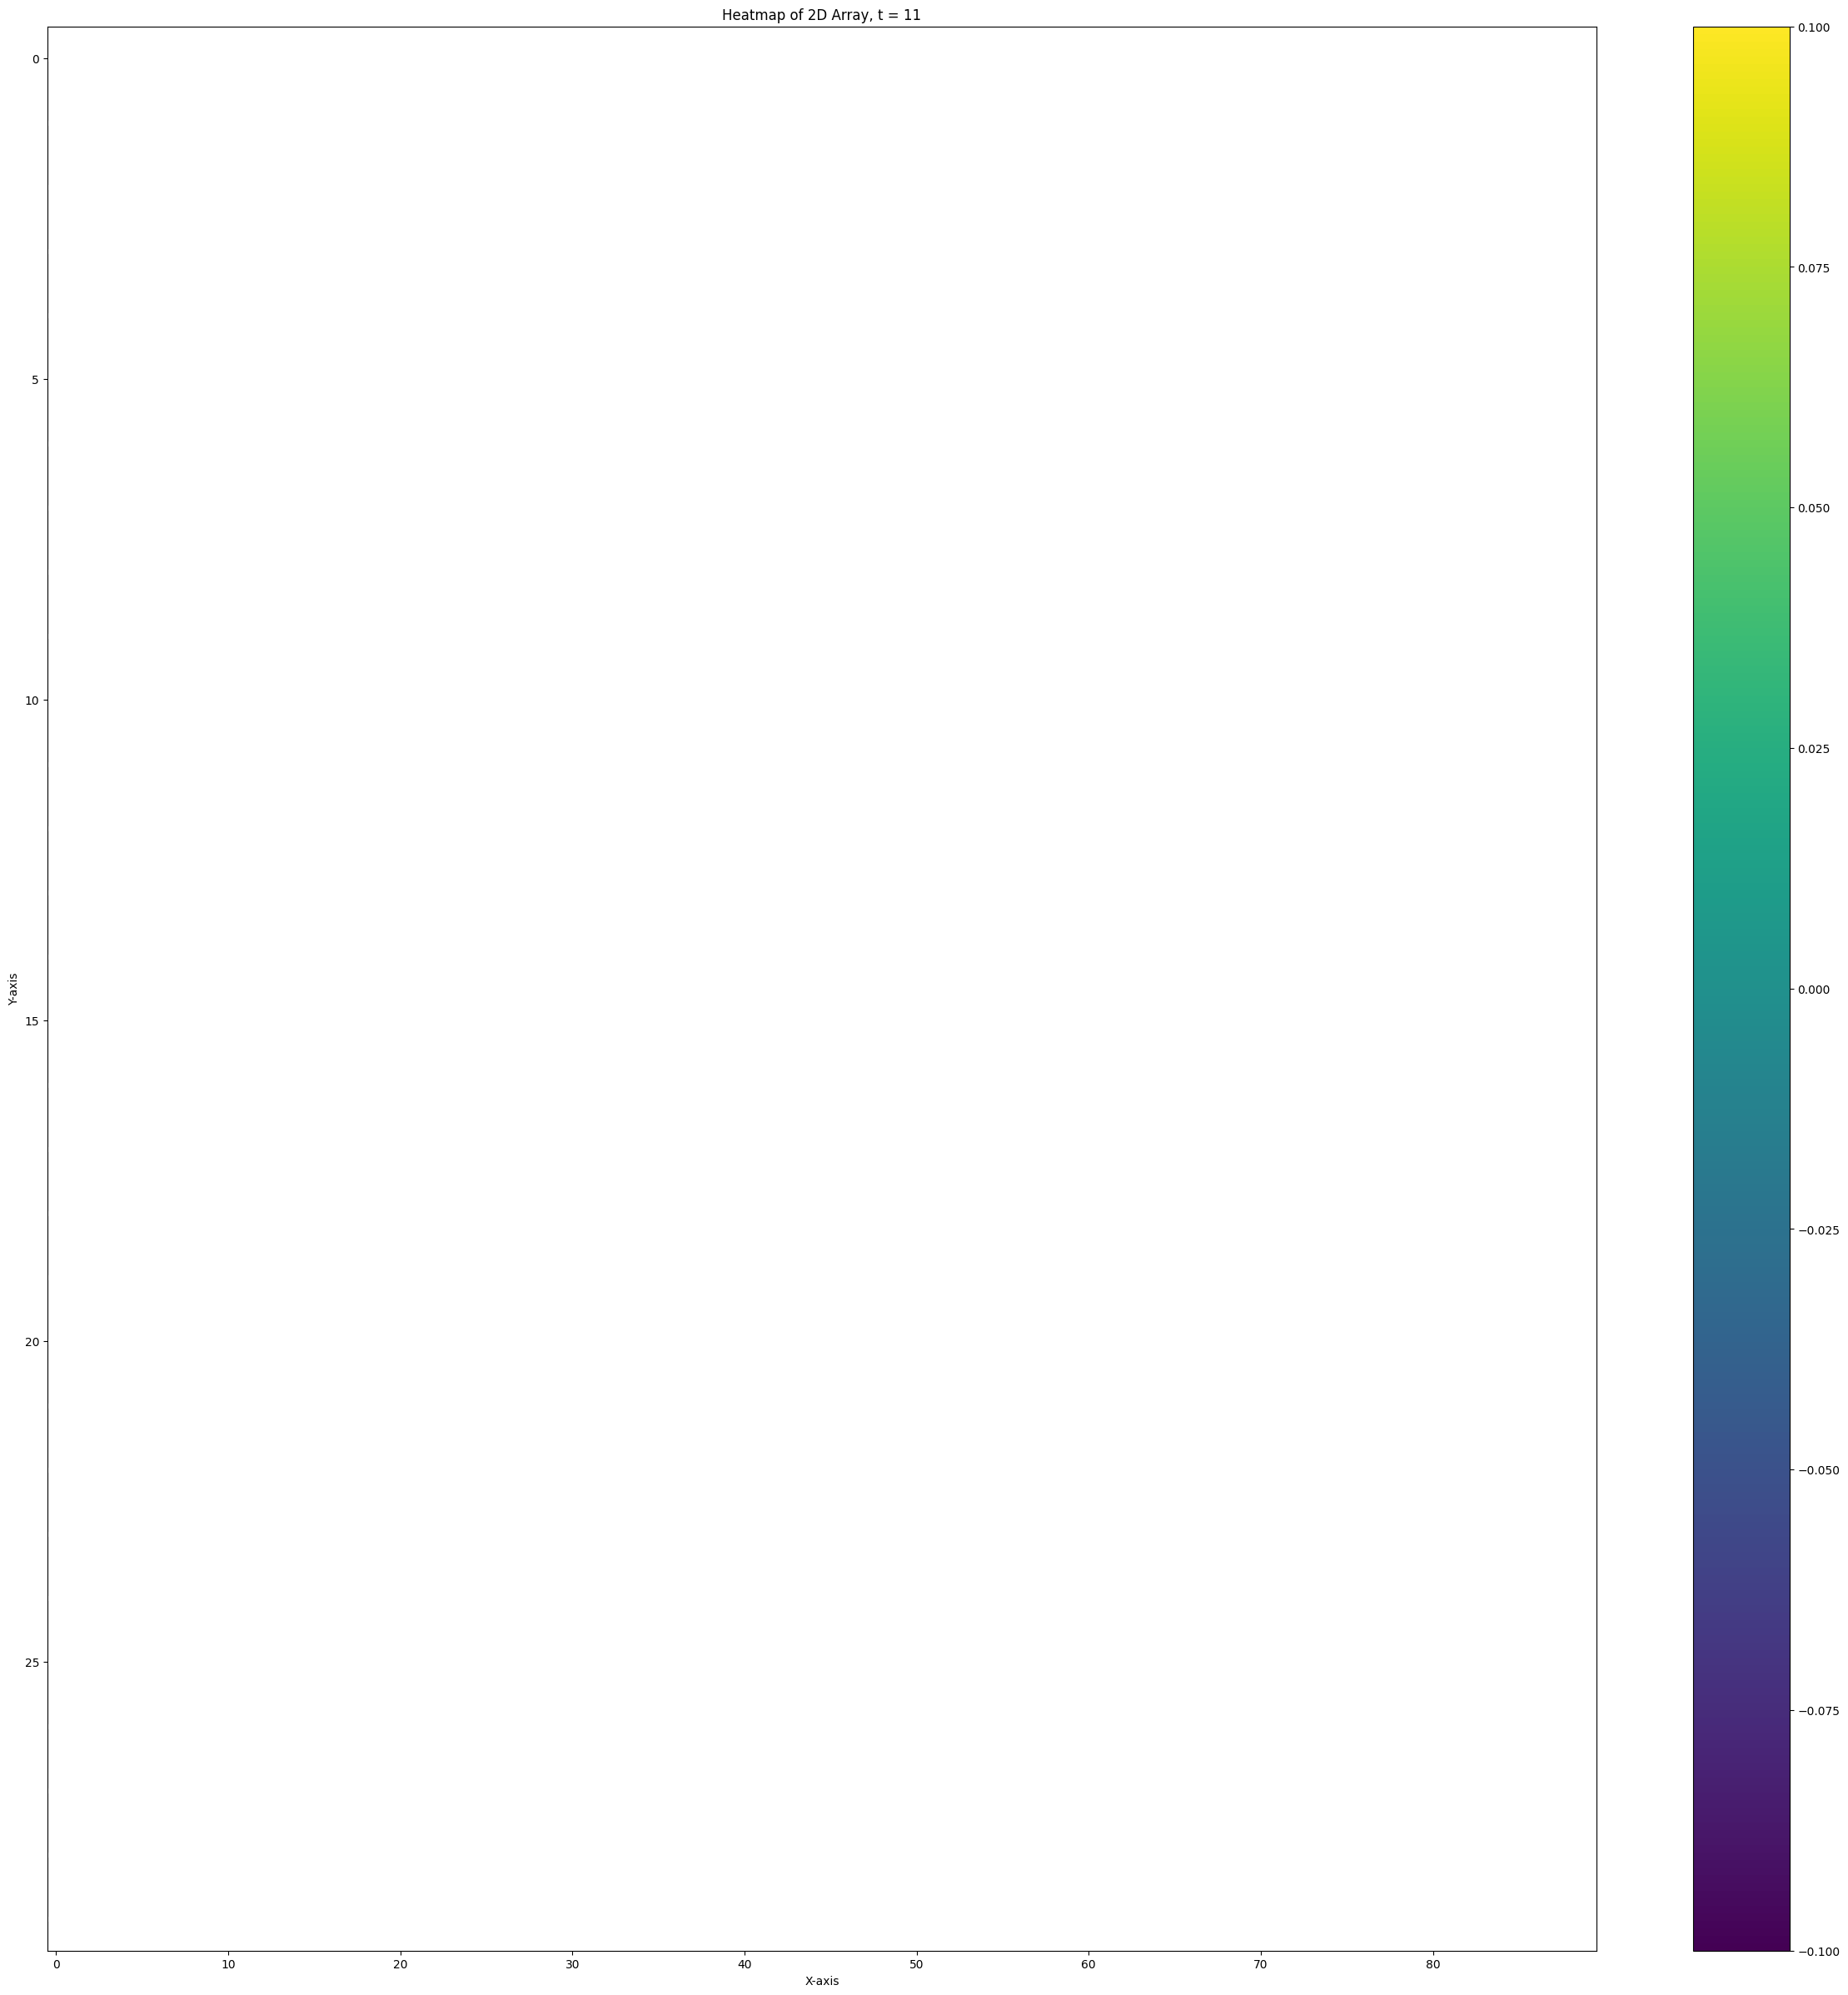

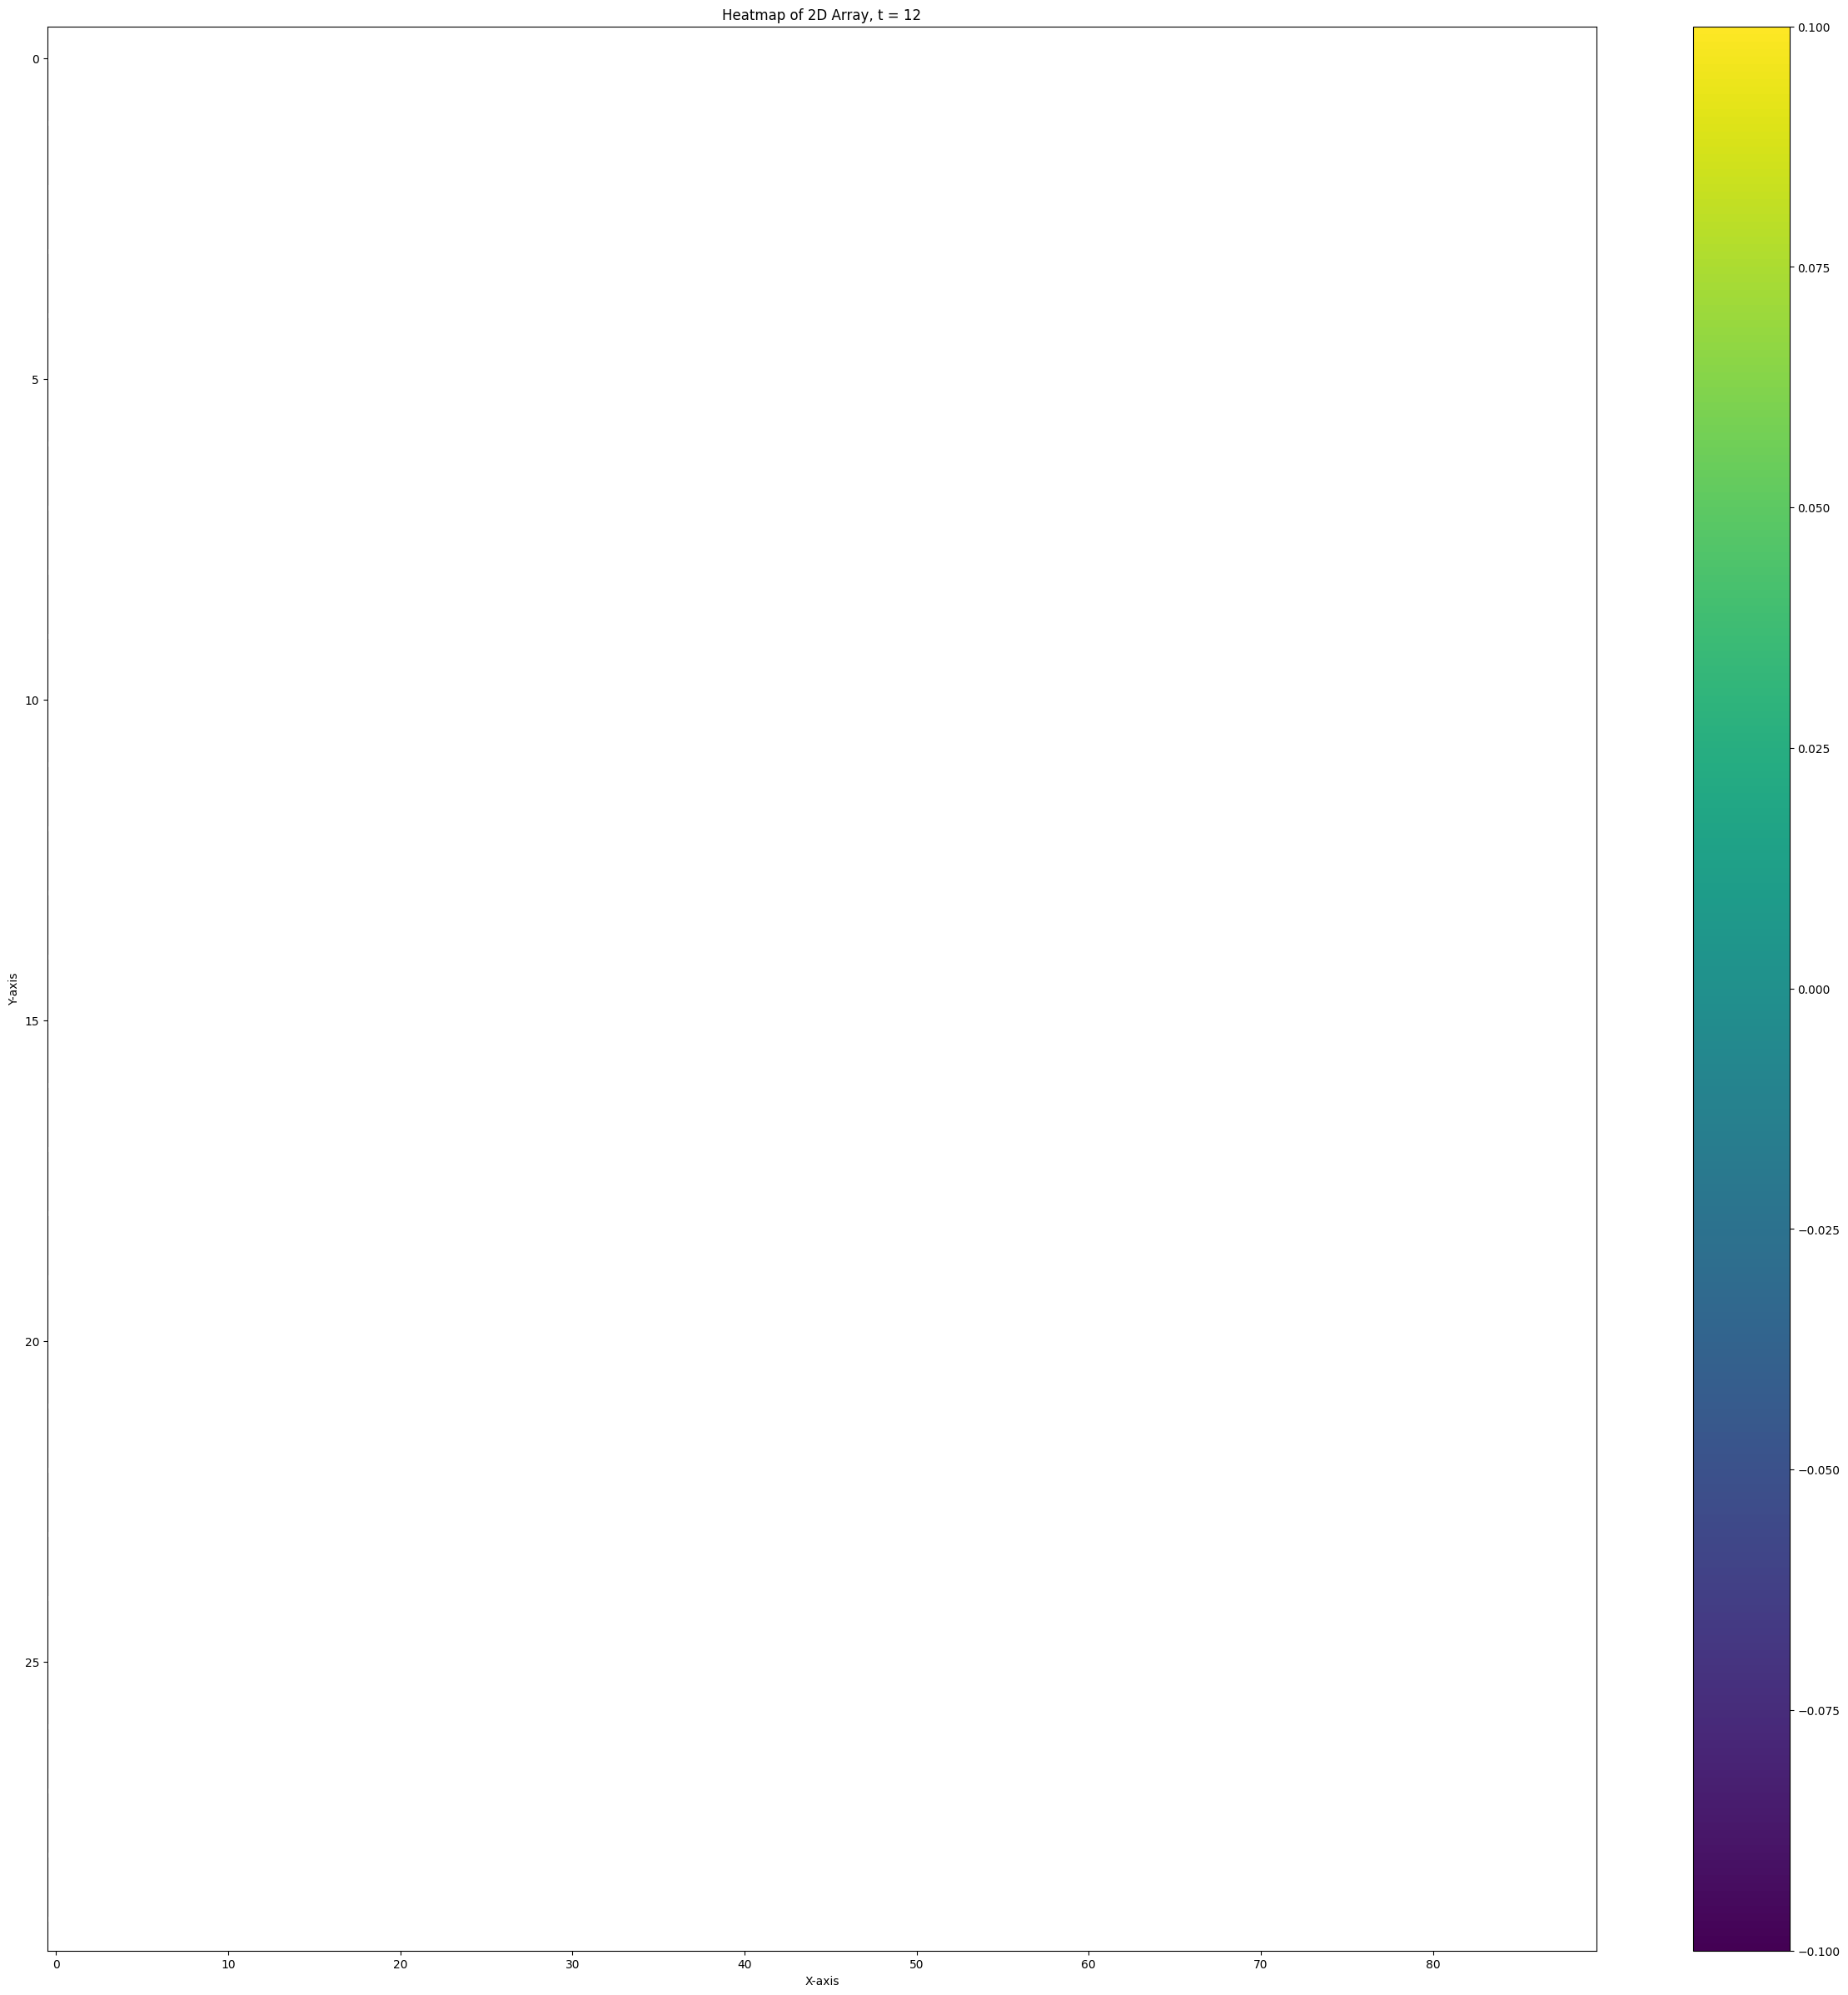

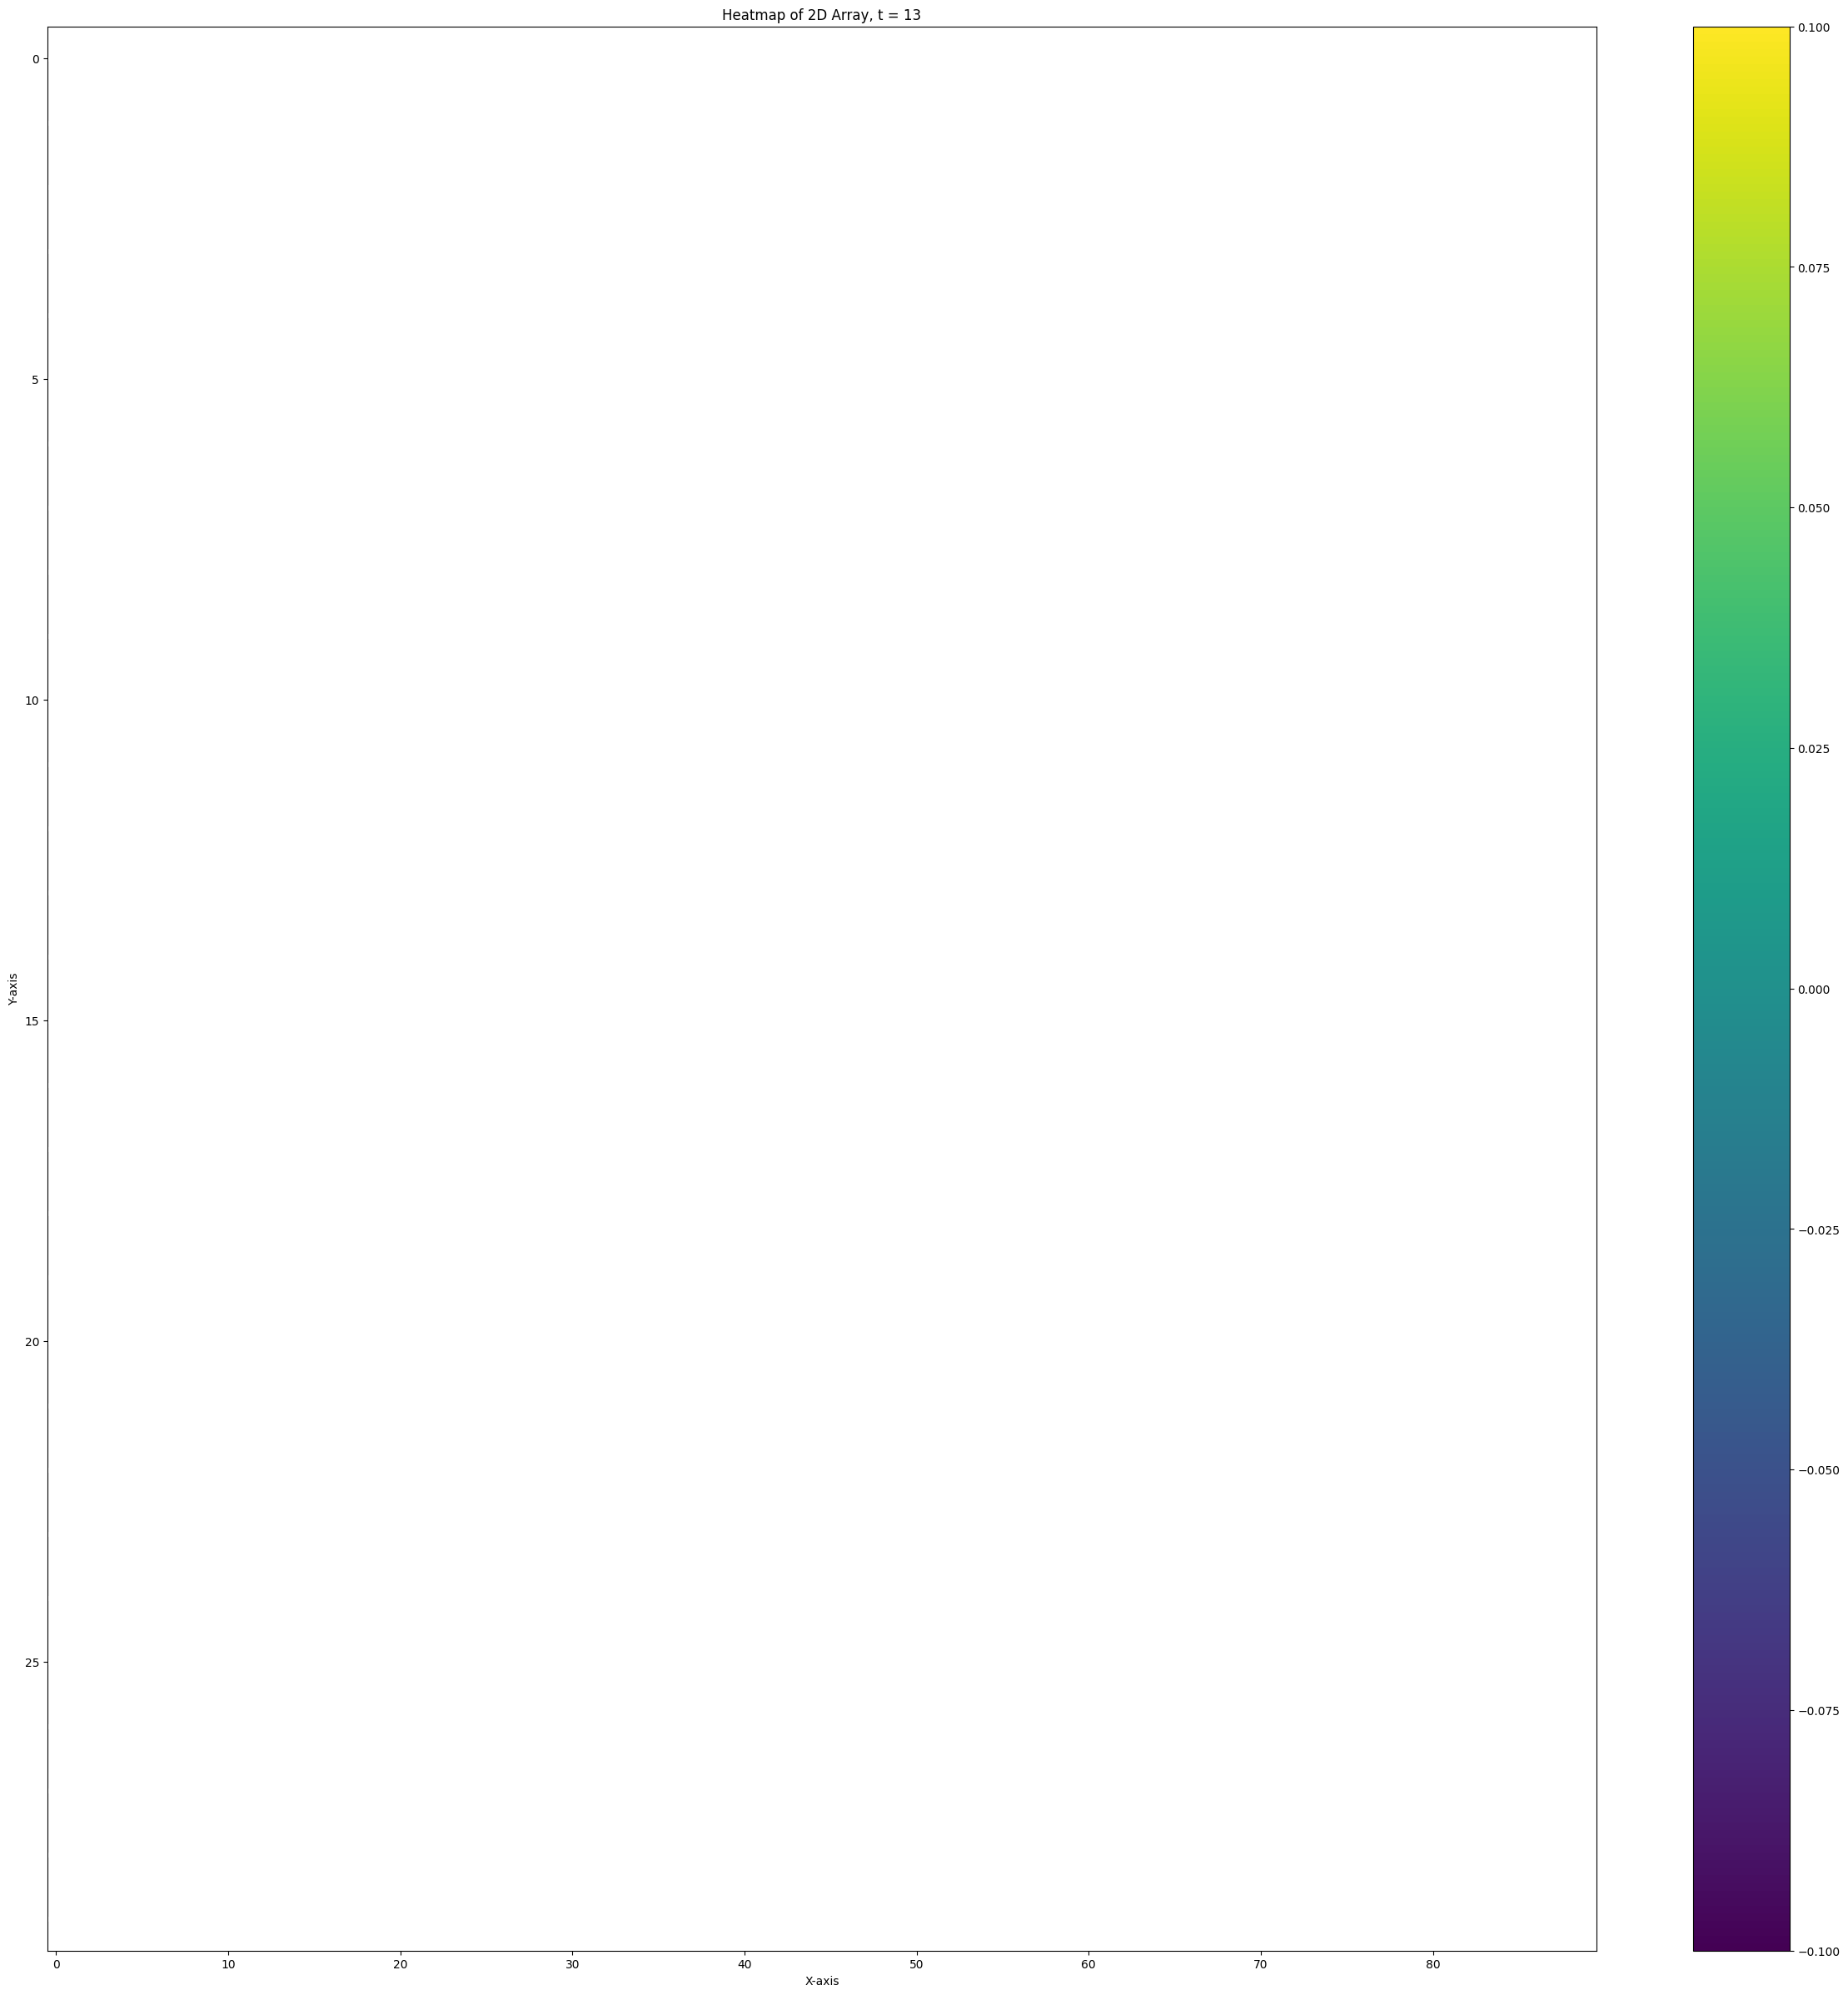

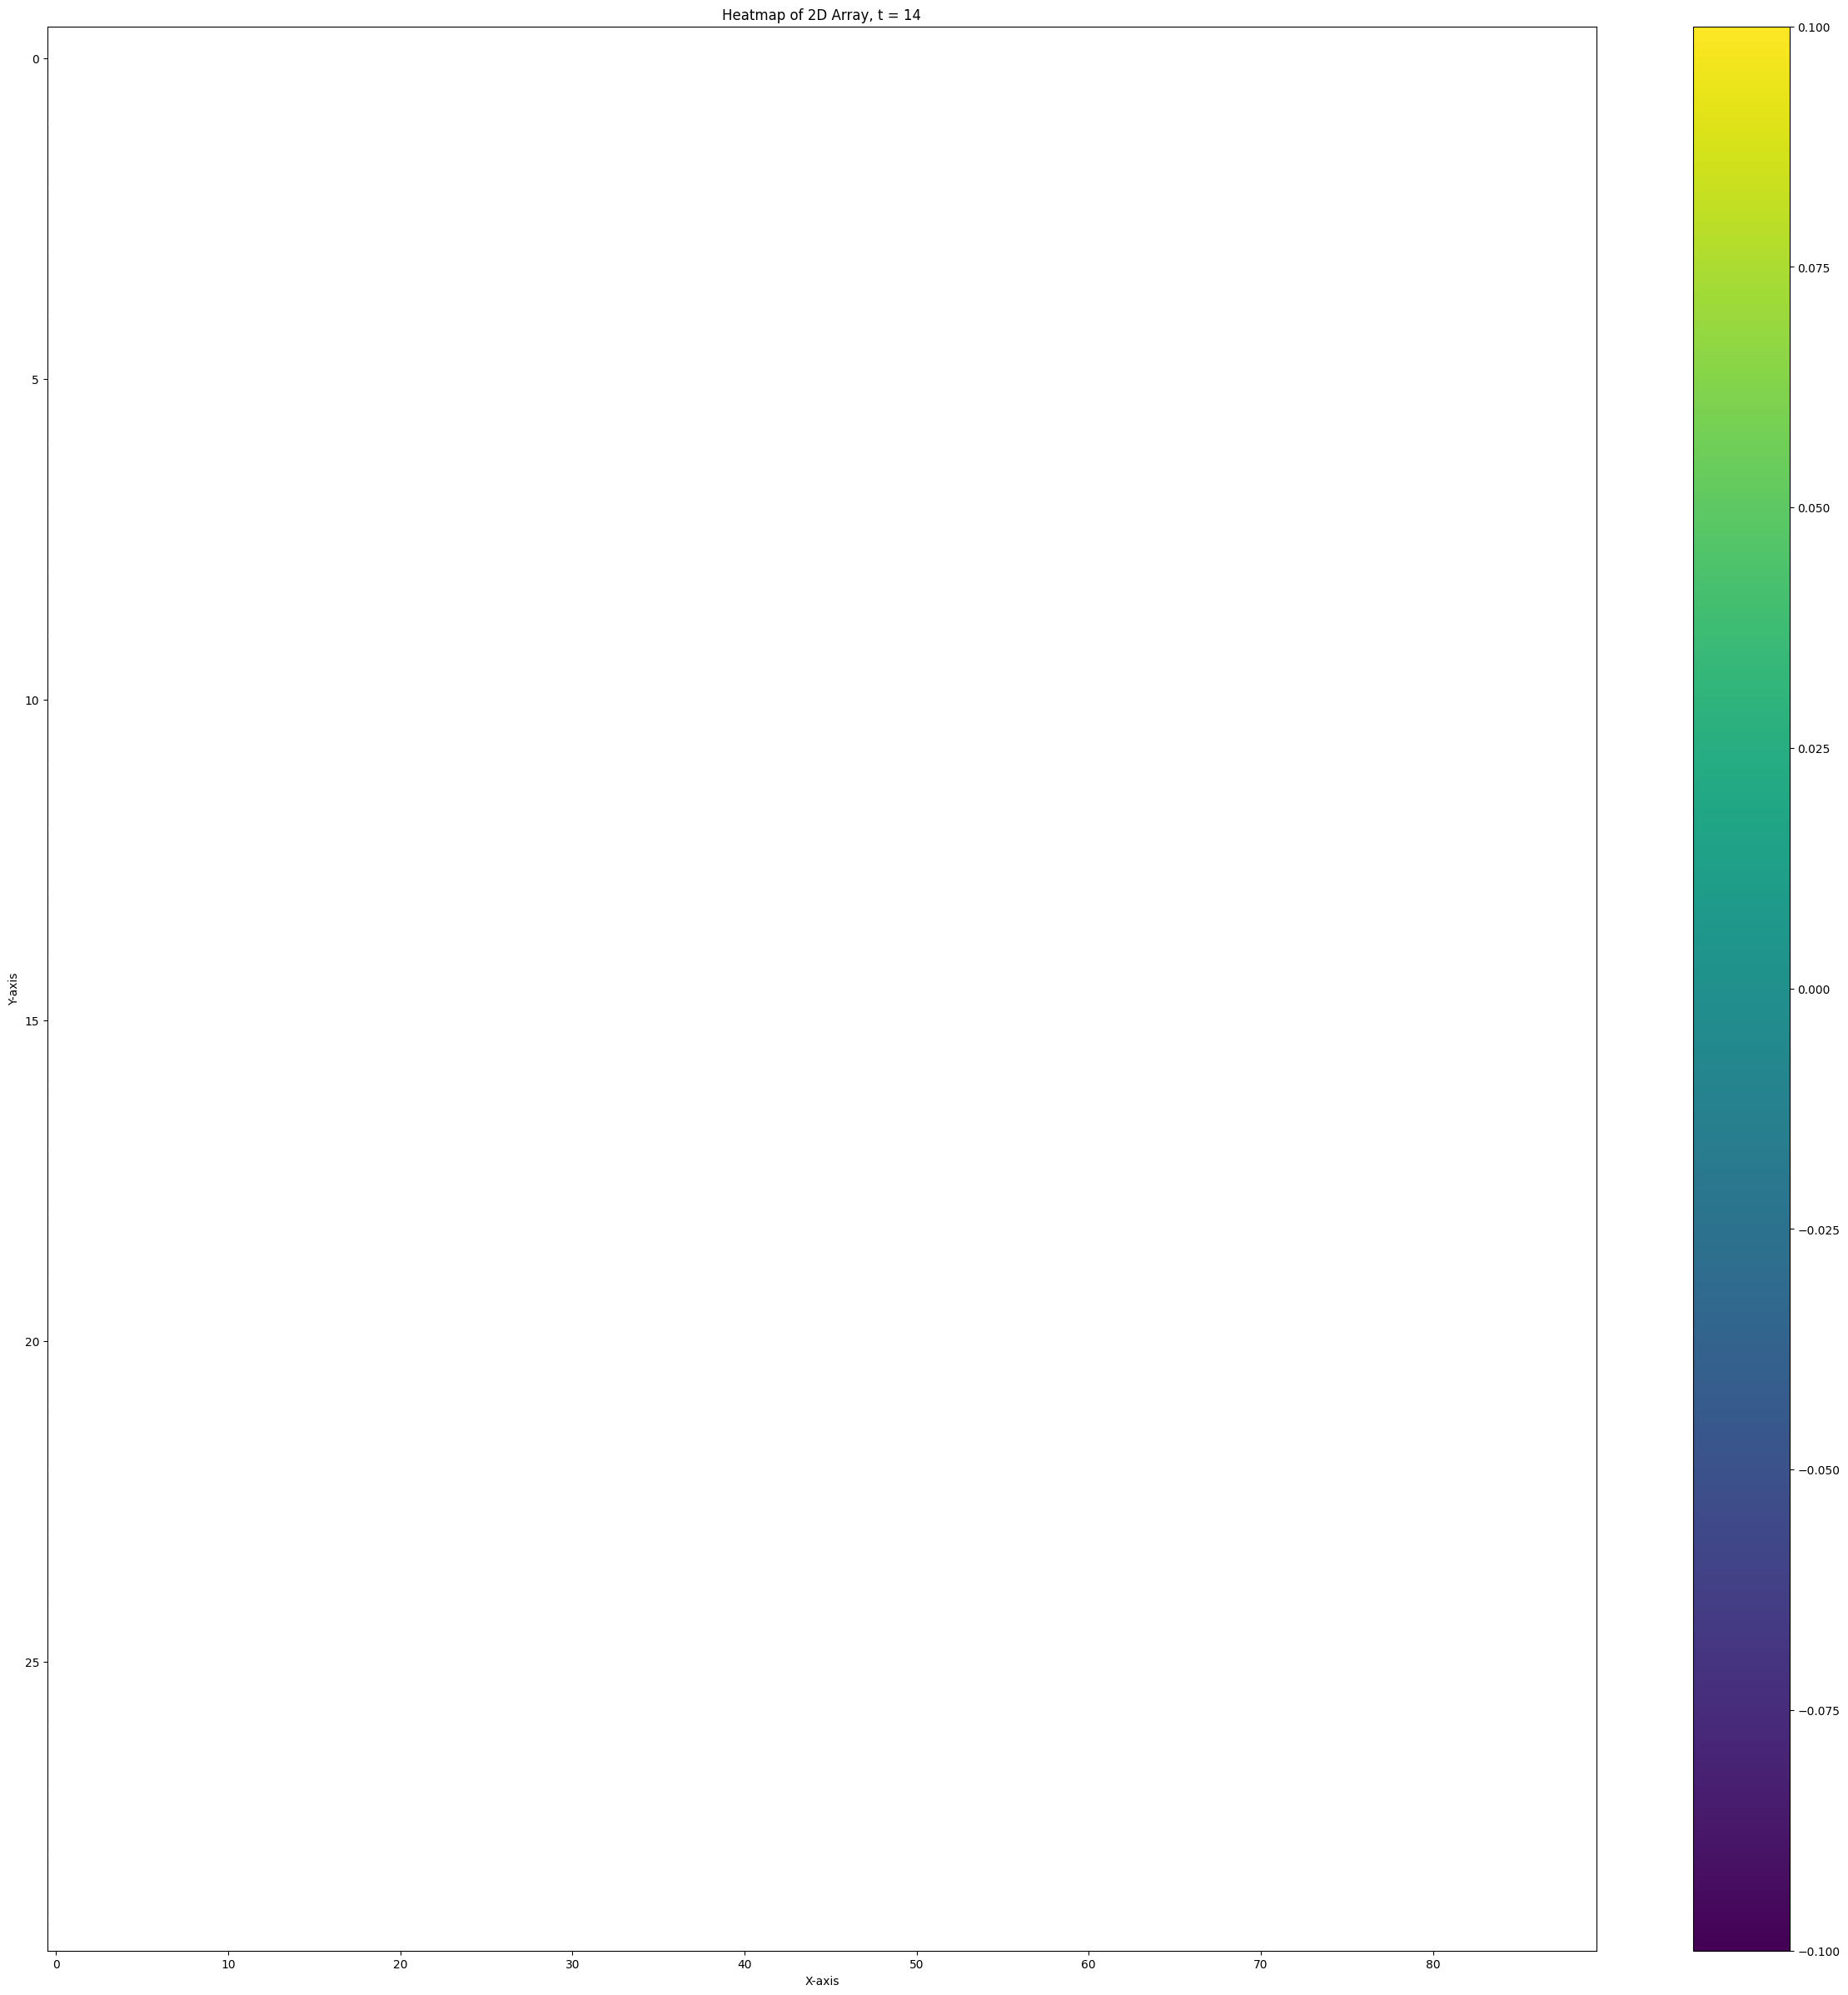

In [ ]:
import matplotlib.pyplot as plt
# Example 2D numpy array

times = list(range(15))

for t in times:
    data = x.V.D[0][t]
    # Plot the heatmap
    plt.figure(figsize=(30, 30))
    heatmap = plt.imshow(data, cmap='viridis', aspect='auto')
    plt.colorbar(heatmap)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, f'{data[i, j]:.1f}', ha='center', va='center', color='white', fontsize=8)

    # Add labels (optional)
    plt.title(f"Heatmap of 2D Array, t = {t}")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    plt.savefig(f'data/output/vanishing_walls_heatmap_t{t}.png')